# Crypto‑Currency Statistical Arbitrage

---
## 1  Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import functools
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
import seaborn as sns
plt.rcParams.update({'figure.figsize': (10,4),'axes.grid': True})

In [2]:
# -----------------------------------------------------------------------------
# Global configuration
# -----------------------------------------------------------------------------
UNIVERSE = ["BTCUSDT", "BCHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "LTCUSDT", "DOGEUSDT", "DGBUSDT", "DASHUSDT", "ZECUSDT", "RVNUSDT", "QTUMUSDT", "ZENUSDT", "SYSUSDT", "ETHUSDT", "UNIUSDT", "AAVEUSDT", "LINKUSDT", "COMPUSDT", "MKRUSDT", "SUSHIUSDT", "YFIUSDT", "CRVUSDT", "BATUSDT", "ZRXUSDT", "ENJUSDT", "LRCUSDT", "MANAUSDT", "STORJUSDT", "KNCUSDT", "SNXUSDT", "RADUSDT", "RENDERUSDT", "GRTUSDT", "AUDIOUSDT", "FETUSDT", "OXTUSDT", "ADAUSDT","AVAXUSDT","DOTUSDT","PEPEUSDT", "NEARUSDT", "ICPUSDT", "APTUSDT", "SUIUSDT", "FLOWUSDT", "HBARUSDT", "CHZUSDT", "ARBUSDT", "THETAUSDT", "KAVAUSDT", "LDOUSDT", "GALAUSDT", "SHIBUSDT", "EGLDUSDT", "CELRUSDT", "ZILUSDT", "XTZUSDT", "ANKRUSDT", "ONEUSDT", "KSMUSDT"]


START_DATE   = '1 Jan 2020'
INTERVAL_D   = '1d'
CACHE_FILE   = 'daily_prices.pkl'
FREQ_LIST = ['1h', '4h', '1d', '1w']
LOOKBACKS    = [5, 21, 63, 126, 252]     # trading‑day lookbacks
TXN_COST_BPS = 20                        # round‑trip transaction cost in bps

# Binance client (US endpoint)
from binance.client import Client as _BinanceClient
_client = _BinanceClient(tld='US')

# -----------------------------------------------------------------------------
# Helper – cached price loader
# -----------------------------------------------------------------------------
@functools.lru_cache(maxsize=64)
def get_px(sym: str,
           interval: str = INTERVAL_D,
           start: str | int = START_DATE) -> pd.DataFrame:
    """Return OHLCV DataFrame (UTC index, cols = ['close','vol'])."""
    raw = _client.get_historical_klines(sym, interval, start)
    if not raw:
        raise ValueError(f"No data returned for {sym} ({interval})")
    cols = ['open_time','open','high','low','close','vol',
            'close_time','q','n','tb','tq','ignore']
    df = pd.DataFrame(raw, columns=cols)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df[['close','vol']] = df[['close','vol']].astype(float)
    return df.set_index('open_time')[['close','vol']]


---
## 2  Data Acquisition

In [3]:
# ----------------------------------------------------------------------------------
# 2. DATA ACQUISITION  — download once, cache on disk, keep in‐memory '_store'
# ----------------------------------------------------------------------------------
CACHE_FILE = "daily_prices.pkl"

if os.path.exists(CACHE_FILE):
    _store = pd.read_pickle(CACHE_FILE)          # <-- dict {symbol: DataFrame}
else:
    _store = {sym: get_px(sym) for sym in UNIVERSE}
    pd.to_pickle(_store, CACHE_FILE)

# Build aligned price & volume panels (single-level columns = symbols)
prices  = (
    pd.concat([df['close'].rename(sym) for sym, df in _store.items()], axis=1)
      .sort_index()
      .ffill()
      .dropna(how="all")
)

volumes = (
    pd.concat([df['vol'].rename(sym) for sym, df in _store.items()], axis=1)
      .reindex(prices.index)   # align to price dates
      .ffill()
)
print("prices shape", prices.shape, "volumes shape", volumes.shape)


prices shape (2028, 61) volumes shape (2028, 61)


---
## 3  Pre‑processing

In [4]:
# Log‑returns (natural log)
rets = np.log(prices / prices.shift(1)).dropna()
rets.head()


BTCUSDT   BCHUSDT   BNBUSDT   SOLUSDT   XRPUSDT   LTCUSDT  \
open_time                                                                
2024-12-06  0.028887  0.054130  0.018700  0.001397  0.072862  0.003526   
2024-12-07  0.001343 -0.023972  0.025785  0.007168  0.078783 -0.017607   
2024-12-08  0.012661  0.022682 -0.012060 -0.004379 -0.004326  0.007510   
2024-12-09 -0.037567 -0.117299 -0.074928 -0.088678 -0.161964 -0.197729   
2024-12-10 -0.009161 -0.065410 -0.018039 -0.015755  0.070415 -0.010070   

            DOGEUSDT   DGBUSDT  DASHUSDT   ZECUSDT  ...   LDOUSDT  GALAUSDT  \
open_time                                           ...                       
2024-12-06  0.017662 -0.058553 -0.051277 -0.013692  ...  0.102312 -0.018411   
2024-12-07  0.042847  0.055917 -0.035040 -0.006416  ... -0.057441  0.029132   
2024-12-08  0.026963 -0.064891 -0.028052  0.063590  ...  0.007822 -0.007741   
2024-12-09 -0.119205 -0.169002 -0.217589 -0.238019  ... -0.172653 -0.230071   
2024-12-10 -0.047416  0.009957 -0.017190  0.011009  ...  0.003263 -0.052993   

            SHIBUSDT  EGLDUSDT  CELRUSDT   ZILUSDT   XTZUSDT  ANKRUSDT  \
open_time                                                                
2024-12-06  0.010464  0.049345  0.255907  0.020631  0.076573 -0.031283   
2024-12-07  0.038607 -0.059171 -0.075076 -0.012216  0.037571 -0.036151   
2024-12-08  0.006862  0.057201  0.070664 -0.050118 -0.037571  0.008979   
2024-12-09 -0.160491 -0.217287 -0.236578 -0.215828 -0.194278 -0.189424   
2024-12-10 -0.009166 -0.038855 -0.171575 -0.013206 -0.001389 -0.043020   

             ONEUSDT   KSMUSDT  
open_time                       
2024-12-06  0.223144  0.045487  
2024-12-07  0.131865 -0.040379  
2024-12-08 -0.055463  0.022561  
2024-12-09 -0.229800 -0.235018  
2024-12-10  0.000878 -0.011574  

[5 rows x 61 columns]

---
## 4  Feature Engineering

In [5]:
# Momentum signals: z‑score of cumulative returns over lookbacks
mom_z = {
    lb: prices.pct_change(lb).apply(lambda r: (r - r.mean()) / r.std(), axis=1)
    for lb in LOOKBACKS
}

# Short‑horizon reversal: 2‑day negative cumulative return
rev2 = -rets.rolling(2).sum()


---
## 5  Strategy Construction & Helper Functions

In [6]:
def backtest(sig: pd.DataFrame,
             r: pd.DataFrame,
             top_pct: float = 0.3,
             cost_bps: float = TXN_COST_BPS):
    """Cross‑sectional long/short backtest with linear transaction costs."""
    def _position(row):
        hi = row.quantile(1 - top_pct)
        lo = row.quantile(top_pct)
        return np.where(row > hi, 1,
                        np.where(row < lo, -1, 0))
    pos = sig.apply(_position, axis=1)
    pos = pd.DataFrame(pos.tolist(), index=sig.index, columns=sig.columns).shift(1).fillna(0)

    pnl = (pos * r).sum(axis=1)
    turnover = pos.diff().abs().sum(axis=1)
    return pnl - turnover * cost_bps / 1e4, pos

def perf_stats(p: pd.Series) -> pd.Series:
    ann = 365  # daily data
    cum = p.cumsum()
    dd  = cum.cummax() - cum
    return pd.Series({
        'AnnRet' : p.mean() * ann,
        'AnnVol' : p.std() * np.sqrt(ann),
        'Sharpe' : p.mean() / p.std() * np.sqrt(ann),
        'MaxDD'  : dd.max()
    })


---
## 6  Backtest & Evaluation

AnnRet  AnnVol  Sharpe   MaxDD
Momentum_21d -13.231   2.383  -5.551  73.660
Reversal_2d   88.118   6.827  12.908   1.487

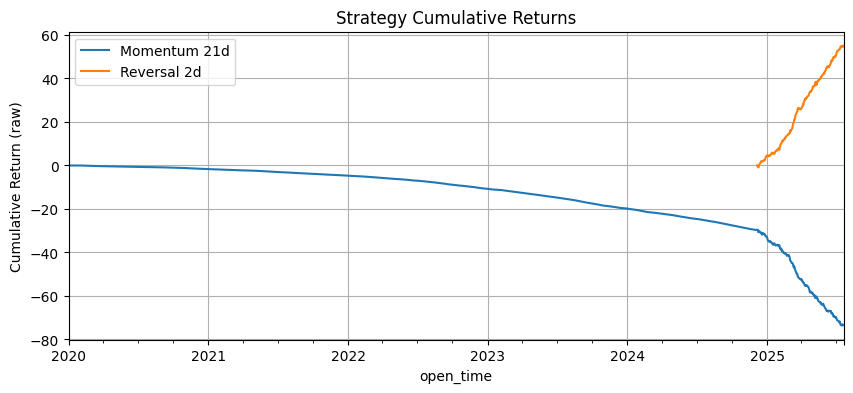

In [7]:
# Example: 21‑day momentum & 2‑day reversal
pnl_mom21, _ = backtest(mom_z[21], rets)
pnl_rev2 , _ = backtest(rev2, rets)

summary = pd.DataFrame({
    'Momentum_21d': perf_stats(pnl_mom21),
    'Reversal_2d' : perf_stats(pnl_rev2)
}).T.round(3)

display(summary)

# Visual: cumulative PnL
(pnl_mom21.cumsum()).plot(label='Momentum 21d')
(pnl_rev2 .cumsum()).plot(label='Reversal 2d')
plt.title('Strategy Cumulative Returns')
plt.ylabel('Cumulative Return (raw)')
plt.legend()
plt.show()


Sharpe
Lookback          
5        -8.406336
21       -5.551378
63       -3.976548
126      -2.627125
252      -1.571248

Text(0.5, 0, 'Lookback (days)')

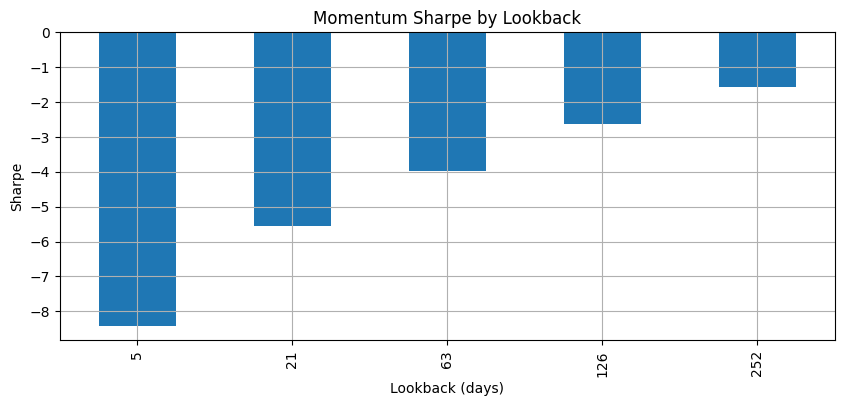

In [8]:
# Momentum lookback sweep
rows = []
for lb in LOOKBACKS:
    pnl,_ = backtest(mom_z[lb], rets)
    sharpe = perf_stats(pnl)['Sharpe']
    rows.append({'Lookback': lb, 'Sharpe': sharpe})

df_mom = pd.DataFrame(rows).set_index('Lookback')
display(df_mom)

ax = df_mom['Sharpe'].plot(kind='bar', title='Momentum Sharpe by Lookback')
ax.set_ylabel('Sharpe')
ax.set_xlabel('Lookback (days)')


---
## 7  Seasonality & Additional Studies

Alpha      Beta  Alpha t-stat  Beta  t-stat
Momentum -0.191306 -2.151878     -8.741148     -2.305433
Reversal  0.242104 -0.791131     10.192330     -0.780938

<Axes: title={'center': 'Alpha & Beta vs. BTC'}>

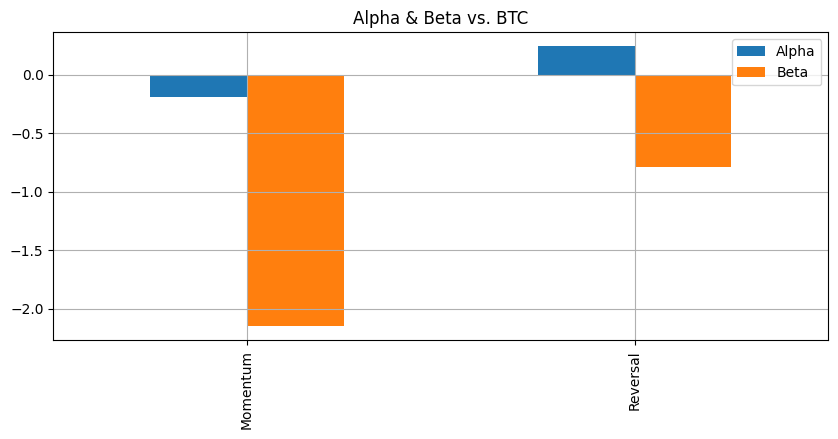

In [9]:
import statsmodels.api as sm

def alpha_beta(pnl_series):
    """
    Regress strategy PnL on BTC returns and return alpha, beta, and t-stats.
    """
    df = pd.DataFrame({
        'pnl': pnl_series,
        'btc': rets['BTCUSDT']
    }).dropna()

    model = sm.OLS(df['pnl'], sm.add_constant(df['btc'])).fit()

    # Pack results in a Series with clear English names
    return pd.Series({
        'Alpha':        model.params['const'],
        'Beta':         model.params['btc'],
        'Alpha t-stat': model.tvalues['const'],
        'Beta  t-stat': model.tvalues['btc']
    })

# Compute alpha/beta for Momentum and Reversal
ab = pd.concat({
    'Momentum': alpha_beta(pnl_mom21),
    'Reversal': alpha_beta(pnl_rev2)
}, axis=1).T

display(ab)

# Bar chart of Alpha and Beta
ab[['Alpha', 'Beta']].plot(kind='bar', title='Alpha & Beta vs. BTC')


---
## 8  Short‑Horizon Reversal Deep‑Dive

Sharpe     Alpha      Beta  Alpha t-stat  Beta  t-stat
Look                                                          
1     1.298266  0.026747 -0.150358      1.025896     -0.135225
2     0.611544  0.012678 -0.363201      0.493196     -0.331301
3     0.619141  0.012952 -1.148893      0.528644     -1.099498

<Axes: title={'center': 'Reversal Sharpe'}, xlabel='Look'>

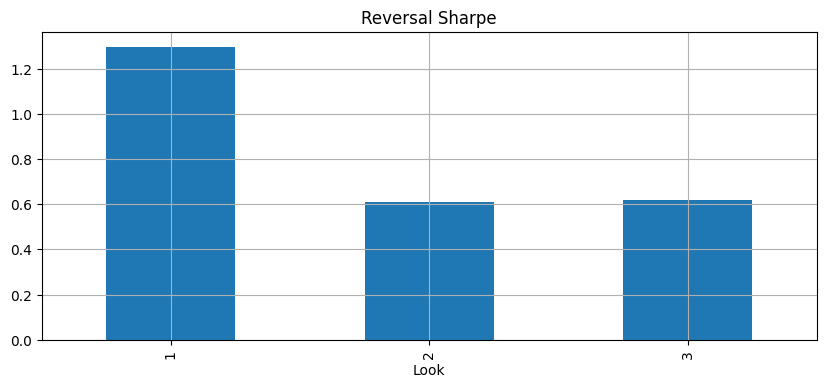

In [10]:
# volume frame
vol=pd.concat({s:get_px(s,'1d')['vol'] for s in UNIVERSE},axis=1).reindex(prices.index).ffill()
v75=vol.rolling(252).quantile(.75)
out=[]
for lb in [1,2,3]:
    sig=-rets.rolling(lb).sum().where(vol>=v75,0)
    pnl,_=backtest(sig,rets)
    out.append({'Look':lb,'Sharpe':pnl.mean()/pnl.std()*np.sqrt(365),**alpha_beta(pnl)})
rev_df=pd.DataFrame(out).set_index('Look'); display(rev_df)
rev_df['Sharpe'].plot(kind='bar',title='Reversal Sharpe')

---
## 9  Seasonality – Weekday vs Weekend

                Sharpe
Mom Weekday  -5.657638
Mom Weekend  -5.277745
Rev Weekday  15.215823
Rev Weekend   8.673108


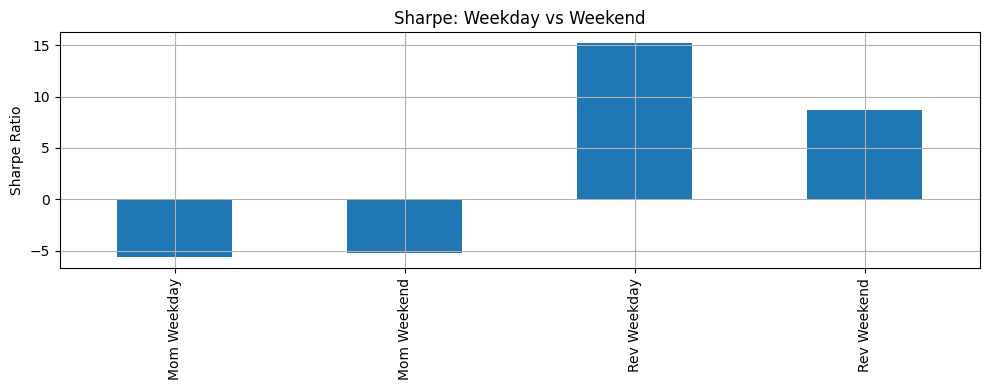

In [11]:
# --- Seasonality: Weekday vs. Weekend (fixed masks) ---

import matplotlib.pyplot as plt

# Build weekend masks for each series
mask_mom_weekend = pnl_mom21.index.weekday >= 5
mask_rev_weekend = pnl_rev2.index.weekday >= 5

# Compute Sharpe for each slice
mom_wk_sharpe   = perf_stats(pnl_mom21[~mask_mom_weekend])['Sharpe']
mom_we_sharpe   = perf_stats(pnl_mom21[ mask_mom_weekend])['Sharpe']
rev_wk_sharpe   = perf_stats(pnl_rev2[ ~mask_rev_weekend])['Sharpe']
rev_we_sharpe   = perf_stats(pnl_rev2[  mask_rev_weekend])['Sharpe']

# Assemble into a DataFrame
season_df = pd.DataFrame({
    'Mom Weekday': mom_wk_sharpe,
    'Mom Weekend': mom_we_sharpe,
    'Rev Weekday': rev_wk_sharpe,
    'Rev Weekend': rev_we_sharpe
}, index=['Sharpe']).T

# Show and plot
print(season_df)
season_df.plot(kind='bar', legend=False, title='Sharpe: Weekday vs Weekend')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

---
## 10  Seasonality – Intraday Hour

Text(0.5, 0, 'Hour')

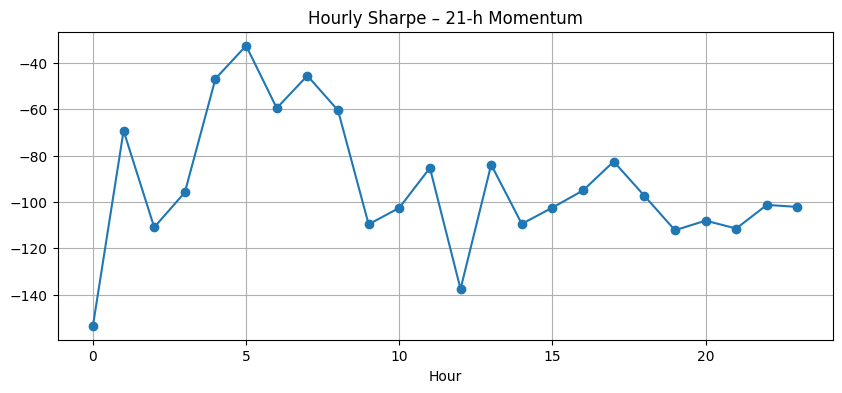

In [12]:
start=(datetime.utcnow()-timedelta(days=28)).strftime('%d %b %Y %H:%M:%S')
px_h={s:get_px(s,'1h',start)['close'] for s in UNIVERSE}
px_h=pd.concat(px_h,axis=1).ffill().dropna(how='all')
r_h=np.log(px_h/px_h.shift(1)).dropna(how='all')
mom_h=r_h.rolling(21).sum().apply(lambda r:(r-r.mean())/r.std(),axis=1)
pnl_h,_=backtest(mom_h,r_h)
dfh=pd.DataFrame({'pnl':pnl_h,'hr':r_h.index.hour}).dropna()
agg=dfh.groupby('hr')['pnl'].agg(['mean','std']); agg['Sharpe']=agg['mean']/agg['std']*np.sqrt(365*24)
agg['Sharpe'].plot(marker='o',title='Hourly Sharpe – 21‑h Momentum'); plt.xlabel('Hour')

---
## 11  Execution & Extensions

In [13]:
def backtest_adapt(sig,r,lo=7,hi=20):
    pos=sig.apply(lambda row: np.where(row>row.quantile(.7),1,np.where(row<row.quantile(.3),-1,0)),axis=1)
    pos=pd.DataFrame(pos.tolist(),index=sig.index,columns=sig.columns).shift(1).fillna(0)
    pnl=(pos*r).sum(axis=1); roll=pnl.rolling(5).sum().shift(1)
    turn=pos.diff().abs().sum(axis=1); cost=turn*np.where(roll>0,lo,hi)/1e4
    return pnl-cost
pnl_ma=backtest_adapt(mom_z[21],rets); pnl_ra=backtest_adapt(rev2,rets)
blend=risk= (1/pd.concat([pnl_ma,pnl_ra],axis=1).rolling(60).std()).apply(lambda r:r/r.sum(),axis=1)
blend=(blend*pnl_ma).iloc[:,0]+(blend*pnl_ra).iloc[:,1]
perf=pd.concat({'Mom‑Adapt':perf_stats(pnl_ma),'Rev‑Adapt':perf_stats(pnl_ra),'Blend':perf_stats(blend)},axis=1); display(perf)

Mom‑Adapt   Rev‑Adapt  Blend
AnnRet -13.139757  106.304179    NaN
AnnVol   2.376705    6.863082    NaN
Sharpe  -5.528561   15.489277    NaN
MaxDD   73.191570    1.390413    NaN

---
## 12  Performance Tear‑sheet

In [14]:
display(perf.T)

AnnRet    AnnVol     Sharpe      MaxDD
Mom‑Adapt  -13.139757  2.376705  -5.528561  73.191570
Rev‑Adapt  106.304179  6.863082  15.489277   1.390413
Blend             NaN       NaN        NaN        NaN

---
## 13  Next Steps

In [15]:
pairs = [
    ('ETHUSDT', 'BTCUSDT'),
    ('SOLUSDT','AVAXUSDT'),
    ('ADAUSDT','DOGEUSDT'),
    ('BNBUSDT','PEPEUSDT')
]

In [16]:
baskets = {
    'Altcoins1': ['ETHUSDT','SOLUSDT','ADAUSDT'],
    'Altcoins2': ['BNBUSDT','DOTUSDT','PEPEUSDT']
}

results = []

In [17]:
for asset_A, asset_B in pairs:
    df = pd.concat({
        'price_A': prices[asset_A],
        'price_B': prices[asset_B],
        'ret_A':   rets[asset_A],
        'ret_B':   rets[asset_B]
    }, axis=1).dropna()

    # estimate hedge ratio
    model_price = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit()
    beta_hat = model_price.params['price_B']

    # spread and z-score
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()

    # signal
    signal = pd.Series(
        np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
        index=spread.index
    )

    # pnl and cost
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    cost = turnover * 20 / 1e4
    pnl_net = pnl_raw - cost

    # performance metrics
    ann_return = pnl_net.mean() * 365
    ann_vol = pnl_net.std() * np.sqrt(365)
    sharpe = ann_return / ann_vol if ann_vol else np.nan
    max_dd = (pnl_net.cumsum().cummax() - pnl_net.cumsum()).max()

    # alpha/beta vs BTC
    df_reg = pd.DataFrame({'pnl': pnl_net, 'btc_ret': rets['BTCUSDT']}).dropna()
    model_reg = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    alpha = model_reg.params['const']
    beta = model_reg.params['btc_ret']
    alpha_t = model_reg.tvalues['const']
    beta_t = model_reg.tvalues['btc_ret']

    results.append({
        'instrument': f"{asset_A}-{asset_B}",
        'sharpe': sharpe,
        'annual_return': ann_return,
        'annual_vol': ann_vol,
        'max_drawdown': max_dd,
        'alpha': alpha,
        'beta': beta,
        'alpha_tstat': alpha_t,
        'beta_tstat': beta_t
    })

In [18]:
for basket_name, assets in baskets.items():
    # basket price and returns
    basket_price = prices[assets].mean(axis=1)
    basket_ret = rets[assets].mean(axis=1)

    df = pd.concat({
        'price_A': basket_price,
        'price_B': prices['BTCUSDT'],
        'ret_A':   basket_ret,
        'ret_B':   rets['BTCUSDT']
    }, axis=1).dropna()

    # hedge ratio
    model_price = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit()
    beta_hat = model_price.params['price_B']

    # spread and z-score
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()

    # signal
    signal = pd.Series(
        np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
        index=spread.index
    )

    # pnl and cost
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    cost = turnover * 20 / 1e4
    pnl_net = pnl_raw - cost

    # performance metrics
    ann_return = pnl_net.mean() * 365
    ann_vol = pnl_net.std() * np.sqrt(365)
    sharpe = ann_return / ann_vol if ann_vol else np.nan
    max_dd = (pnl_net.cumsum().cummax() - pnl_net.cumsum()).max()

    # alpha/beta vs BTC
    df_reg = pd.DataFrame({'pnl': pnl_net, 'btc_ret': rets['BTCUSDT']}).dropna()
    model_reg = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    alpha = model_reg.params['const']
    beta = model_reg.params['btc_ret']
    alpha_t = model_reg.tvalues['const']
    beta_t = model_reg.tvalues['btc_ret']

    results.append({
        'instrument': f"Basket-{basket_name}",
        'sharpe': sharpe,
        'annual_return': ann_return,
        'annual_vol': ann_vol,
        'max_drawdown': max_dd,
        'alpha': alpha,
        'beta': beta,
        'alpha_tstat': alpha_t,
        'beta_tstat': beta_t
    })

In [19]:
df_results = pd.DataFrame(results).set_index('instrument')
print(df_results)


                    sharpe  annual_return    annual_vol  max_drawdown  \
instrument                                                              
ETHUSDT-BTCUSDT  -0.265484  -3.287412e-02  1.238273e-01  9.073740e-02   
SOLUSDT-AVAXUSDT -1.451613  -9.453967e-01  6.512732e-01  7.023796e-01   
ADAUSDT-DOGEUSDT -1.588675  -5.948375e-01  3.744237e-01  4.215292e-01   
BNBUSDT-PEPEUSDT  1.655264   3.380549e+06  2.042303e+06  1.146785e+06   
Basket-Altcoins1  0.406393   6.894412e-02  1.696491e-01  7.851963e-02   
Basket-Altcoins2 -3.128303  -4.587207e-01  1.466356e-01  2.347810e-01   

                        alpha           beta  alpha_tstat  beta_tstat  
instrument                                                             
ETHUSDT-BTCUSDT     -0.000055      -0.047517    -0.128994   -2.613162  
SOLUSDT-AVAXUSDT    -0.002679       0.119541    -1.182011    1.235503  
ADAUSDT-DOGEUSDT    -0.001506      -0.167262    -1.175903   -3.058678  
BNBUSDT-PEPEUSDT  9682.270919 -568736.593344     1.3686

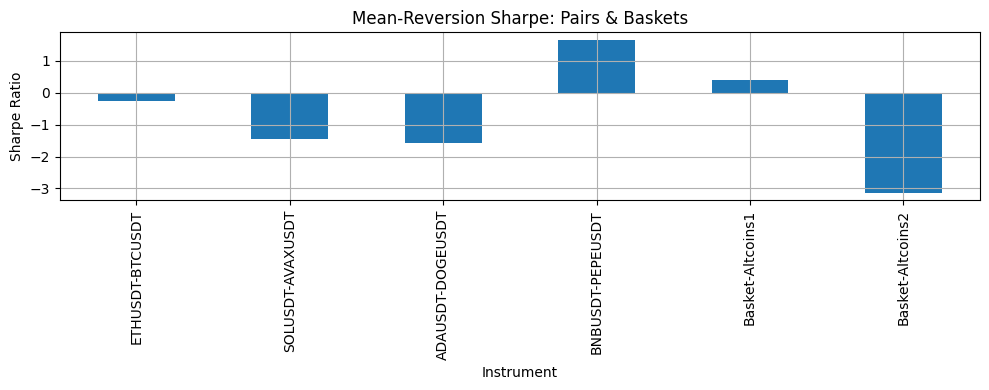

In [20]:
df_results['sharpe'].plot(kind='bar', title='Mean-Reversion Sharpe: Pairs & Baskets')
plt.xlabel('Instrument')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

---
## 14  Volume-Regime Filters
Test whether our strategies perform differently on **high-volume** vs. **low-volume** days:

In [21]:
volumes = pd.concat({s: get_px(s, '1d')['vol'] for s in UNIVERSE}, axis=1)
volumes = volumes.reindex(prices.index).ffill().dropna(how='all')

In [22]:
total_vol = volumes.sum(axis=1)
threshold = total_vol.quantile(0.50)
is_high_vol = total_vol > threshold

In [23]:
strategy_pnls = {
    'Momentum (21d)': pnl_mom21,
    'Reversal (2d)':  pnl_rev2,
}

pairs = [
    ('ETHUSDT', 'BTCUSDT'),
    ('SOLUSDT','AVAXUSDT'),
    ('ADAUSDT','DOGEUSDT'),
    ('BNBUSDT','PEPEUSDT')
]

In [24]:
for asset_A, asset_B in pairs:
    df = pd.concat({
        'price_A': prices[asset_A],
        'price_B': prices[asset_B],
        'ret_A':   rets[asset_A],
        'ret_B':   rets[asset_B]
    }, axis=1).dropna()
    beta_hat = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit().params['price_B']
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()
    signal = pd.Series(np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
                       index=spread.index)
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    pnl_net = pnl_raw - turnover * 20/1e4
    strategy_pnls[f"Pair {asset_A}-{asset_B}"] = pnl_net

In [25]:
baskets = {
    'Altcoins1': ['ETHUSDT','SOLUSDT','ADAUSDT'],
    'Altcoins2': ['BNBUSDT','DOTUSDT','PEPEUSDT']
}
for name, assets in baskets.items():
    basket_price = prices[assets].mean(axis=1)
    basket_ret   = rets[assets].mean(axis=1)
    df = pd.concat({
        'price_A': basket_price,
        'price_B': prices['BTCUSDT'],
        'ret_A':   basket_ret,
        'ret_B':   rets['BTCUSDT']
    }, axis=1).dropna()
    beta_hat = sm.OLS(df['price_A'], sm.add_constant(df['price_B'])).fit().params['price_B']
    spread = df['price_A'] - beta_hat * df['price_B']
    z_score = (spread - spread.mean()) / spread.std()
    signal = pd.Series(np.where(z_score < -2, 1, np.where(z_score > 2, -1, 0)),
                       index=spread.index)
    pnl_raw = signal * (df['ret_A'] - beta_hat * df['ret_B'])
    turnover = signal.diff().abs()
    pnl_net = pnl_raw - turnover * 20/1e4
    strategy_pnls[f"Basket {name}"] = pnl_net

In [26]:
regime_results = []
for name, pnl in strategy_pnls.items():
    sharpe_high = perf_stats(pnl[is_high_vol])['Sharpe']
    sharpe_low  = perf_stats(pnl[~is_high_vol])['Sharpe']
    regime_results.append({
        'Strategy':         name,
        'Sharpe High-Vol':  sharpe_high,
        'Sharpe Low-Vol':   sharpe_low
    })

regime_df = pd.DataFrame(regime_results).set_index('Strategy')
display(regime_df)

Sharpe High-Vol  Sharpe Low-Vol
Strategy                                              
Momentum (21d)               -5.517180       -5.595238
Reversal (2d)                 8.936771       16.327439
Pair ETHUSDT-BTCUSDT         -0.433896             NaN
Pair SOLUSDT-AVAXUSDT        -3.206755        1.800255
Pair ADAUSDT-DOGEUSDT        -3.016537        1.672736
Pair BNBUSDT-PEPEUSDT         2.095765        1.343669
Basket Altcoins1              0.664339             NaN
Basket Altcoins2             -3.867742       -2.726354

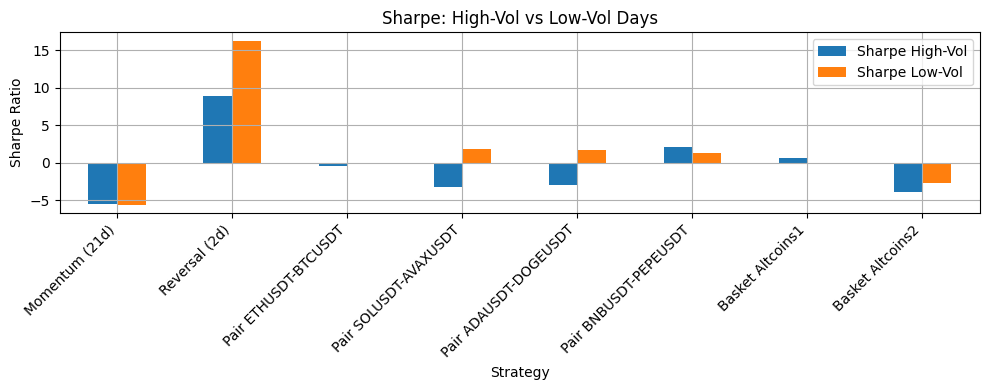

In [27]:
ax = regime_df.plot(kind='bar', title='Sharpe: High-Vol vs Low-Vol Days')
ax.set_ylabel('Sharpe Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
### 15  Test momentum at the **theme** level by grouping coins into logical buckets (e.g., Layer-1s, DeFi).  

Individual Theme Momentum – Long-Only (21-day look-back, 5 bps cost)


AnnReturn    AnnVol    Sharpe  MaxDrawdown     Alpha      Beta  \
Layer1    0.383620  0.414024  0.926563     0.871059  0.000579  0.343849   
DeFi      0.132767  0.724529  0.183245     1.197944 -0.003097  0.447568   
NFT       0.027900  0.843131  0.033090     1.828950 -0.001750  0.381860   
AI_Data   0.204648  0.912218  0.224342     1.028713 -0.001611  0.363296   
Memes     0.700448  1.067114  0.656394     1.178327  0.001438  0.358330   
OG_PoW   -0.061040  0.688065 -0.088713     1.229595 -0.001515  0.576026   

         Alpha t-stat  Beta t-stat  
Layer1       0.771081    10.741106  
DeFi        -1.452467     4.922115  
NFT         -1.053955     5.393866  
AI_Data     -0.966850     5.113053  
Memes        0.813149     4.751296  
OG_PoW      -1.051553     9.375080

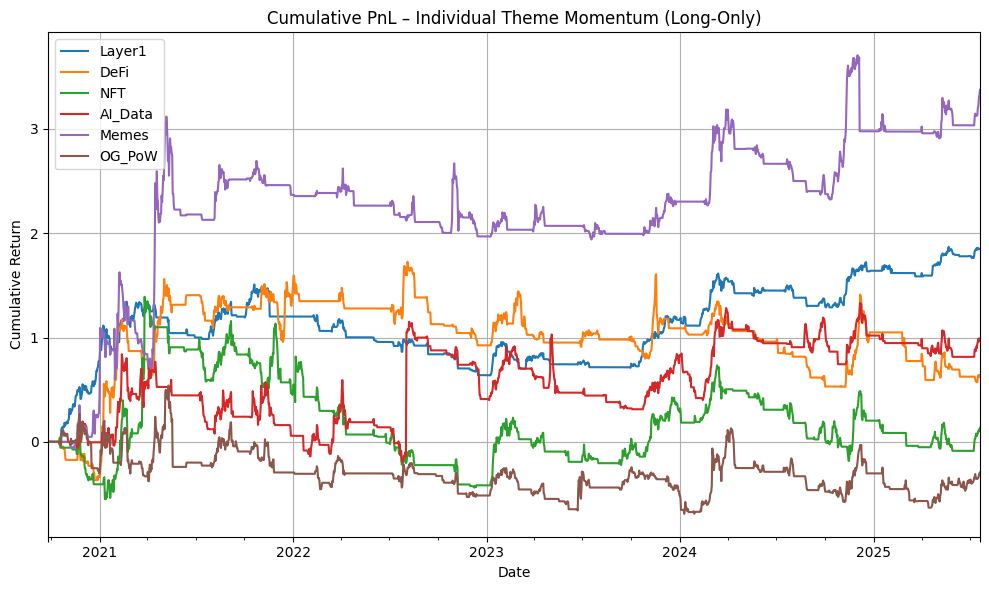

In [28]:
# --- Individual Theme Momentum: full self-contained block ------------------
# --------------------------------------------------------------------------
# 1) THEMES and THEME_PRICES
# --------------------------------------------------------------------------
themes = {
    'Layer1':  ['BTCUSDT','ETHUSDT','BNBUSDT','SOLUSDT','AVAXUSDT','DOTUSDT','ADAUSDT'],
    'DeFi':    ['UNIUSDT','AAVEUSDT','COMPUSDT','SNXUSDT','LINKUSDT','MKRUSDT', 'YFIUSDT','CRVUSDT','BALUSDT','BATUSDT','ZRXUSDT','KNCUSDT'],
    'NFT':     ['MANAUSDT','ENJUSDT','STORJUSDT','LRCUSDT'],    
    'AI_Data': ['FETUSDT','RENDERUSDT','GRTUSDT','AUDIOUSDT','OXTUSDT','RADUSDT','SYSUSDT'],
    'Memes':   ['DOGEUSDT','PEPEUSDT'],
    'OG_PoW':  ['BCHUSDT','LTCUSDT','DASHUSDT','ZECUSDT','DGBUSDT','RVNUSDT', 'QTUMUSDT','ZENUSDT']
}

# keep only symbols we actually have in prices
themes = {name: [s for s in syms if s in prices.columns] 
          for name, syms in themes.items() if len([s for s in syms if s in prices.columns]) >= 2}

# Build equal-weight theme price series
theme_prices = pd.DataFrame({
    name: prices[syms].mean(axis=1) for name, syms in themes.items()
}).dropna(how='any')

# Theme log-returns
theme_rets = np.log(theme_prices / theme_prices.shift(1)).dropna()

# --------------------------------------------------------------------------
# 2) LONG-ONLY MOMENTUM BACK-TEST
# --------------------------------------------------------------------------
def long_only_backtest(signal: pd.Series, ret: pd.Series, cost_bps: float = 5):
    """
    Simple long-only back-tester: hold 1 when `signal` == 1, else 0.
    Signal and ret must have the same index.
    """
    pos = signal.shift(1).fillna(0)          # enter at next bar
    pnl = pos * ret
    turnover = signal.diff().abs()           # 0→1 or 1→0
    pnl -= turnover * cost_bps / 1e4
    return pnl

lookback = 21
# raw 21-day momentum (sum of returns)
raw_mom = theme_rets.rolling(lookback).sum()

# z-score of raw momentum PER THEME (column-wise)
mom_z = (raw_mom - raw_mom.mean()) / raw_mom.std()

theme_pnls = {}
for theme in mom_z.columns:
    sig = (mom_z[theme] > 0).astype(int)            # long when z > 0
    theme_pnls[theme] = long_only_backtest(sig, theme_rets[theme])

# --------------------------------------------------------------------------
# 3) PERFORMANCE TABLE
# --------------------------------------------------------------------------
rows = []
for theme, pnl in theme_pnls.items():
    ann_ret = pnl.mean() * 365
    ann_vol = pnl.std()  * np.sqrt(365)
    sharpe  = ann_ret / ann_vol if ann_vol else np.nan
    max_dd  = (pnl.cumsum().cummax() - pnl.cumsum()).max()
    
    # alpha / beta vs BTC
    df_reg = pd.DataFrame({'pnl': pnl, 'btc_ret': rets['BTCUSDT']}).dropna()
    mdl    = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    
    rows.append(pd.Series({
        'AnnReturn':   ann_ret,
        'AnnVol':      ann_vol,
        'Sharpe':      sharpe,
        'MaxDrawdown': max_dd,
        'Alpha':       mdl.params['const'],
        'Beta':        mdl.params['btc_ret'],
        'Alpha t-stat':mdl.tvalues['const'],
        'Beta t-stat': mdl.tvalues['btc_ret']
    }, name=theme))

theme_perf = pd.DataFrame(rows)
print("Individual Theme Momentum – Long-Only (21-day look-back, 5 bps cost)")
display(theme_perf)

# --------------------------------------------------------------------------
# 4) CUMULATIVE PnL PLOT
# --------------------------------------------------------------------------
plt.figure(figsize=(10,6))
for theme, pnl in theme_pnls.items():
    pnl.cumsum().plot(label=theme)
plt.title('Cumulative PnL – Individual Theme Momentum (Long-Only)')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


---
## 16  Intraday Technical Play: Front-Run Volume Spikes

AnnReturn    AnnVol    Sharpe  MaxDrawdown     Alpha      Beta
BTCUSDT    0.087509  0.209987  0.416734     0.538040  0.000277  0.120629
BCHUSDT    0.056439  0.311976  0.180908     0.937270  0.000240  0.099237
BNBUSDT   -0.019075  0.237823 -0.080207     0.507287 -0.000696  0.115975
SOLUSDT   -0.070504  0.392183 -0.179774     0.729657 -0.001228  0.224412
XRPUSDT    0.240387  0.310103  0.775184     0.333131  0.001214  0.112776
...             ...       ...       ...          ...       ...       ...
ZILUSDT    0.039562  0.477638  0.082829     0.749228 -0.003113  0.181758
XTZUSDT    0.195493  0.369857  0.528562     0.462585  0.000223  0.110511
ANKRUSDT   0.136891  0.405695  0.337423     0.339297 -0.000428  0.030339
ONEUSDT    0.167487  0.542147  0.308932     1.082033  0.002429  0.222163
KSMUSDT   -0.108693  0.446777 -0.243282     0.805618 -0.000042  0.103373

[61 rows x 6 columns]

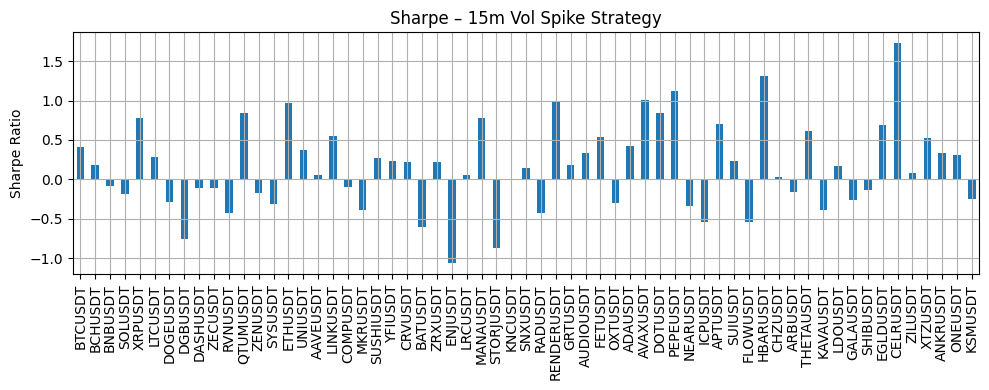

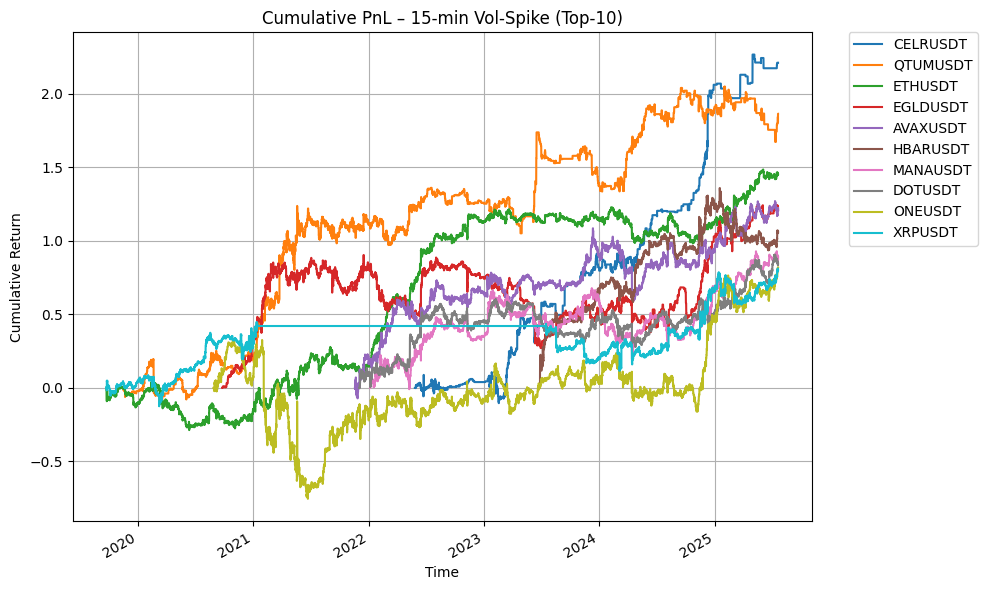

In [29]:
# 1) Define symbols and parameters
symbols = UNIVERSE
days_back = 30
lookback_bars = 24  # for 90th percentile (~6 hours)
metrics = {}
pnl_series = {}

# 2) Loop through each symbol
for sym in symbols:
    # fetch 15-min OHLCV
    start = (pd.Timestamp.utcnow() - pd.Timedelta(days=days_back)).strftime("%d %b %Y %H:%M:%S")
    df = get_px(sym, interval='15m', start=0)
    
    # volume spike detection
    df['q90'] = df['vol'].rolling(lookback_bars).quantile(0.9)
    df['spike'] = df['vol'] > df['q90']
    
    # work hours mask (13–21 UTC)
    df['hour'] = df.index.hour
    df['is_work'] = df['hour'].between(13, 21)
    
    # signal: next bar after spike during work hours, flat at UTC midnight
    df['signal'] = (df['spike'] & df['is_work']).shift(1).fillna(0).astype(int)
    df['date'] = df.index.date
    df['signal'] = np.where(df['date'] != df['date'].shift(-1), 0, df['signal'])
    
    # compute 15-min log returns
    df['ret15'] = np.log(df['close'] / df['close'].shift(1))
    
    # long-only backtest
    df['pos'] = df['signal'].shift(1).fillna(0)
    df['pnl'] = df['pos'] * df['ret15']
    pnl = df['pnl'].dropna()
    pnl_series[sym] = pnl.cumsum()
    
    # performance metrics
    bars_per_year = 365 * 24 * 4
    ann_ret = pnl.mean() * bars_per_year
    ann_vol = pnl.std() * np.sqrt(bars_per_year)
    sharpe  = ann_ret / ann_vol if ann_vol else np.nan
    maxdd   = (pnl.cumsum().cummax() - pnl.cumsum()).max()
    
    # daily regression vs BTC
    pnl_daily = pnl.resample('D').sum()
    btc_daily = rets['BTCUSDT'].resample('D').sum()
    df_reg = pd.concat([pnl_daily, btc_daily], axis=1, keys=['pnl','btc_ret']).dropna()
    model = sm.OLS(df_reg['pnl'], sm.add_constant(df_reg['btc_ret'])).fit()
    
    metrics[sym] = {
        'AnnReturn':   ann_ret,
        'AnnVol':      ann_vol,
        'Sharpe':      sharpe,
        'MaxDrawdown': maxdd,
        'Alpha':       model.params['const'],
        'Beta':        model.params['btc_ret']
    }

# 3) Display metrics
metrics_df = pd.DataFrame(metrics).T
display(metrics_df)

# 4) Plot Sharpe ratios
metrics_df['Sharpe'].plot(kind='bar', title='Sharpe – 15m Vol Spike Strategy')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

# 5) Overlay cumulative PnL – TOP-10 only
plt.figure(figsize=(10,6))

# --- pick the 10 symbols whose cumulative PnL ends highest --------------
top10 = sorted(
    pnl_series.items(),
    key=lambda kv: kv[1].iloc[-1],        # sort by final cumulative value
    reverse=True
)[:10]                                      # keep best five

for sym, pnl_cum in top10:
    pnl_cum.plot(label=sym)

plt.title('Cumulative PnL – 15-min Vol-Spike (Top-10)')
plt.xlabel('Time'); plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True); plt.tight_layout(); plt.show()

Processing BTCUSDT...
Processing BCHUSDT...
Processing BNBUSDT...
Processing SOLUSDT...
Processing XRPUSDT...
Processing LTCUSDT...
Processing DOGEUSDT...
Processing DGBUSDT...
Processing DASHUSDT...
Processing ZECUSDT...
Processing RVNUSDT...
Processing QTUMUSDT...
Processing ZENUSDT...
Processing SYSUSDT...
Processing ETHUSDT...
Processing UNIUSDT...
Processing AAVEUSDT...
Processing LINKUSDT...
Processing COMPUSDT...
Processing MKRUSDT...
Processing SUSHIUSDT...
Processing YFIUSDT...
Processing CRVUSDT...
Processing BATUSDT...
Processing ZRXUSDT...
Processing ENJUSDT...
Processing LRCUSDT...
Processing MANAUSDT...
Processing STORJUSDT...
Processing KNCUSDT...
Processing SNXUSDT...
Processing RADUSDT...
Processing RENDERUSDT...
Processing GRTUSDT...
Processing AUDIOUSDT...
Processing FETUSDT...
Processing OXTUSDT...
Processing ADAUSDT...
Processing AVAXUSDT...
Processing DOTUSDT...
Processing PEPEUSDT...
Processing NEARUSDT...
Processing ICPUSDT...
Processing APTUSDT...
Processing SU

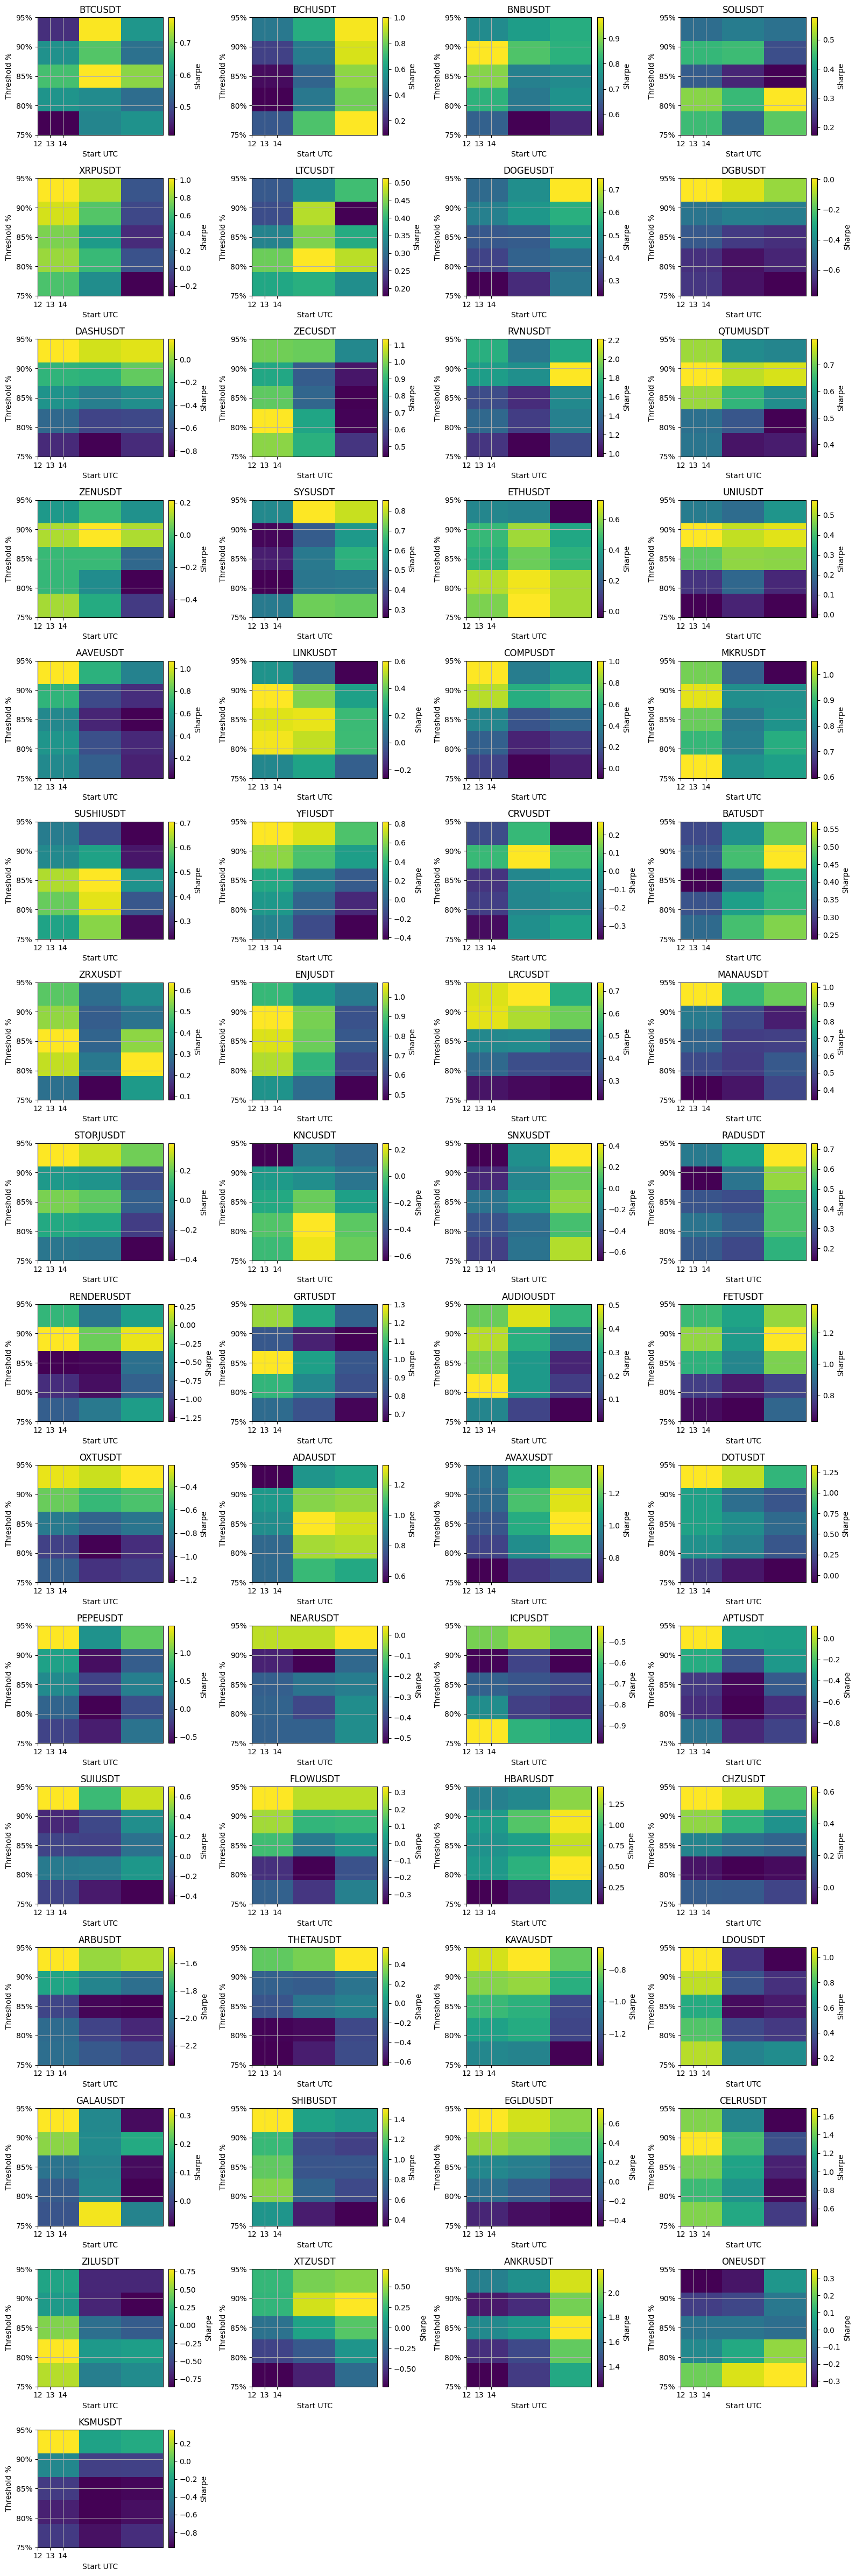

In [30]:
# --- Parameter Sweep Across Multiple Symbols: Intraday Technical Play ---
symbols = UNIVERSE
days_back = 360
lookback_bars = 24
thresholds = [0.75, 0.80, 0.85, 0.90, 0.95]
start_hours = [12, 13, 14]

# Container for heatmaps per symbol
heatmaps = {}

for sym in symbols:
    print(f"Processing {sym}...")
    # Fetch 15-min data
    start = (pd.Timestamp.utcnow() - pd.Timedelta(days=days_back)).strftime("%d %b %Y %H:%M:%S")
    df = get_px(sym, interval='15m', start=0)
    df = df[['close','vol']].dropna(how='any')
    df['ret15'] = np.log(df['close'] / df['close'].shift(1))
    
    # Pre-allocate results DataFrame
    res = pd.DataFrame(index=thresholds, columns=start_hours, dtype=float)
    
    for q in thresholds:
        # compute rolling quantile for this threshold
        df['qth'] = df['vol'].rolling(lookback_bars).quantile(q)
        for start in start_hours:
            end = start + 8
            # build signal
            hour = df.index.hour
            sig = ((df['vol'] > df['qth']) & (hour >= start) & (hour < end)).shift(1).fillna(0).astype(int)
            # reset at midnight
            dates = df.index.date
            sig = np.where(dates != np.roll(dates, -1), 0, sig)
            # compute pnl
            pnl = sig * df['ret15']
            pnl = pnl.dropna()
            # annualized Sharpe
            bars_per_year = 365 * 24 * 4
            ann_ret = pnl.mean() * bars_per_year
            ann_vol = pnl.std() * np.sqrt(bars_per_year)
            sharpe = ann_ret / ann_vol if ann_vol else np.nan
            res.loc[q, start] = sharpe
    
    heatmaps[sym] = res

# Plot heatmaps
n = len(symbols)
cols = 4
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), squeeze=False)

for idx, sym in enumerate(symbols):
    r = idx // cols
    c = idx % cols
    ax = axes[r][c]
    hm = heatmaps[sym].values.astype(float)
    im = ax.imshow(hm, origin='lower', aspect='auto',
                   extent=[min(start_hours), max(start_hours)+8,
                           min(thresholds)*100, max(thresholds)*100])
    ax.set_title(sym)
    ax.set_xlabel('Start UTC')
    ax.set_ylabel('Threshold %')
    ax.set_xticks(start_hours)
    ax.set_yticks([t*100 for t in thresholds])
    ax.set_yticklabels([f"{int(t*100)}%" for t in thresholds])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Sharpe')

# Hide empty subplots
for j in range(idx+1, rows*cols):
    fig.delaxes(axes[j//cols][j%cols])

fig.tight_layout()
plt.show()


---
## 17  Execution Cost Comparison: Market vs. Limit Orders

We’ll re-run two of our flagship strategies—daily 21-day momentum and the 15-min intraday spike play—under two execution cost regimes:

- **Market orders**: 20 bps total round-trip cost  
- **Limit orders**: 7 bps commission, zero slippage  

We’ll compare their net PnL, turnover, and key stats side-by-side.

AnnReturn    AnnVol     Sharpe  MaxDrawdown
Symbol   Order                                              
BTCUSDT  Market  -5.145029  0.145832 -35.280587     0.426844
         Limit   -1.478304  0.117327 -12.599811     0.122644
BCHUSDT  Market  -5.451523  0.197490 -27.604004     0.452271
         Limit   -1.878817  0.173795 -10.810560     0.169807
BNBUSDT  Market  -5.638366  0.137276 -41.073156     0.467772
...                    ...       ...        ...          ...
ANKRUSDT Limit   -0.266790  0.169536  -1.573652     0.051800
ONEUSDT  Market  -3.757753  0.324131 -11.593299     0.333577
         Limit    0.065669  0.317766   0.206660     0.122003
KSMUSDT  Market  -4.255791  0.249079 -17.086086     0.353070
         Limit   -1.842648  0.233516  -7.890868     0.152870

[122 rows x 4 columns]

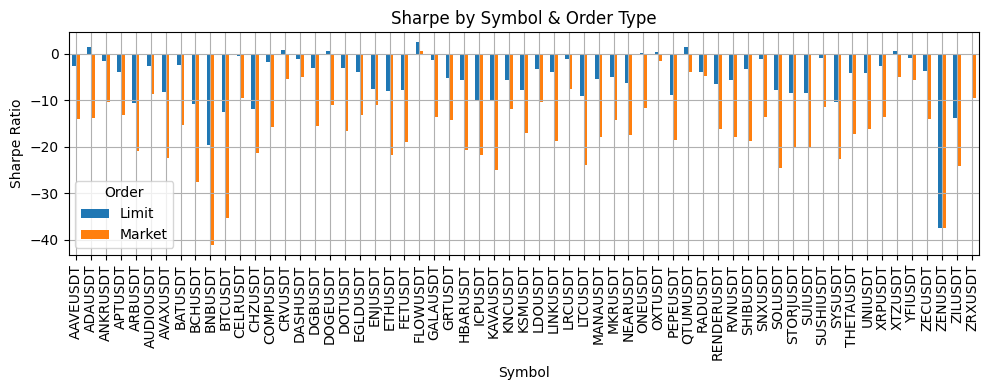

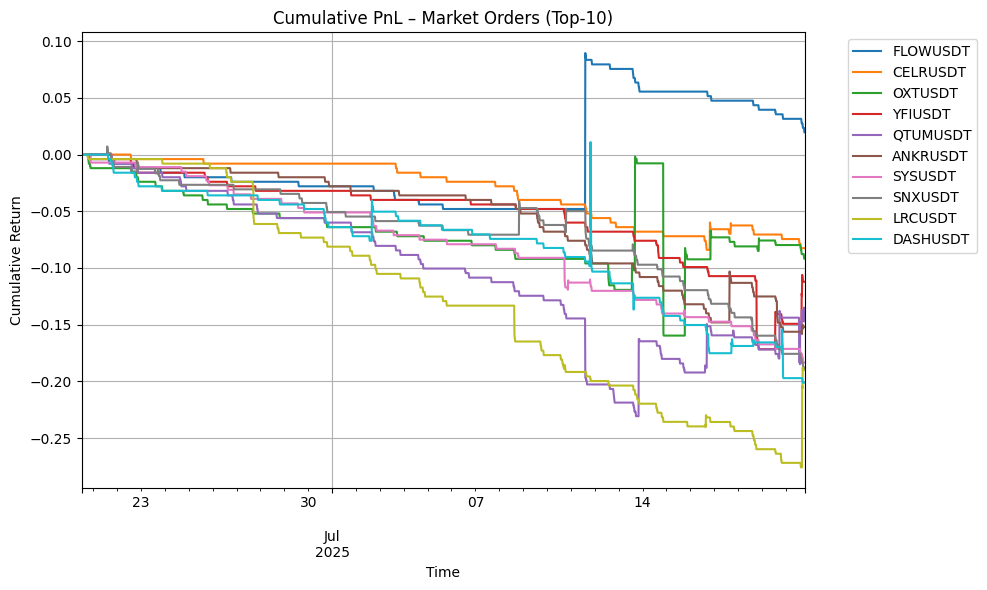

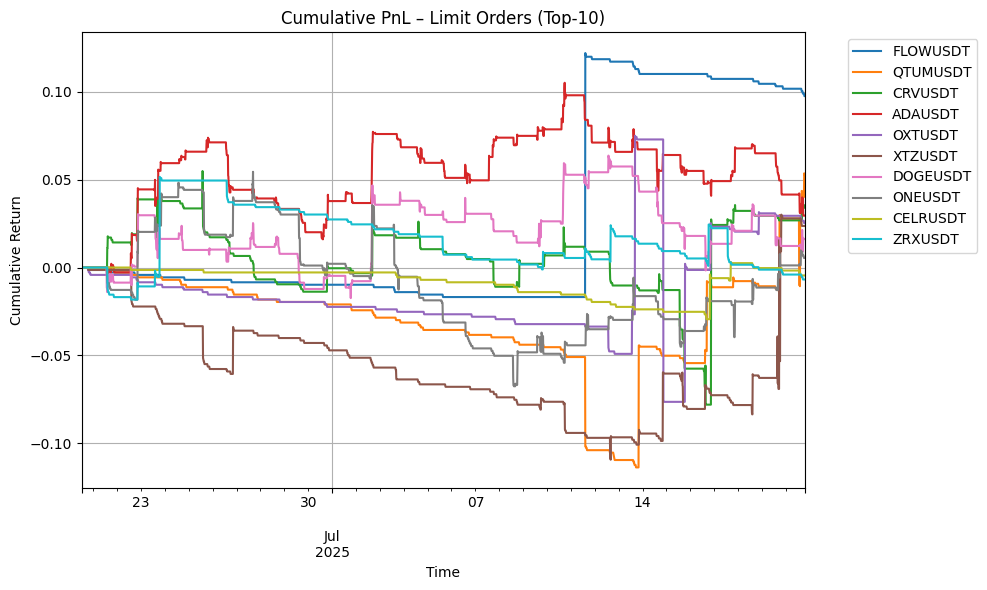

In [31]:
# 1) Define symbols and parameters
symbols = UNIVERSE
lookback_bars = 24  # for 6-hour volume spikes

# 2) Containers for metrics and PnL
metrics = []
pnl_data = {}
start_time = datetime.now() - timedelta(days=30)

# 3) Loop over each symbol
for sym in symbols:
    # fetch data
    df = get_px(sym, interval='15m', start=str(start_time)).dropna()
    df['ret15'] = np.log(df['close'] / df['close'].shift(1))
    # compute spike
    df['q90'] = df['vol'].rolling(lookback_bars).quantile(0.9)
    df['spike'] = df['vol'] > df['q90']
    # work-hour mask
    hr = df.index.hour
    work = (hr >= 13) & (hr < 21)
    # signal
    df['signal'] = (df['spike'] & work).shift(1).fillna(0).astype(int)
    dates = df.index.date
    df['signal'] = np.where(dates != np.roll(dates, -1), 0, df['signal'])
    # evaluate costs
    for cost_bps, order_type in [(20, 'Market'), (7, 'Limit')]:
        pos = df['signal'].shift(1).fillna(0)
        pnl = pos * df['ret15']
        turn = pos.diff().abs()
        pnl_net = pnl - turn * (cost_bps/1e4)
        # store cumulative series
        pnl_data[(sym, order_type)] = pnl_net.cumsum()
        # metrics
        bars_per_year = 365 * 24 * 4
        ann_ret = pnl_net.mean() * bars_per_year
        ann_vol = pnl_net.std()  * np.sqrt(bars_per_year)
        sharpe  = ann_ret / ann_vol if ann_vol else np.nan
        max_dd  = (pnl_net.cumsum().cummax() - pnl_net.cumsum()).max()
        metrics.append({
            'Symbol': sym,
            'Order': order_type,
            'AnnReturn': ann_ret,
            'AnnVol': ann_vol,
            'Sharpe': sharpe,
            'MaxDrawdown': max_dd
        })

# 4) Build metrics DataFrame
metrics_df = pd.DataFrame(metrics).set_index(['Symbol','Order'])
display(metrics_df)

# 5) Bar chart of Sharpe ratios
metrics_df['Sharpe'].unstack().plot(kind='bar', title='Sharpe by Symbol & Order Type')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.show()

# 6) Cumulative PnL – Market orders (TOP-10)
plt.figure(figsize=(10,6))

# pick top-10 by final cumulative value
top10_mkt = sorted(
    [(sym, pnl_data[(sym,'Market')]) for sym in symbols],
    key=lambda kv: kv[1].iloc[-1],     # sort by last value
    reverse=True
)[:10]

for sym, pnl_cum in top10_mkt:
    pnl_cum.plot(label=sym)

plt.title('Cumulative PnL – Market Orders (Top-10)')
plt.xlabel('Time'); plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True); plt.tight_layout(); plt.show()


# 7) Cumulative PnL – Limit orders (TOP-10)
plt.figure(figsize=(10,6))

top10_lim = sorted(
    [(sym, pnl_data[(sym,'Limit')]) for sym in symbols],
    key=lambda kv: kv[1].iloc[-1],
    reverse=True
)[:10]

for sym, pnl_cum in top10_lim:
    pnl_cum.plot(label=sym)

plt.title('Cumulative PnL – Limit Orders (Top-10)')
plt.xlabel('Time'); plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True); plt.tight_layout(); plt.show()

---
## 18  Macro Regime Reversal Strategy 
Tests whether short-horizon reversal works better during “turbulent / dislocated” crypto markets, measured via:
  - Realized volatility of BTC   (21-day std)
  - Cross-section return dispersion
  - Average pairwise correlation (21-day window)
  - Optional: Implied volatility series `impl_vol`
  
For each coin and each look-back window, we compute reversal PnL and compare
Sharpe in High vs Low macro regimes (split at median of each indicator).
A grid of bar-charts is produced for every coin × indicator × look-back combo.
───────────────────────────────────────────────────────────────────────────────

Sharpe by Symbol × Lookback × Indicator (High vs Low)
Regime                               High       Low
Symbol     Lookback Indicator                      
AAVEUSDT   1        AvgPairCorr  0.402607 -0.667213
                    Dispersion  -0.165589 -0.927141
                    RealizedVol -0.247955  0.050296
           2        AvgPairCorr  2.562095  3.524055
                    Dispersion   4.608578  0.716293
                    RealizedVol  3.199704  2.901610
           3        AvgPairCorr  1.452984 -1.196640
                    Dispersion  -0.378313  0.561097
                    RealizedVol  0.534781 -0.376258
           5        AvgPairCorr  2.095093 -0.323750
                    Dispersion   1.072446 -0.285152
                    RealizedVol  0.202139  1.922388
ADAUSDT    1        AvgPairCorr -0.285440 -1.968131
                    Dispersion  -1.454920 -2.144847
                    RealizedVol -0.908929 -2.116276
           2        AvgPairCorr  0.264149 -1.181179
          

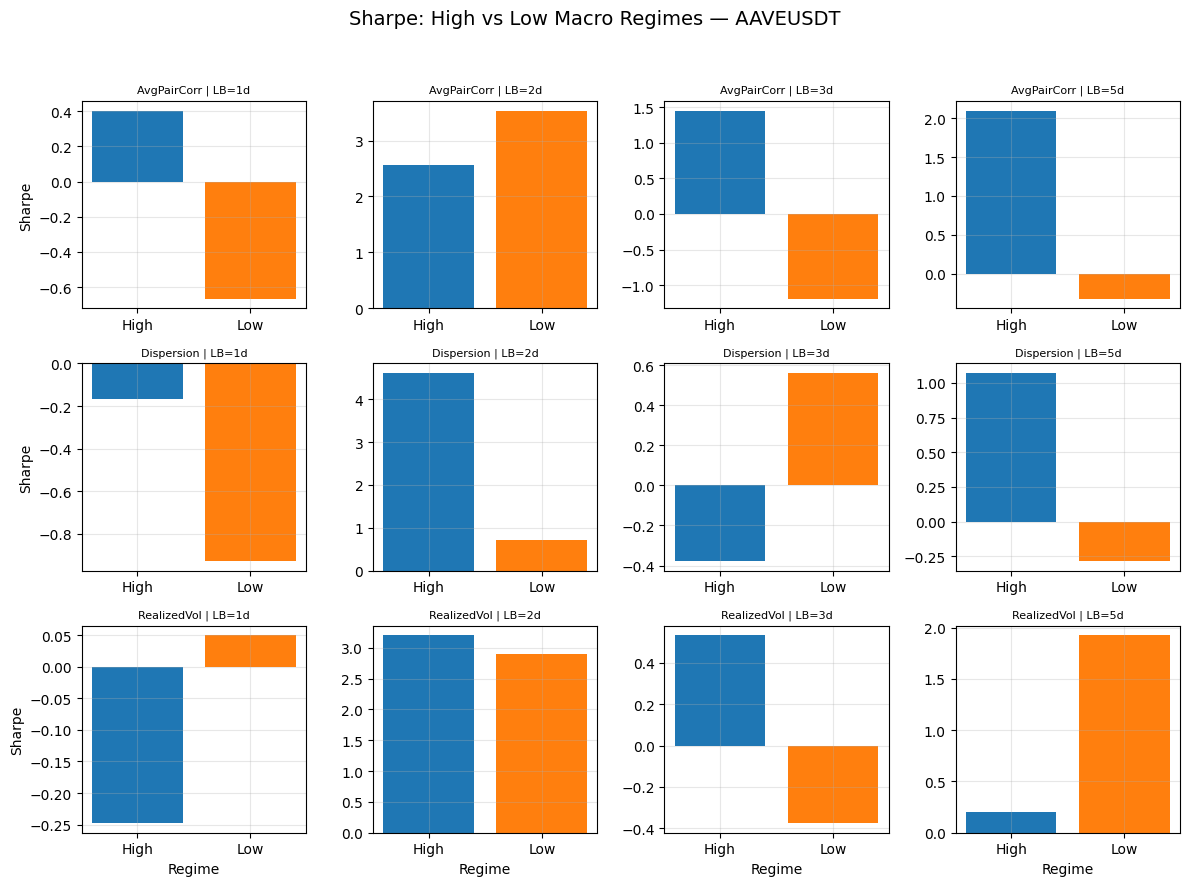

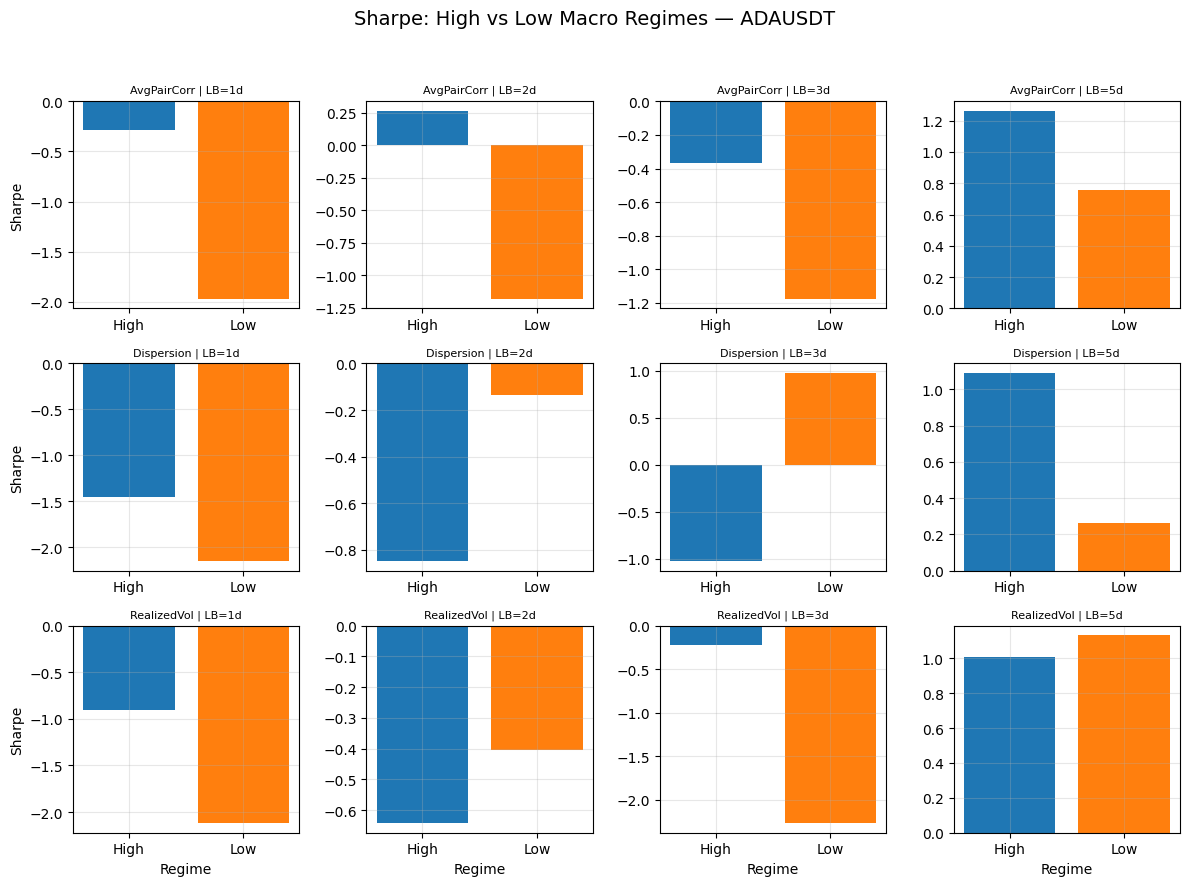

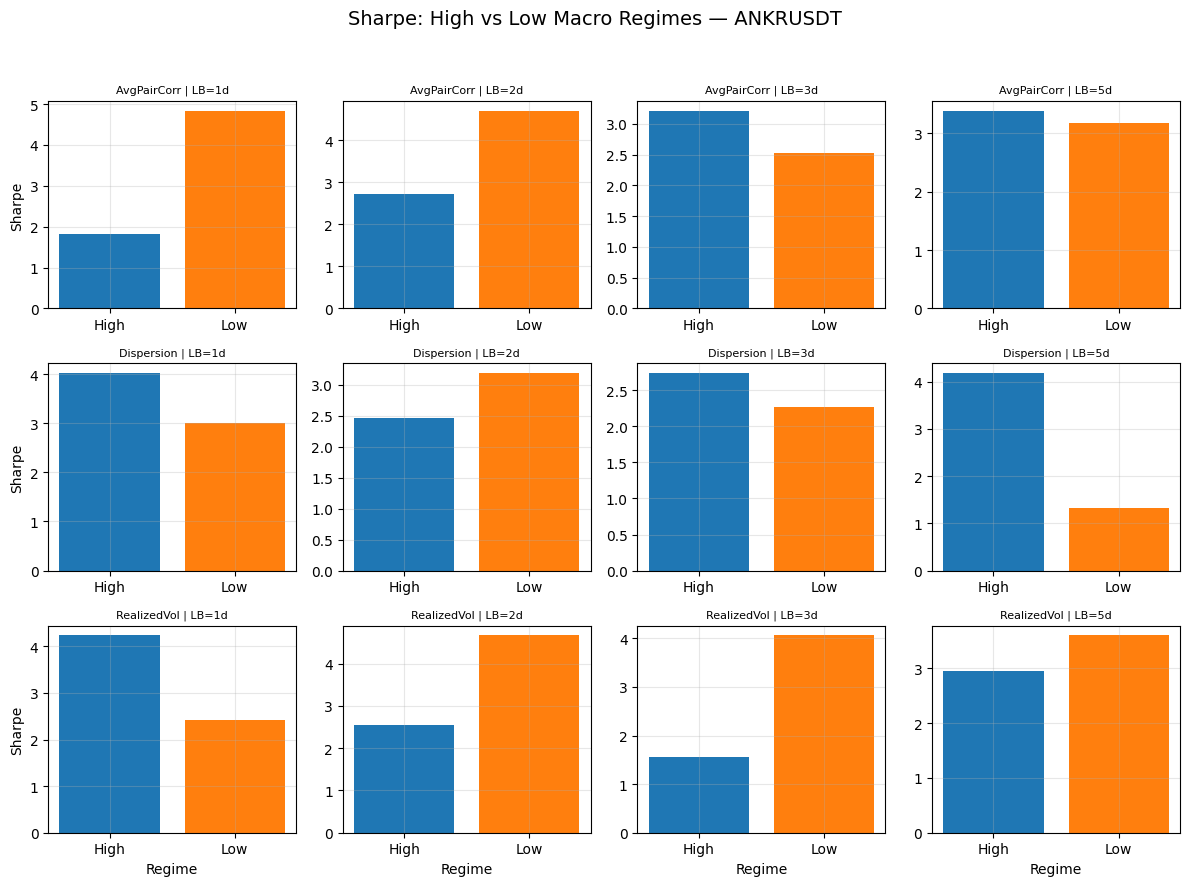

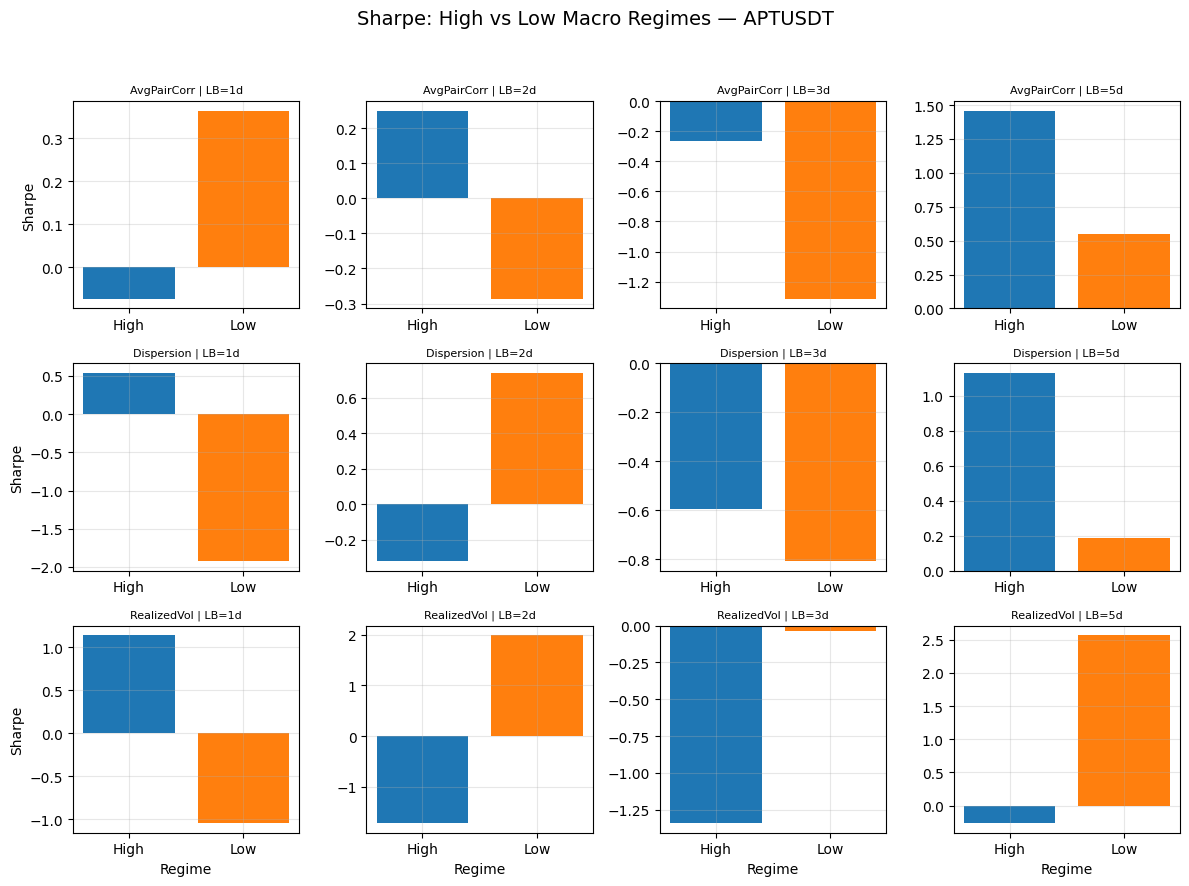

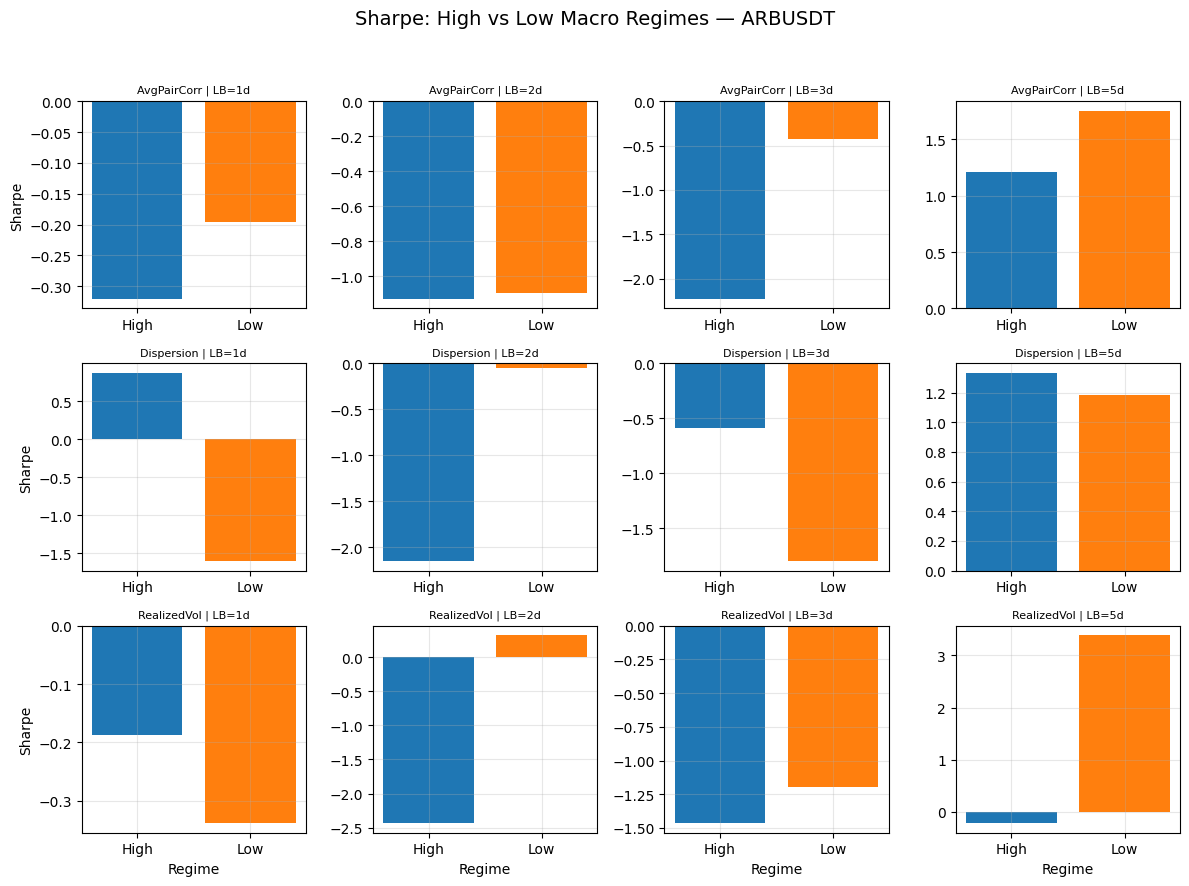

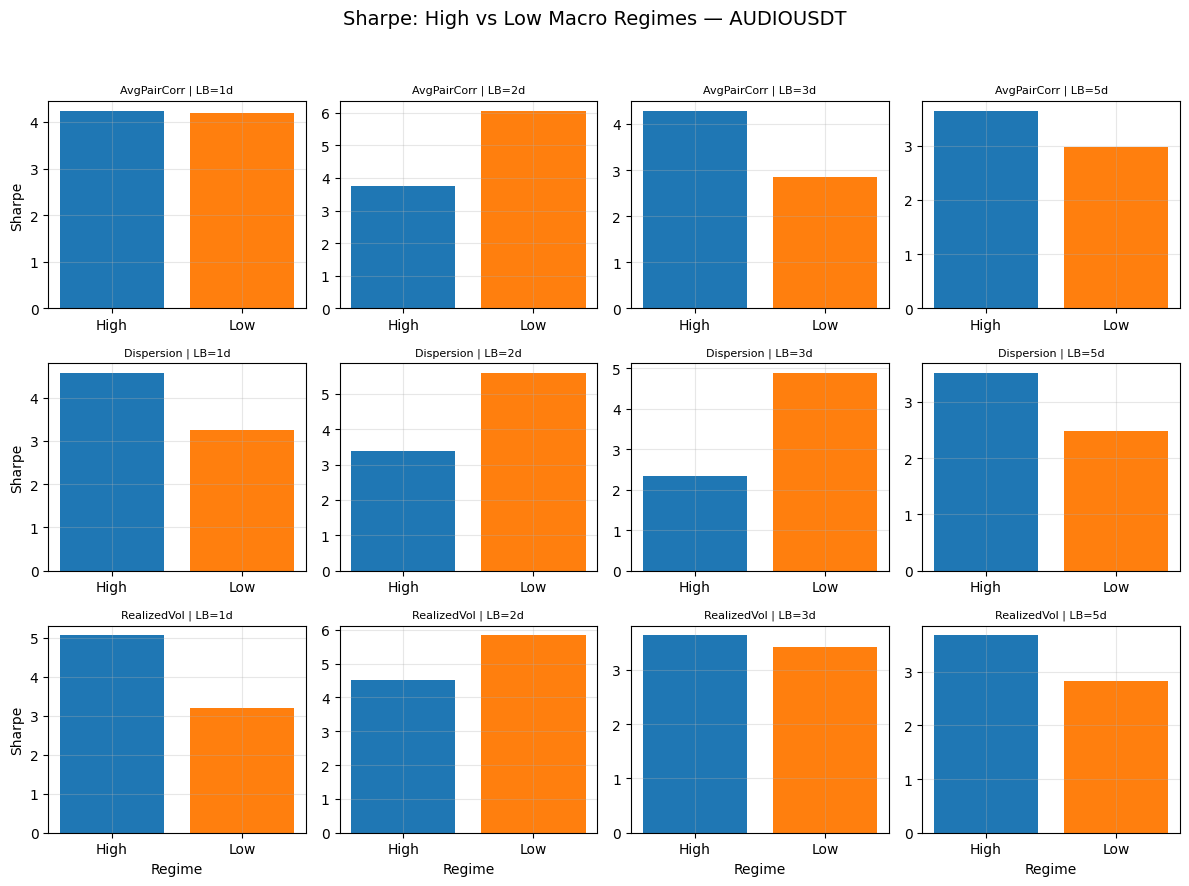

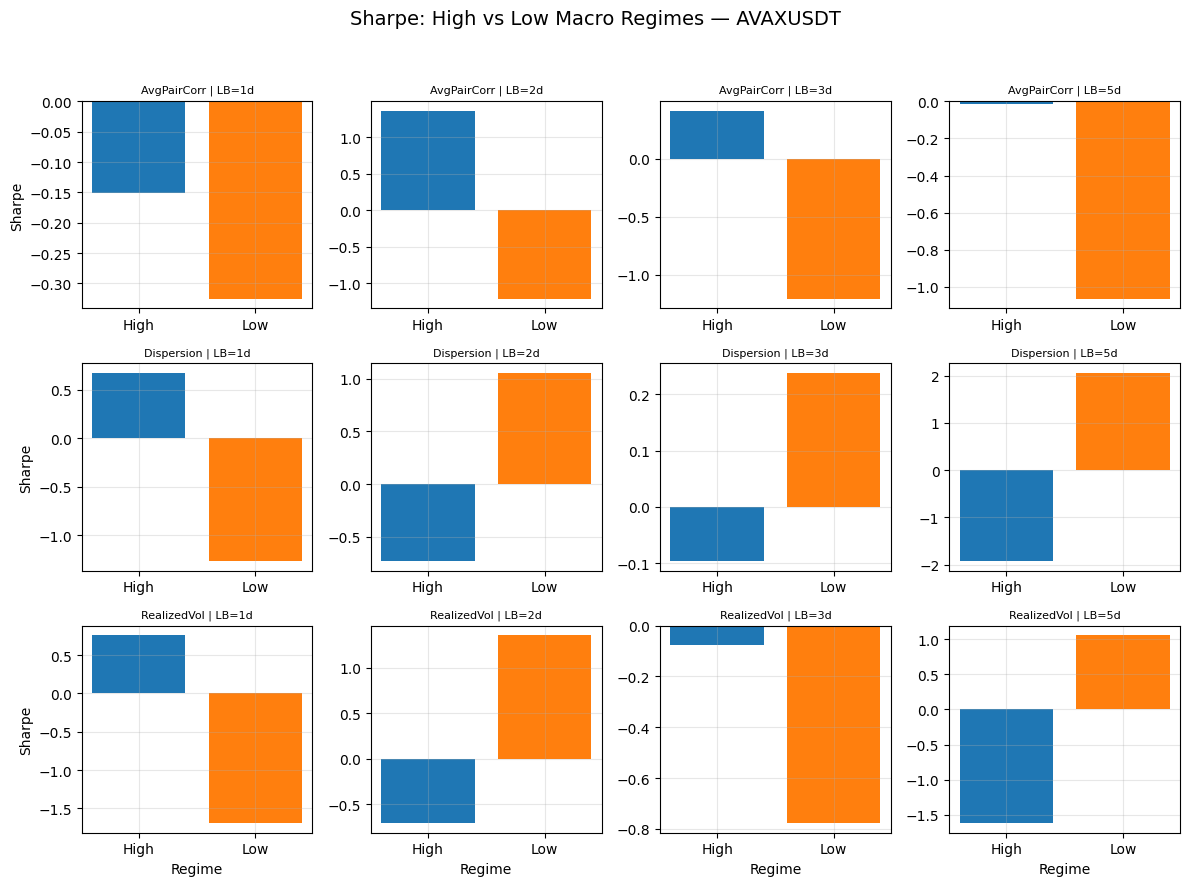

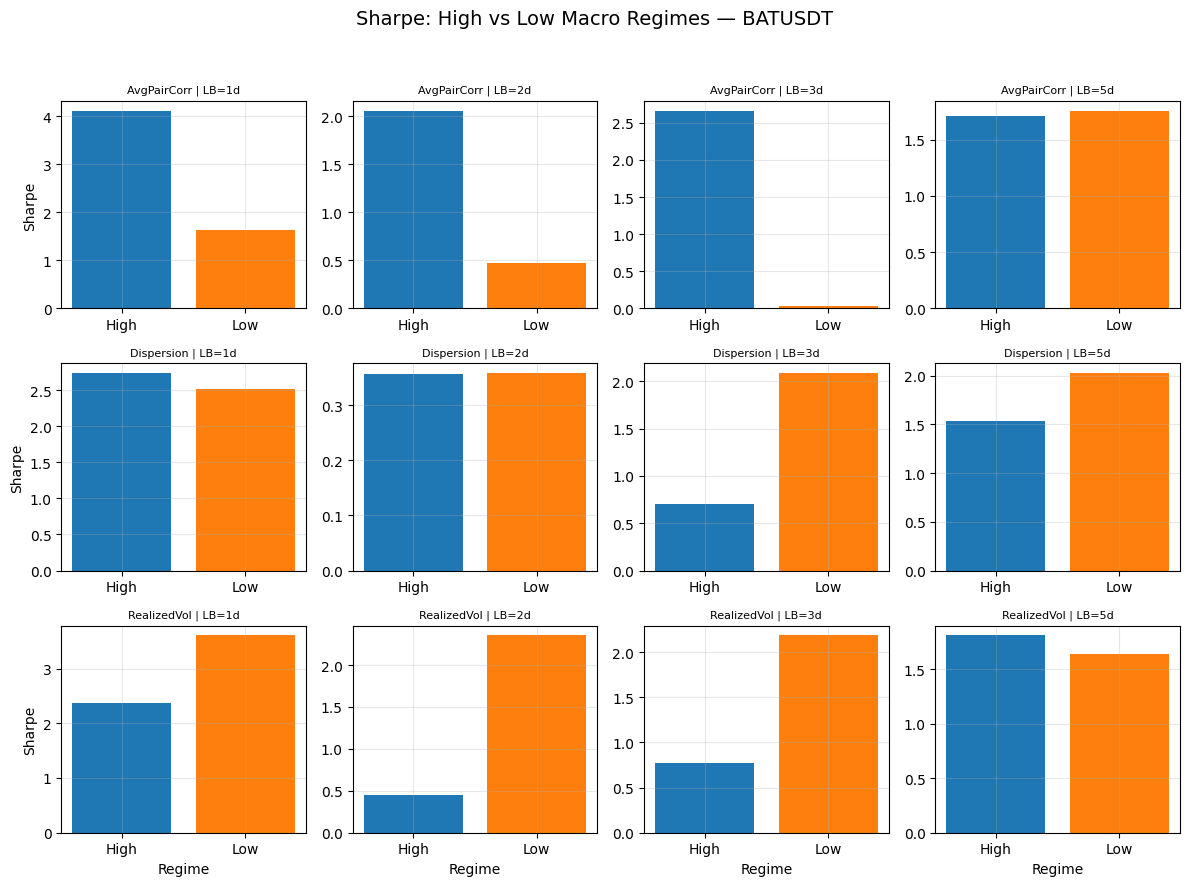

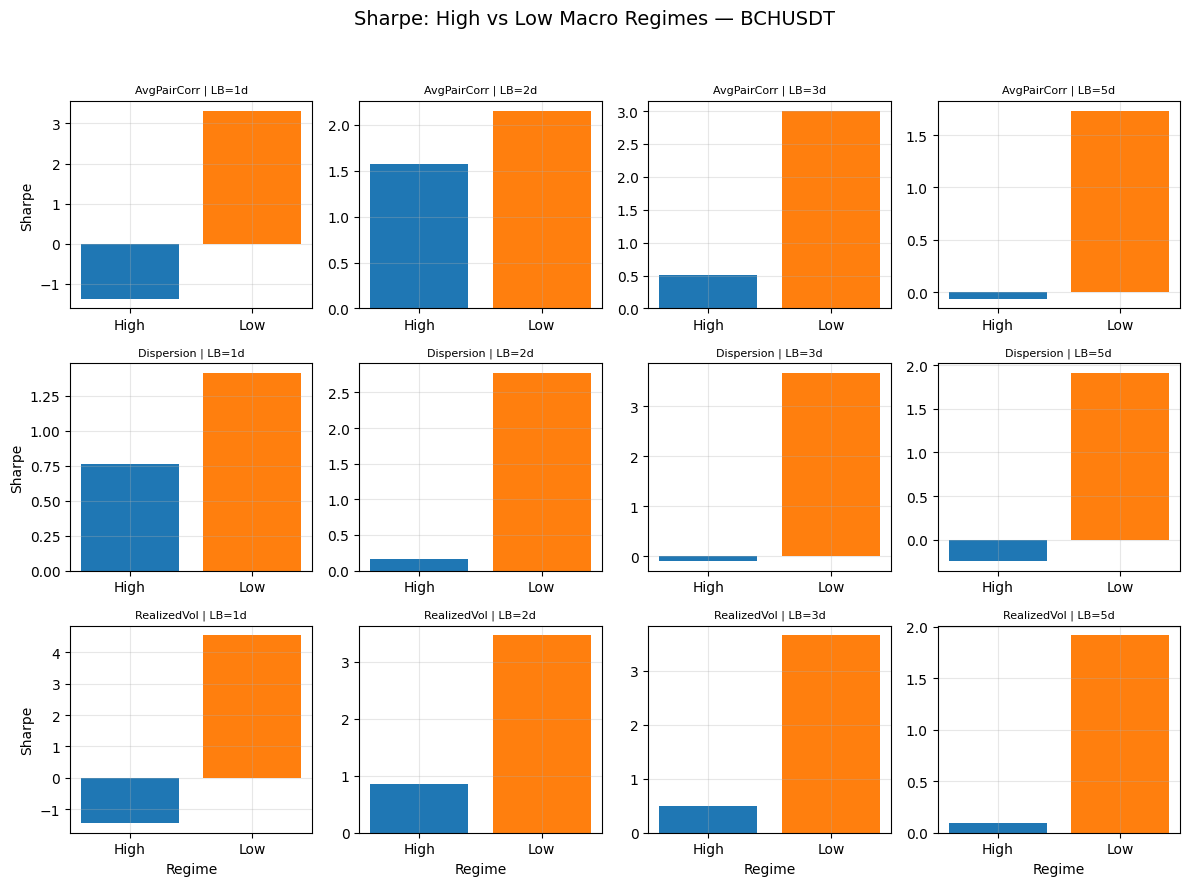

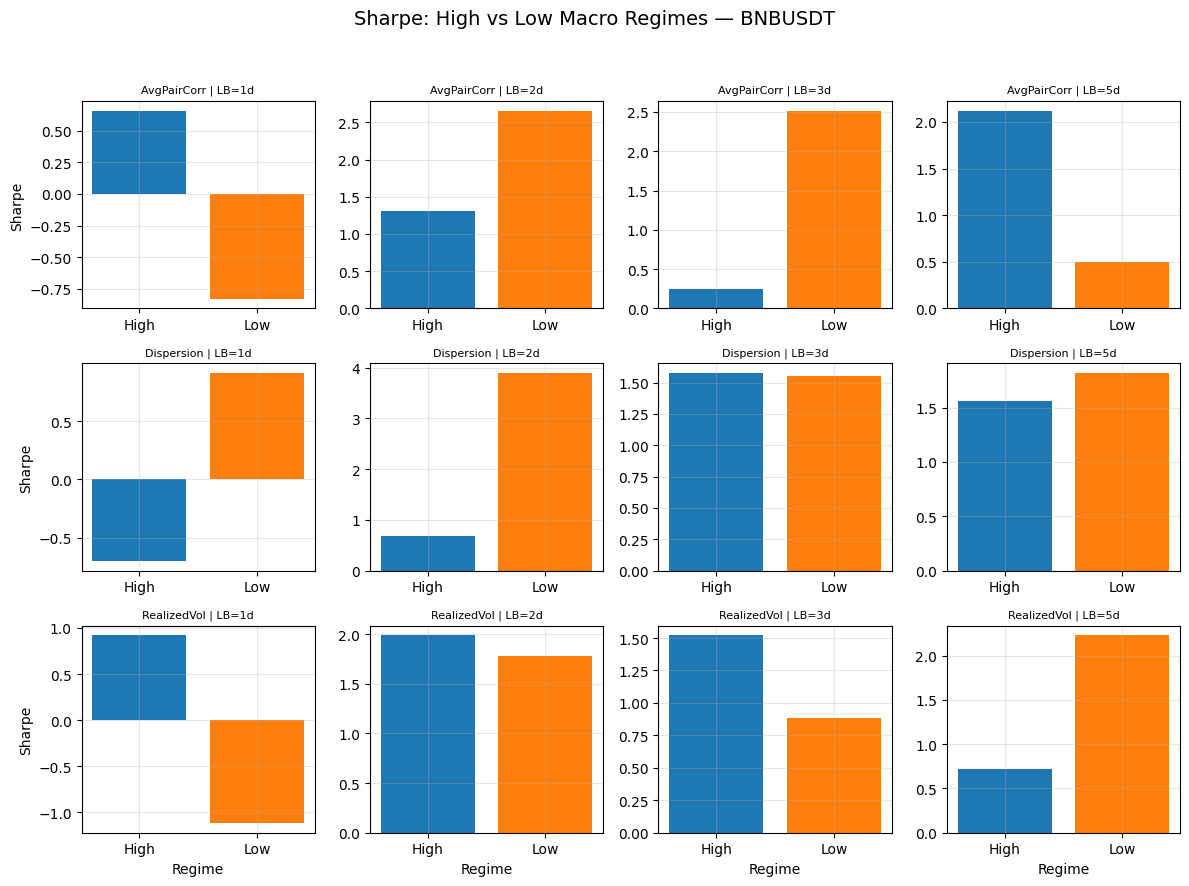

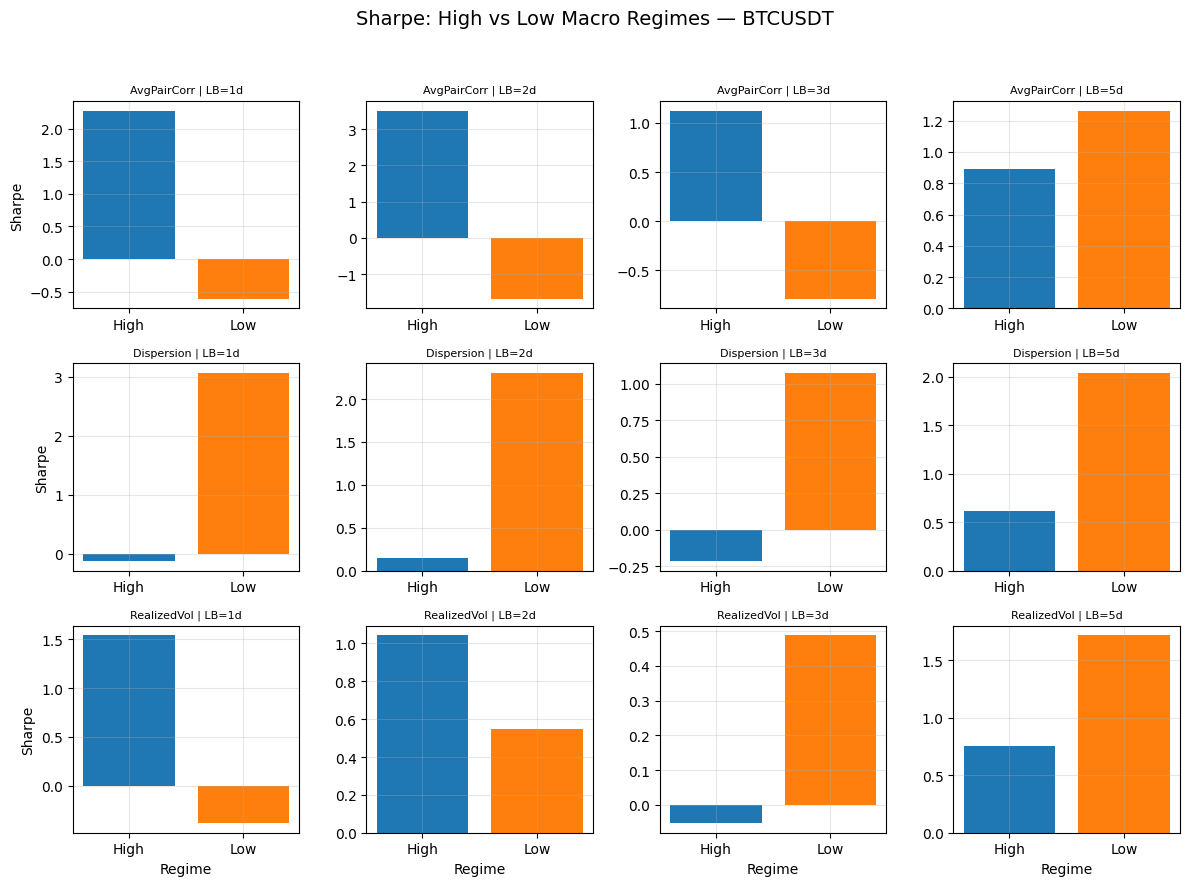

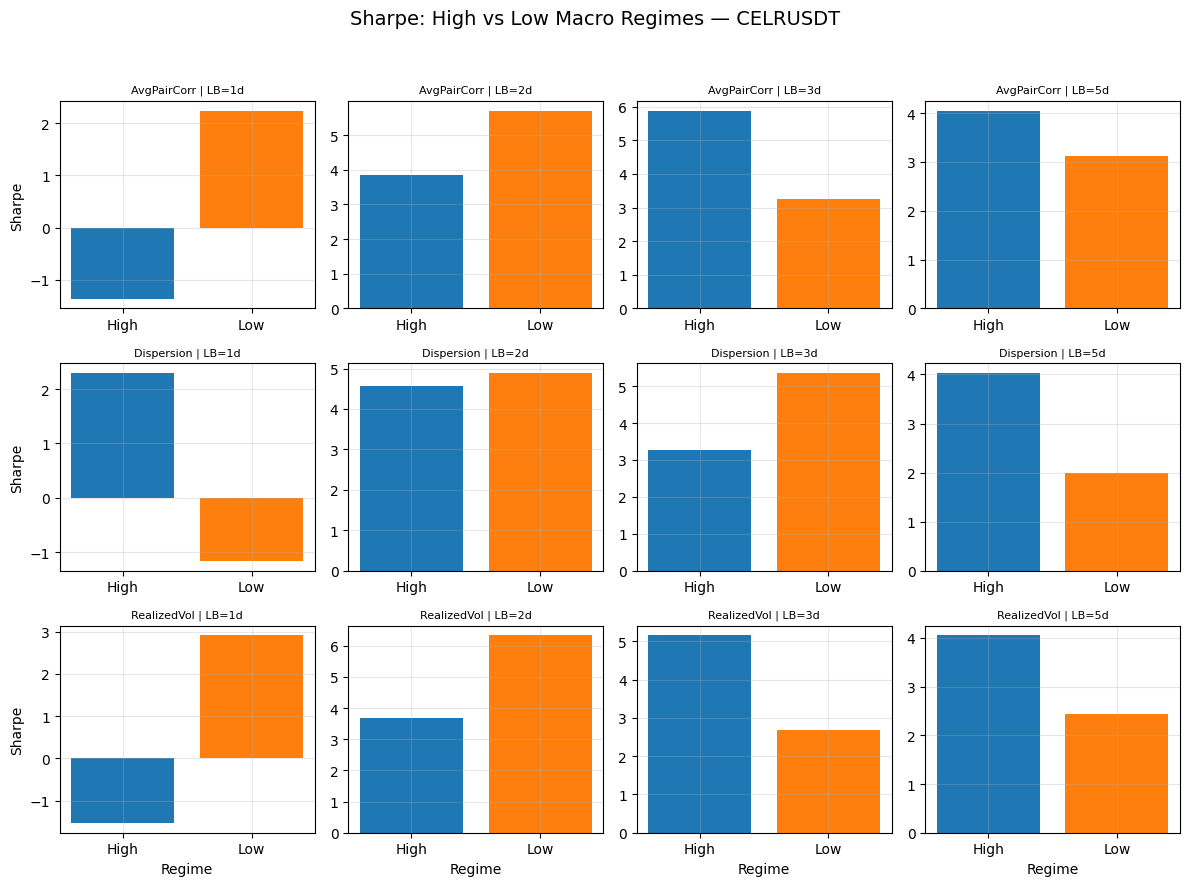

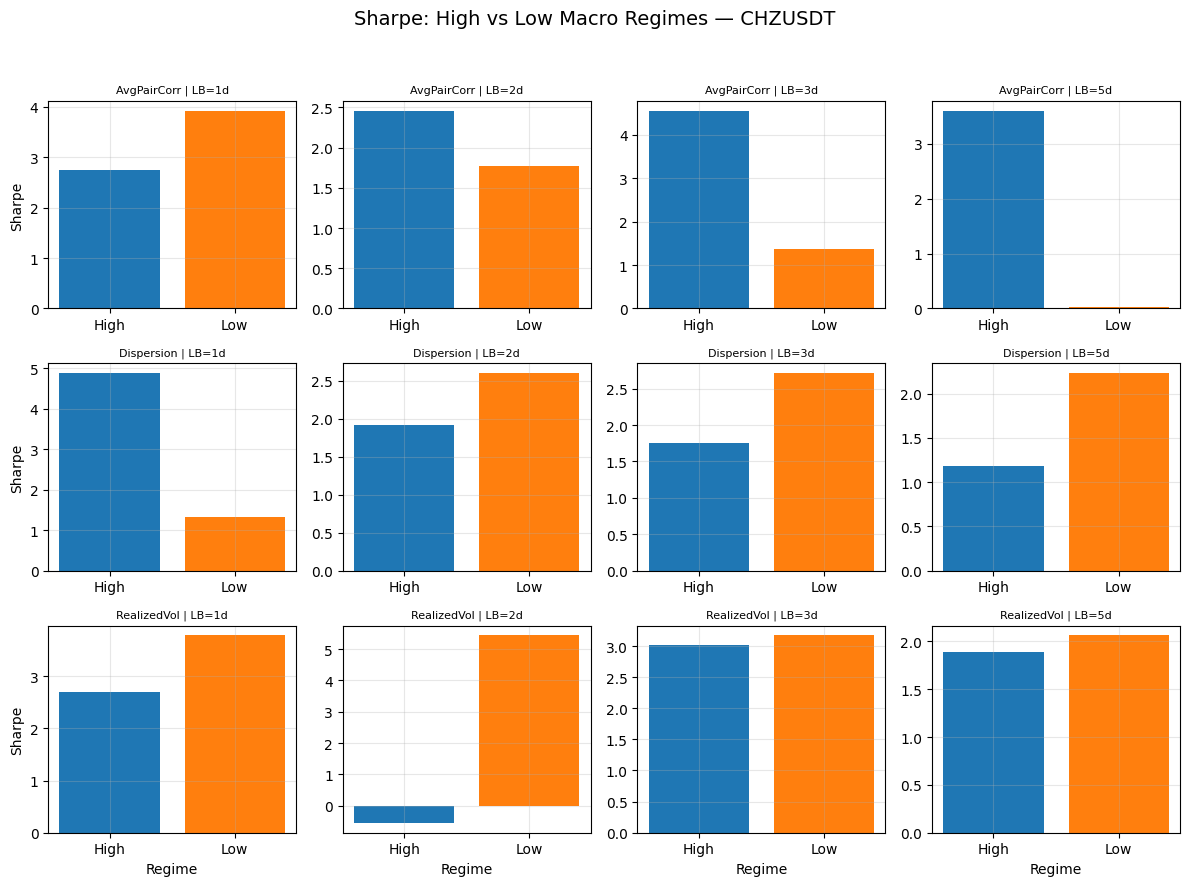

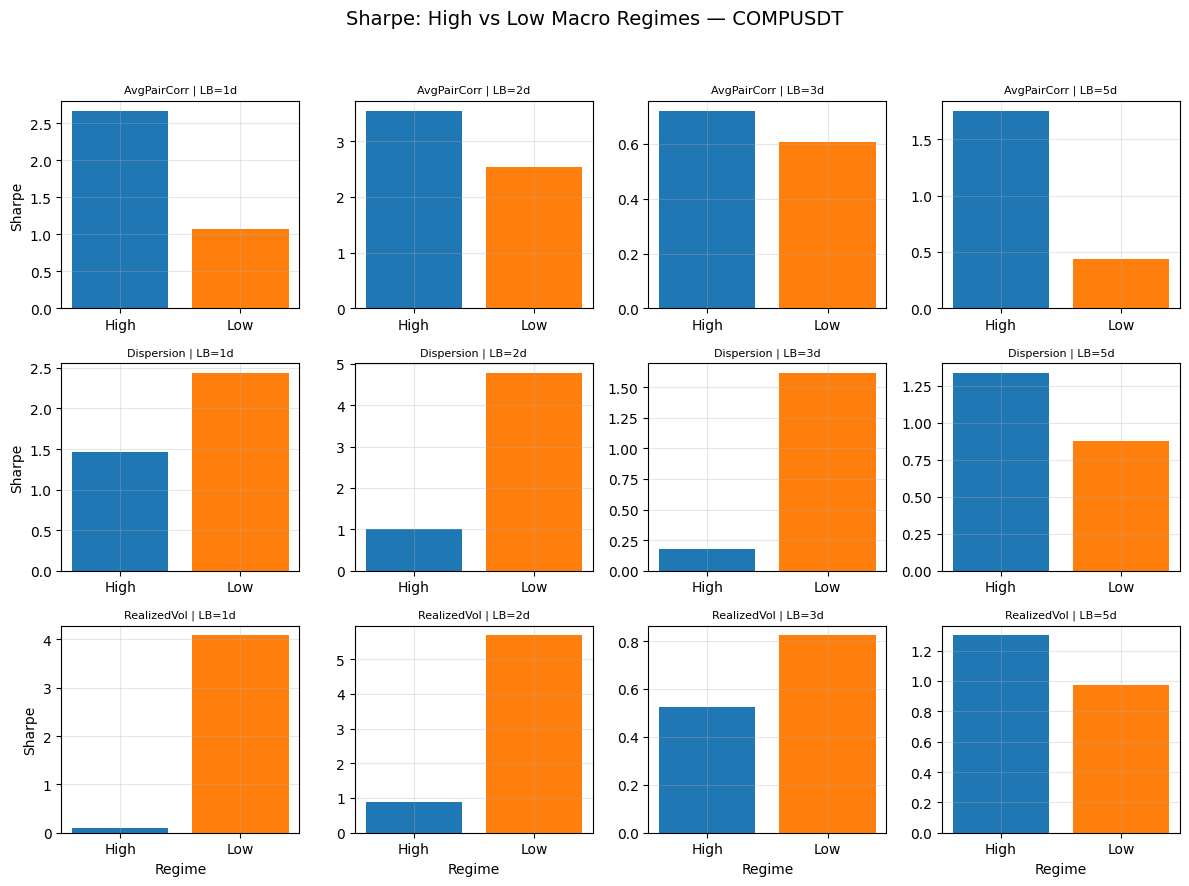

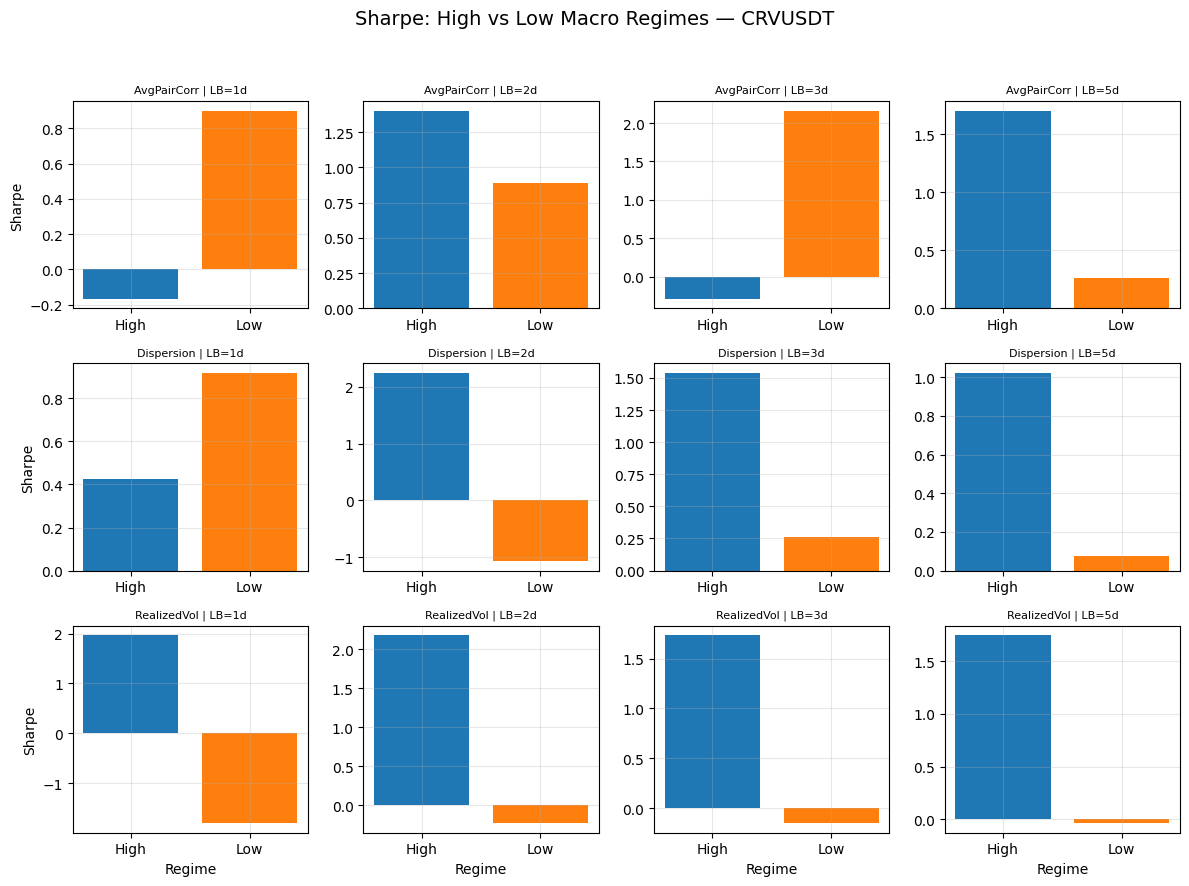

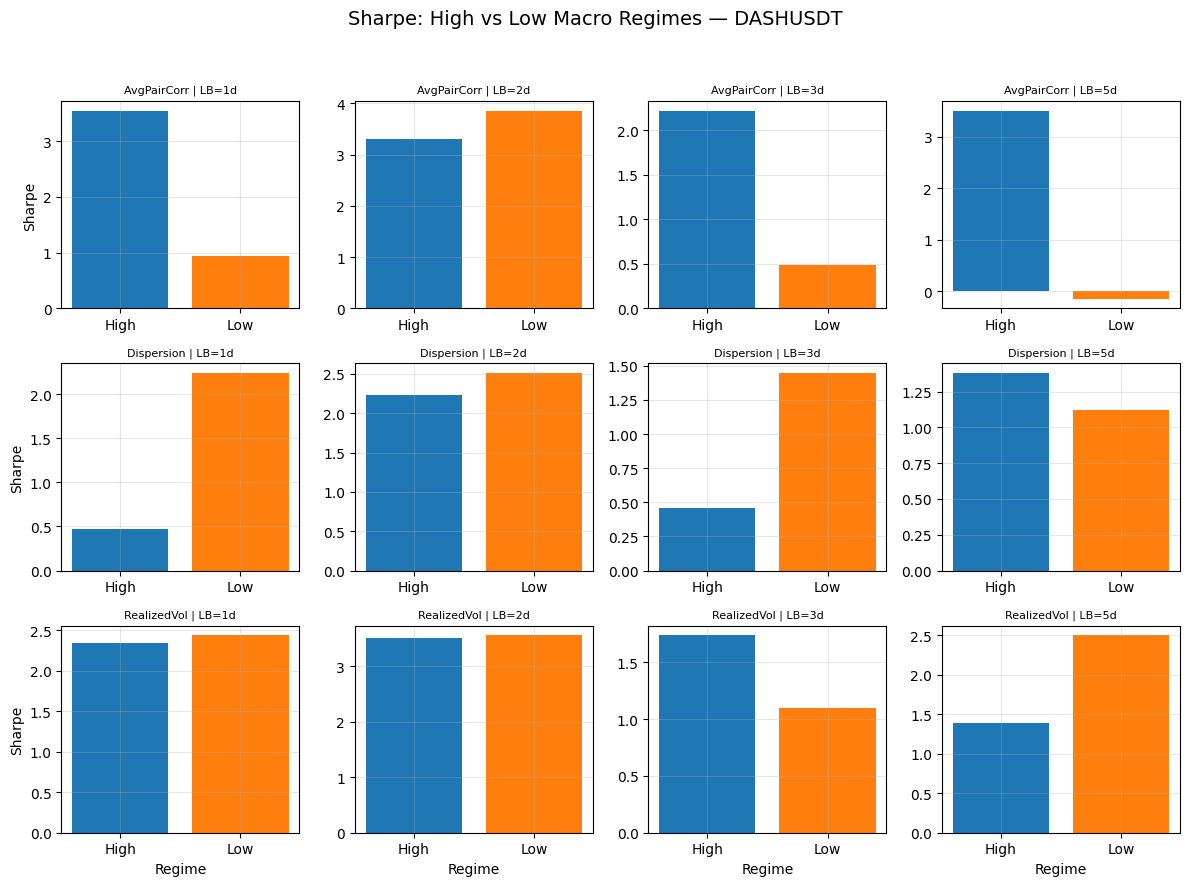

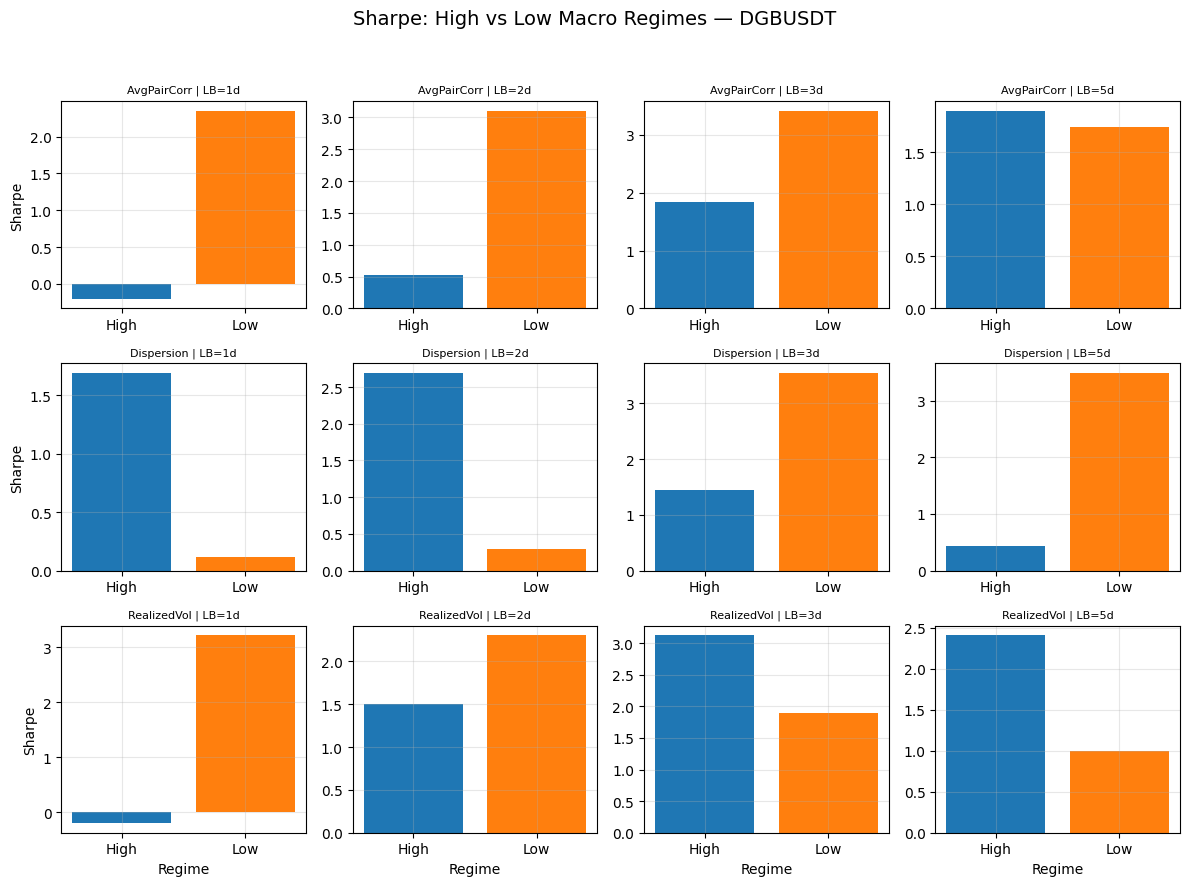

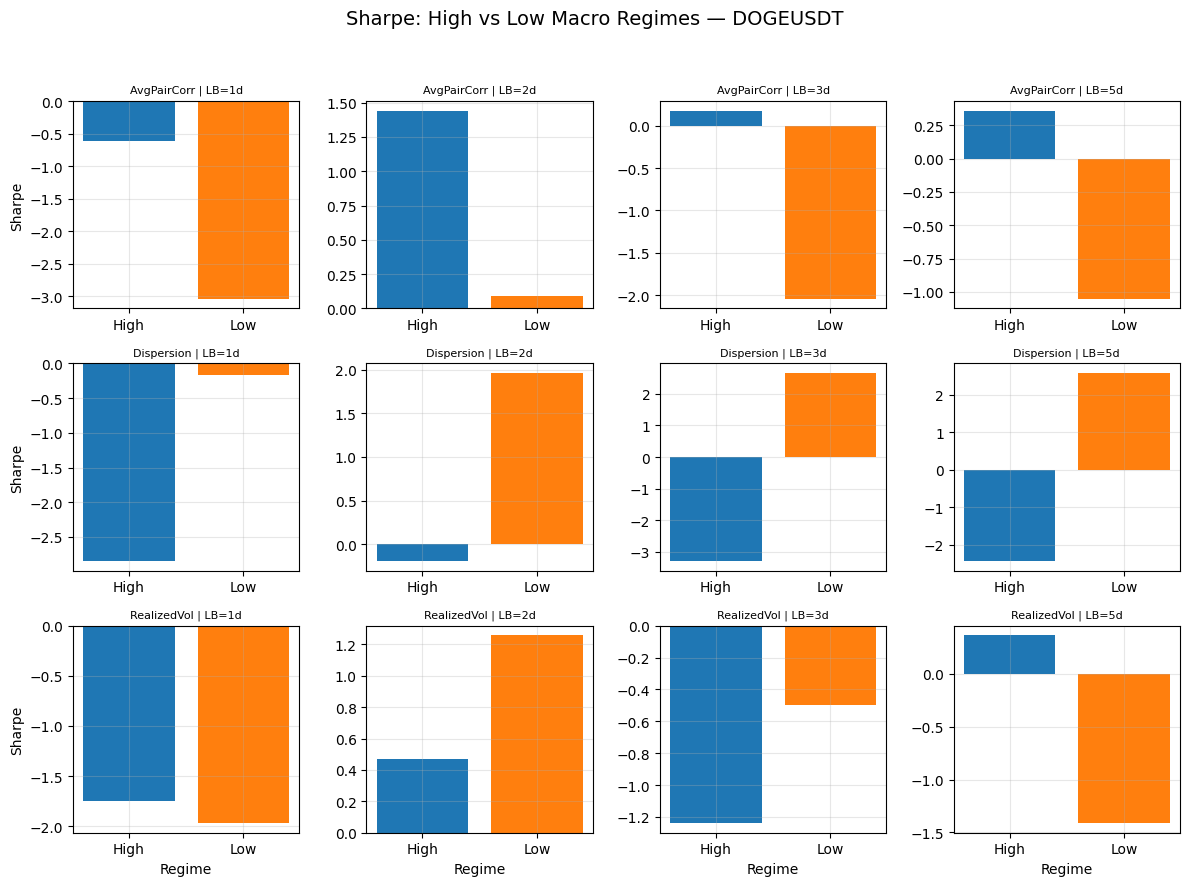

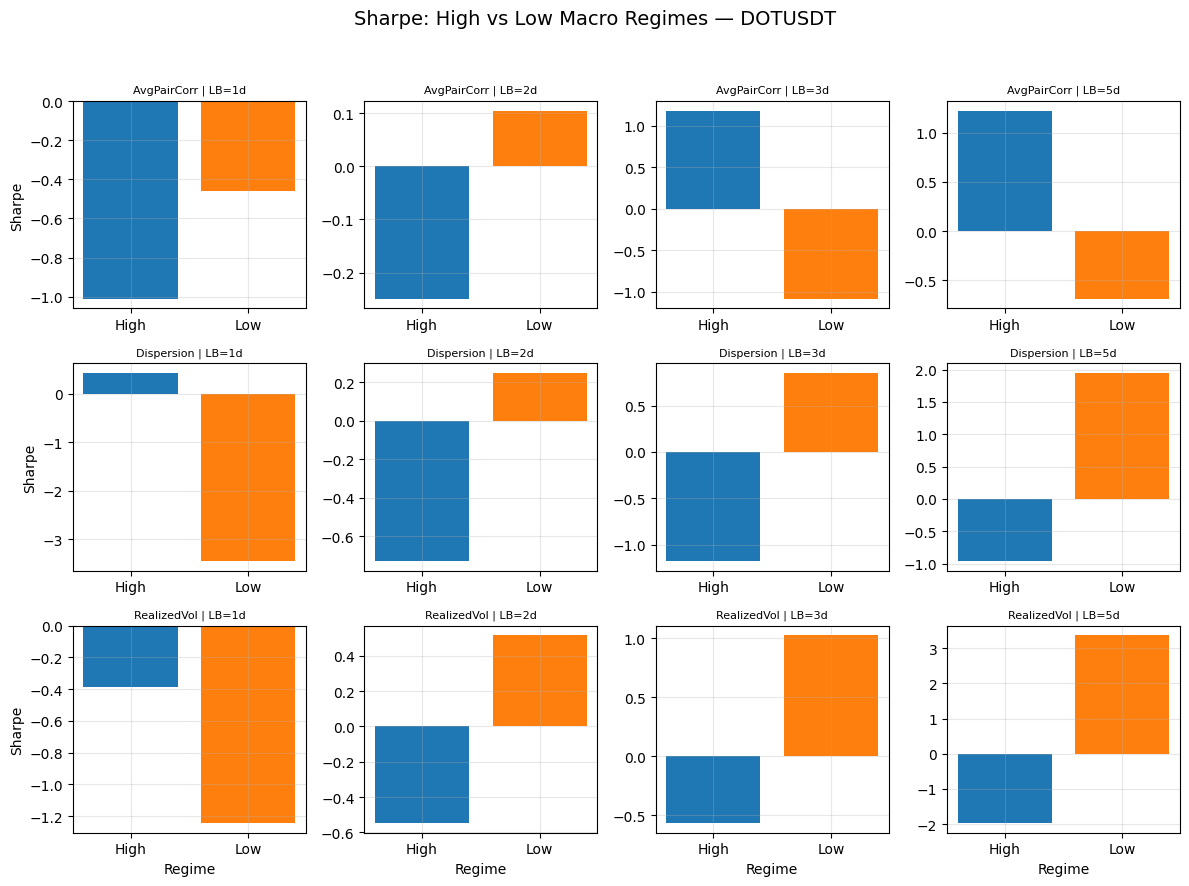

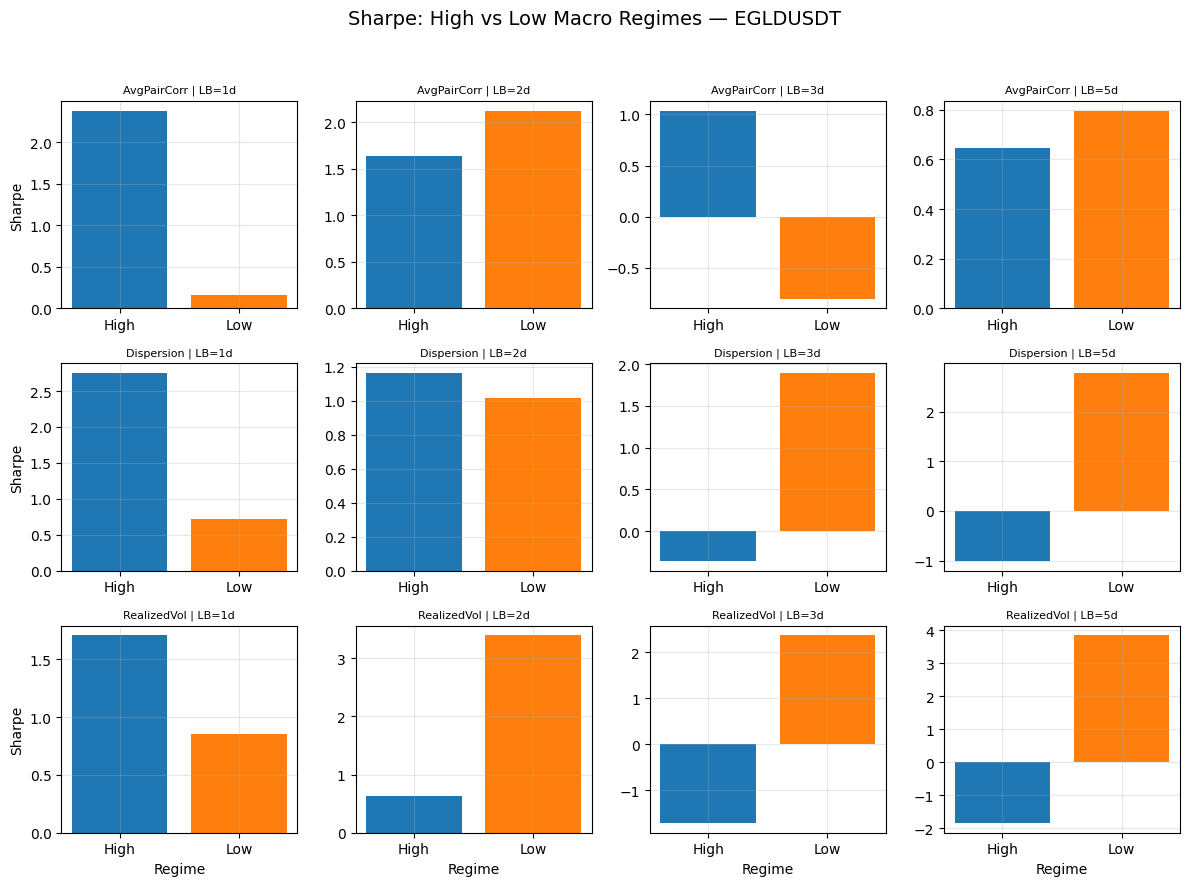

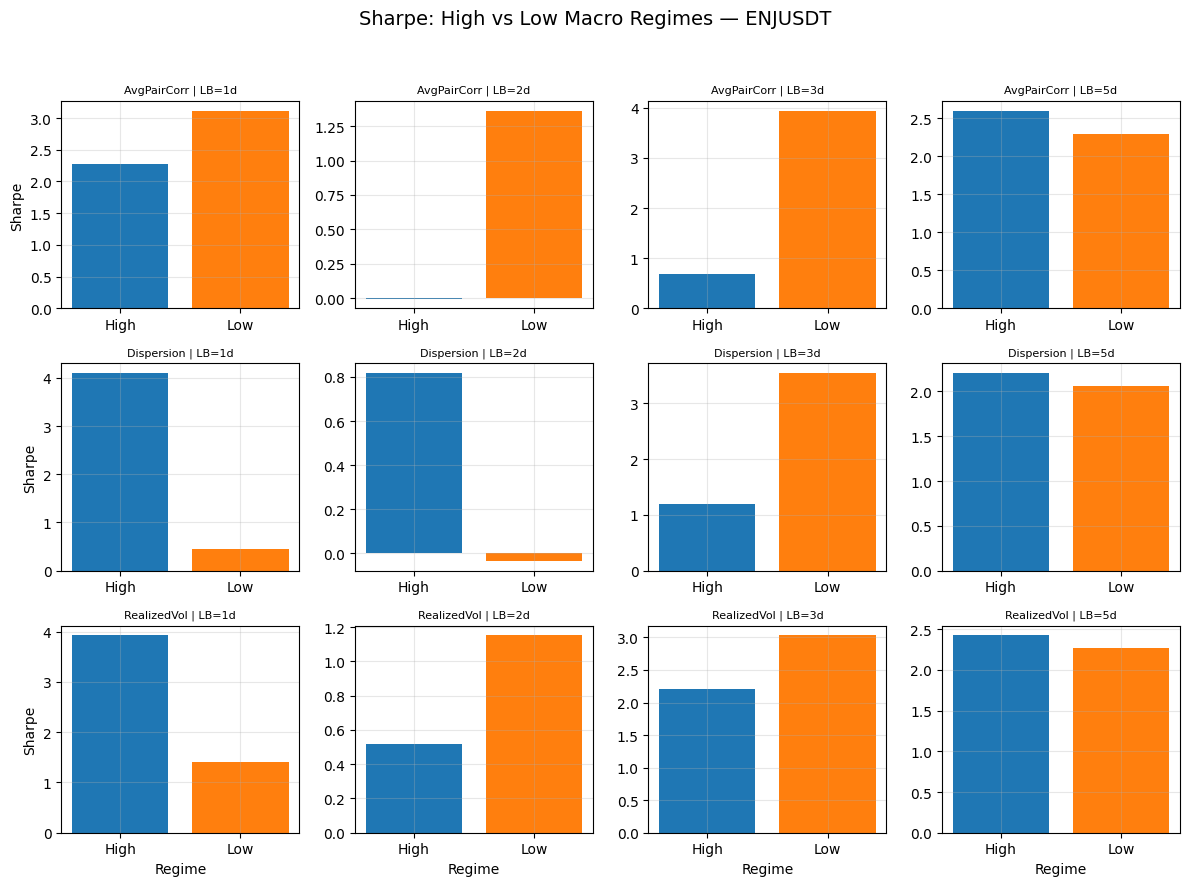

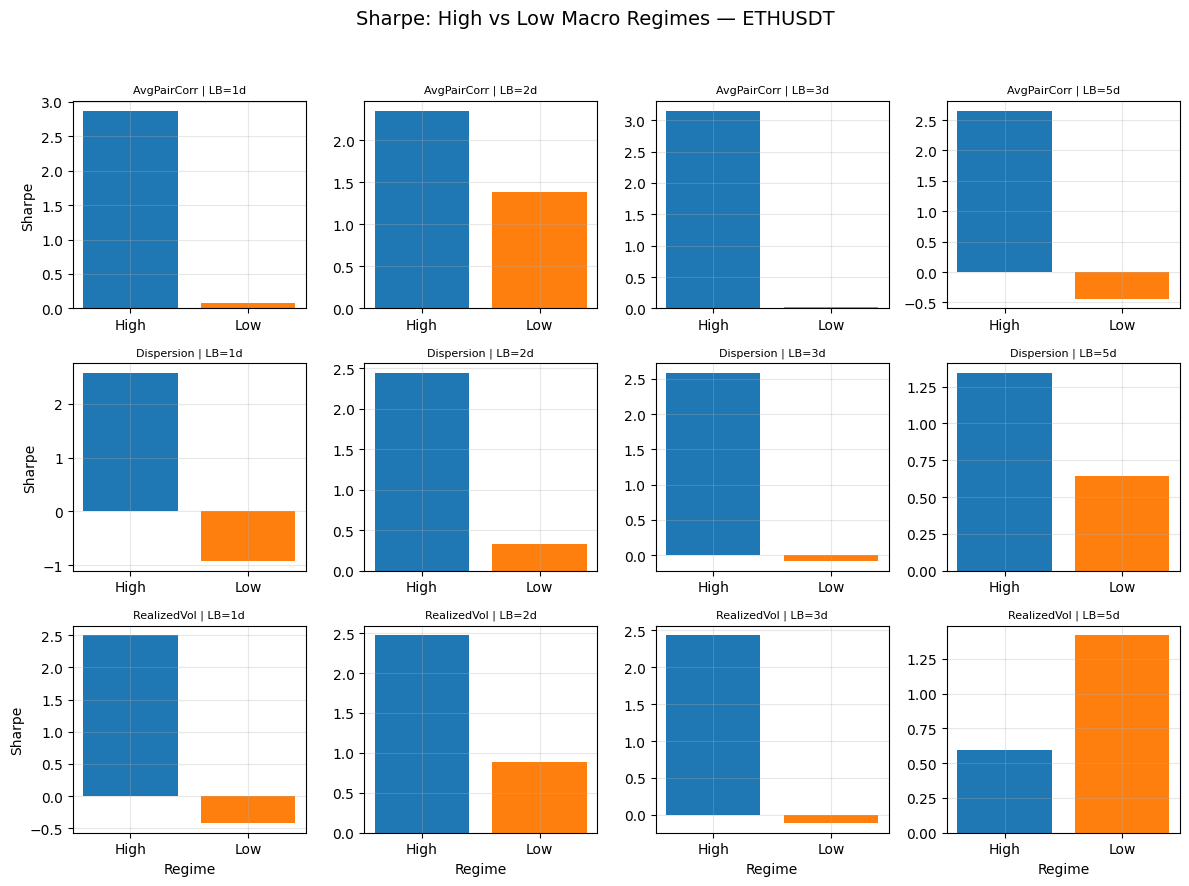

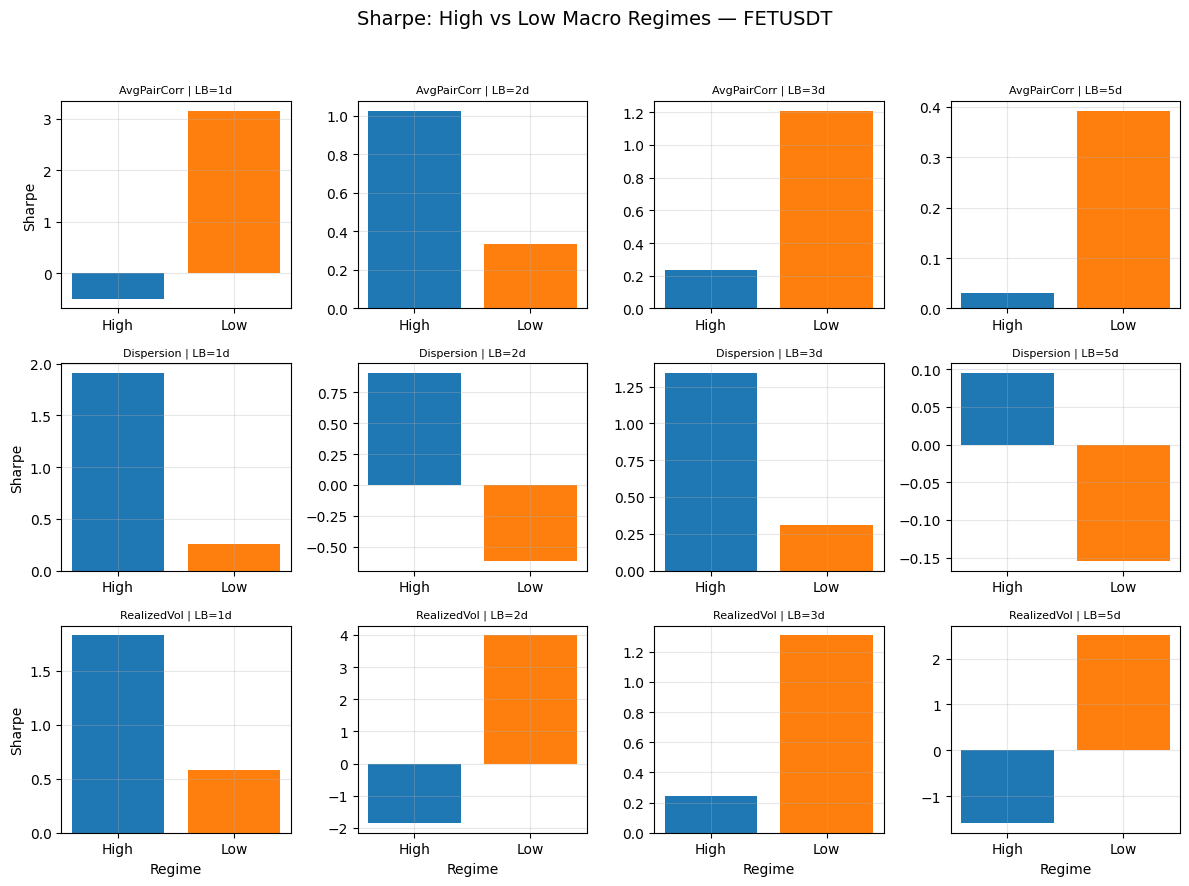

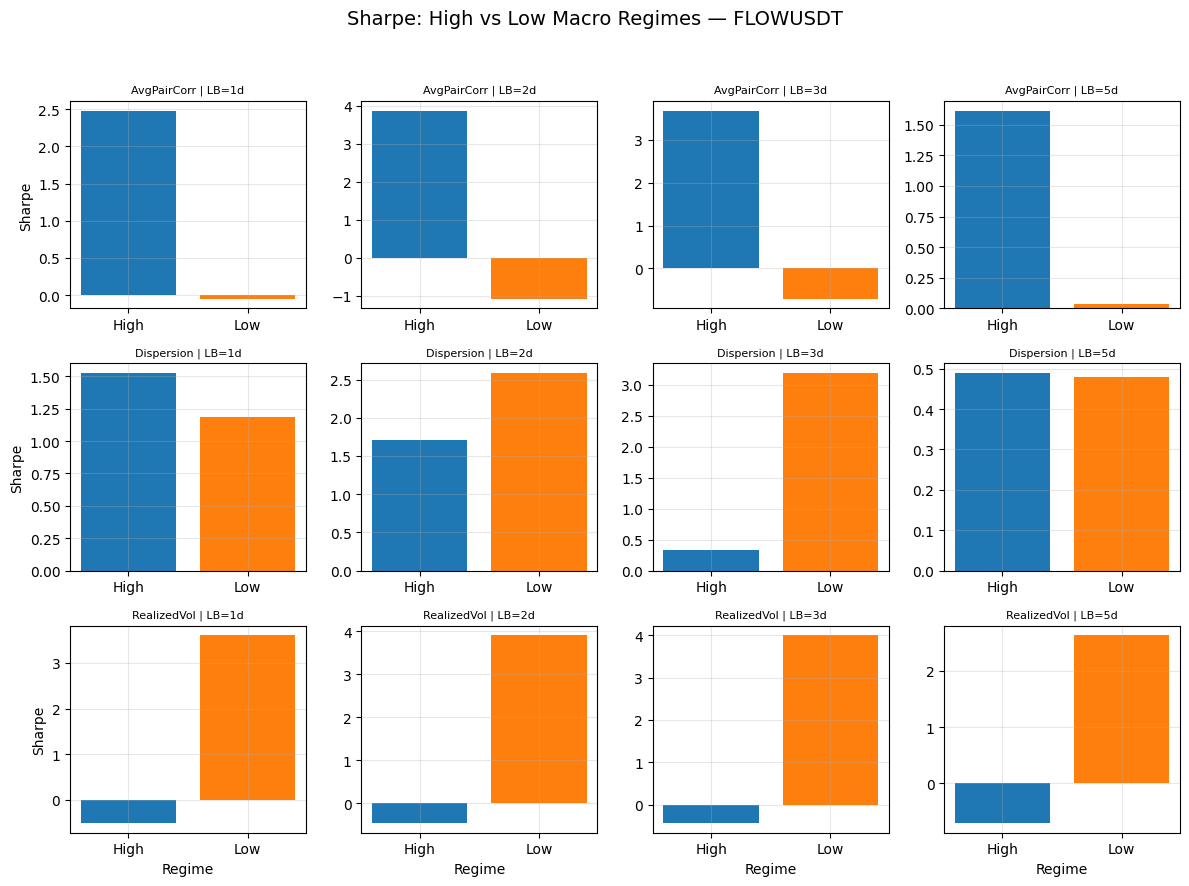

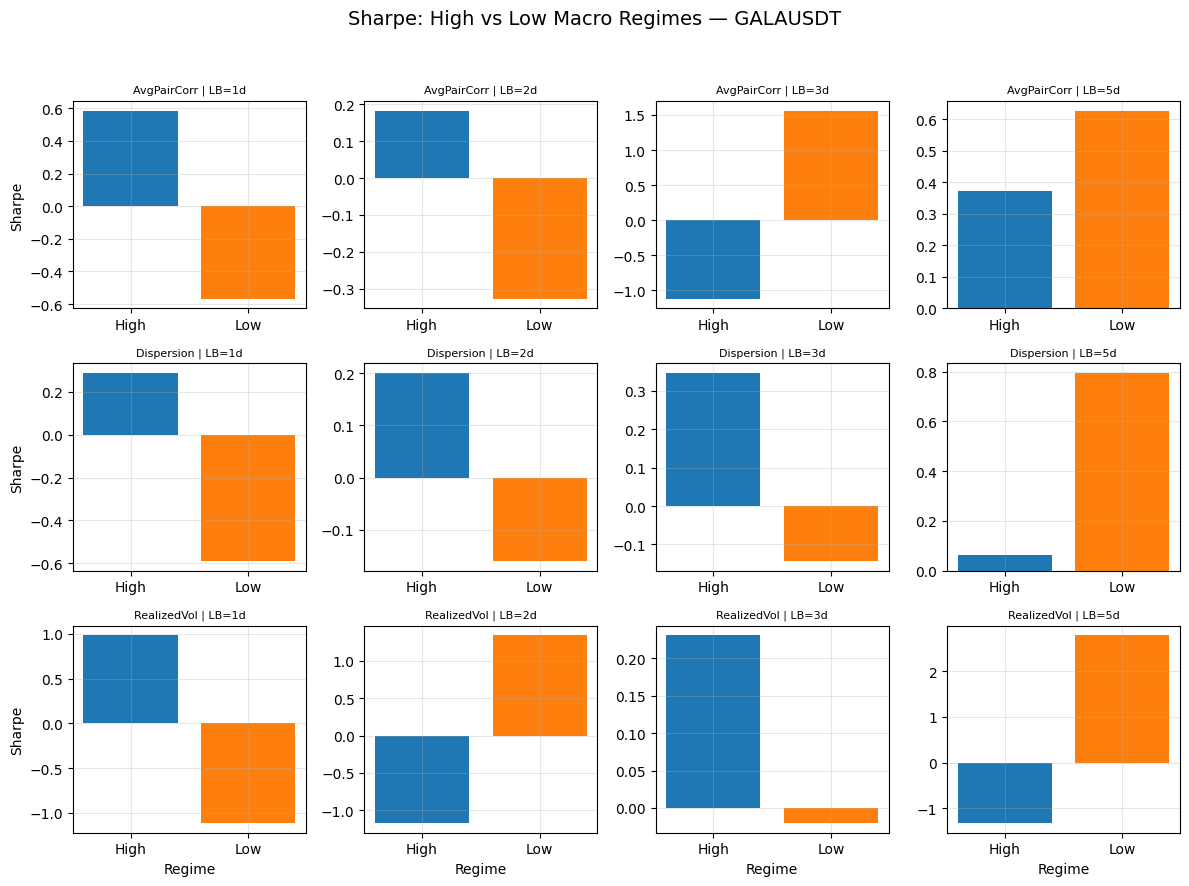

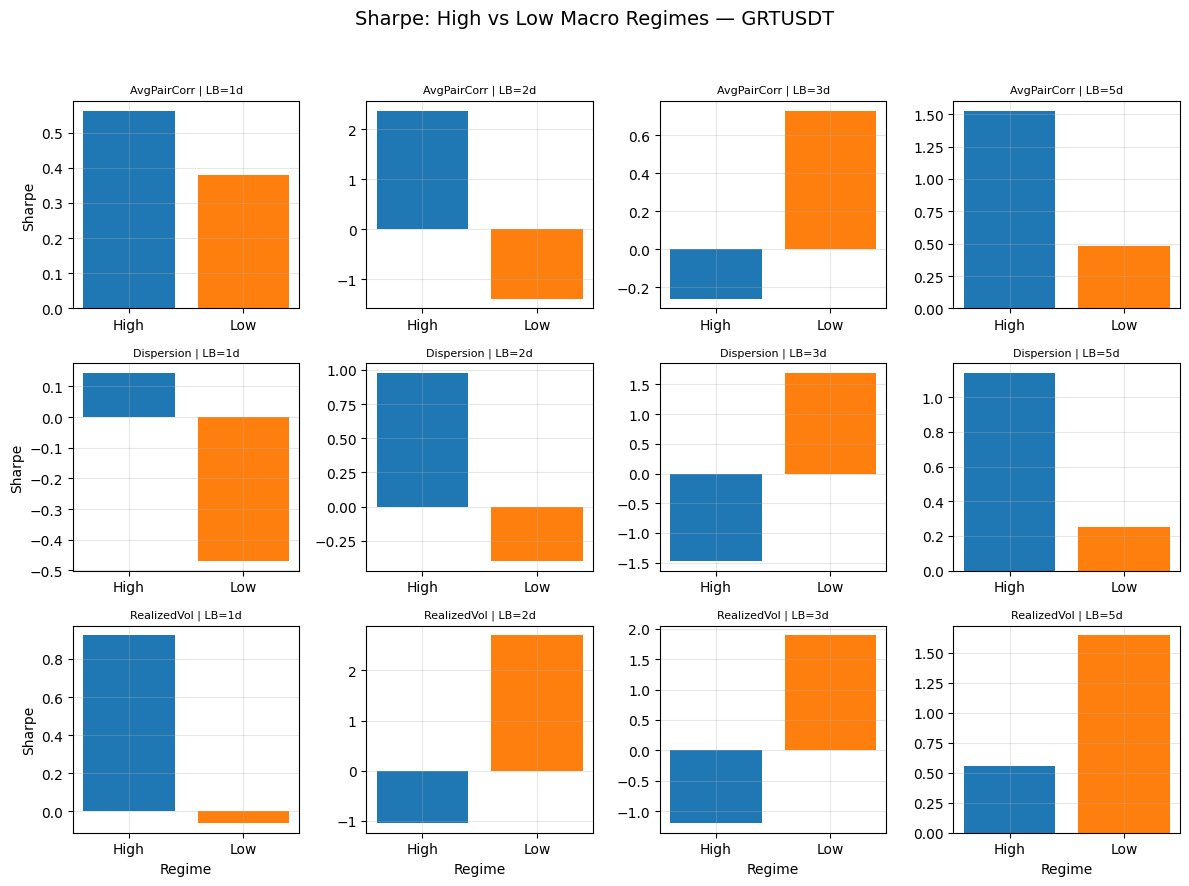

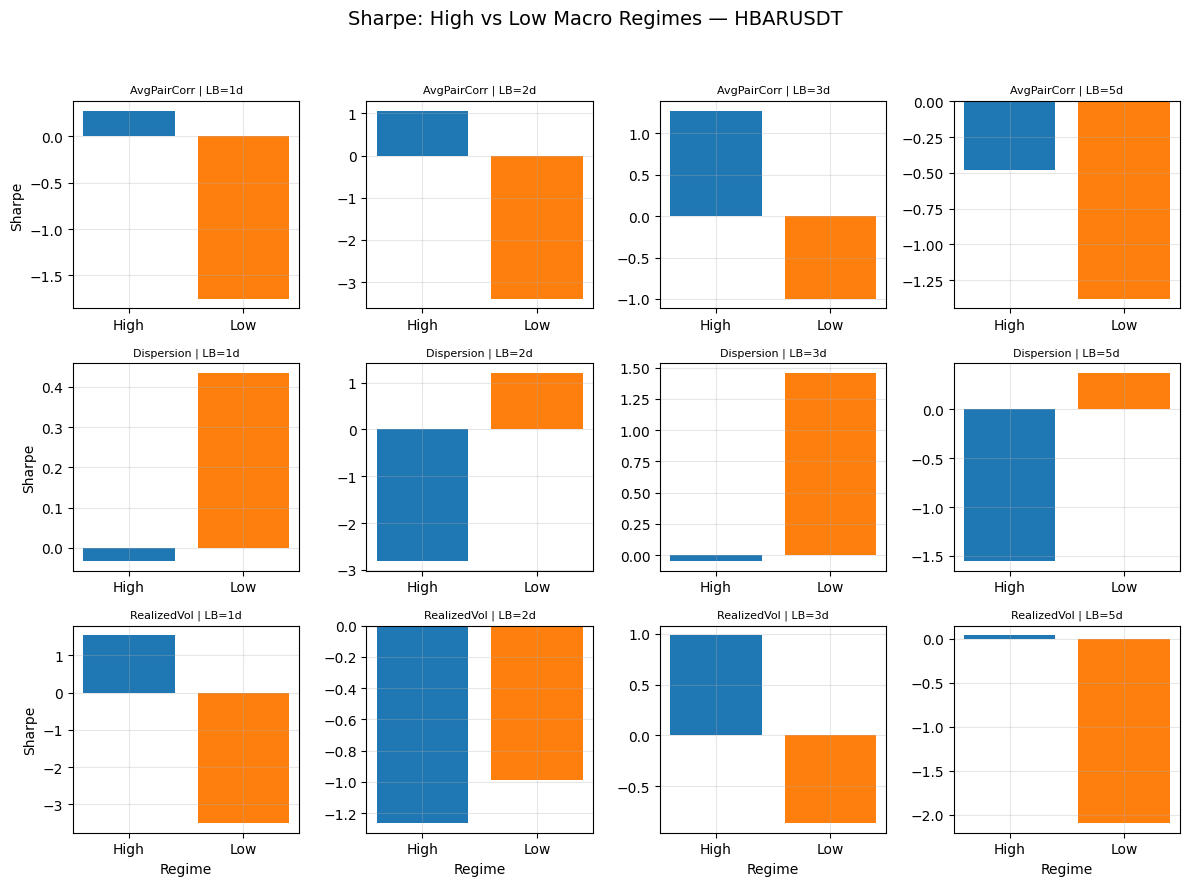

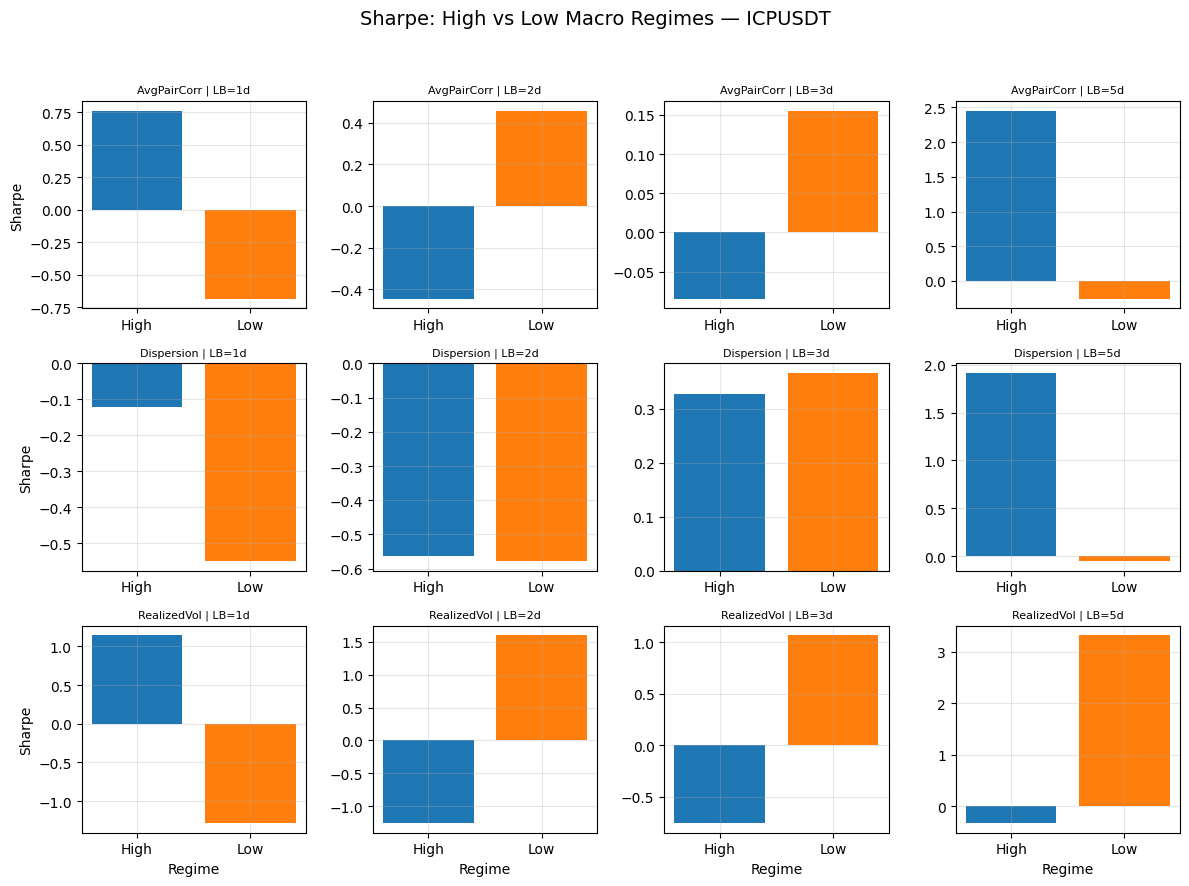

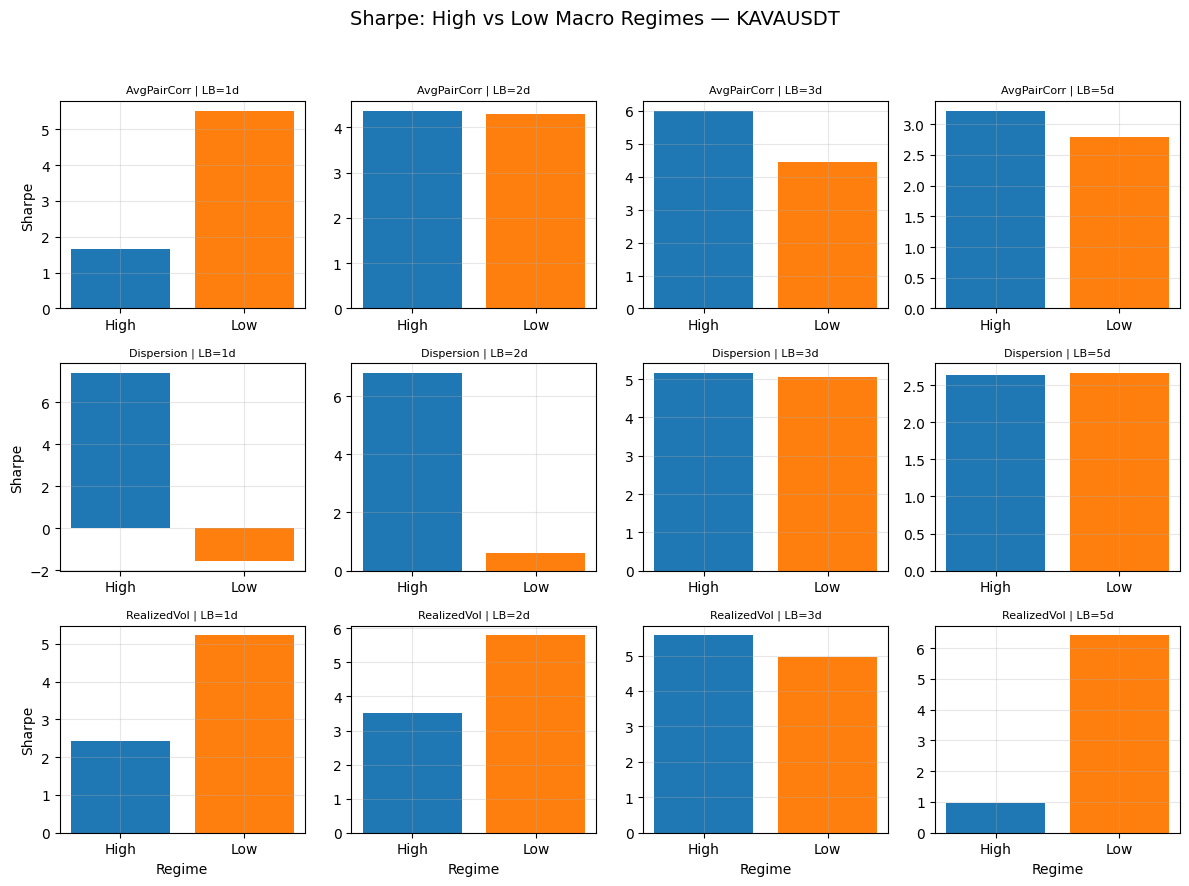

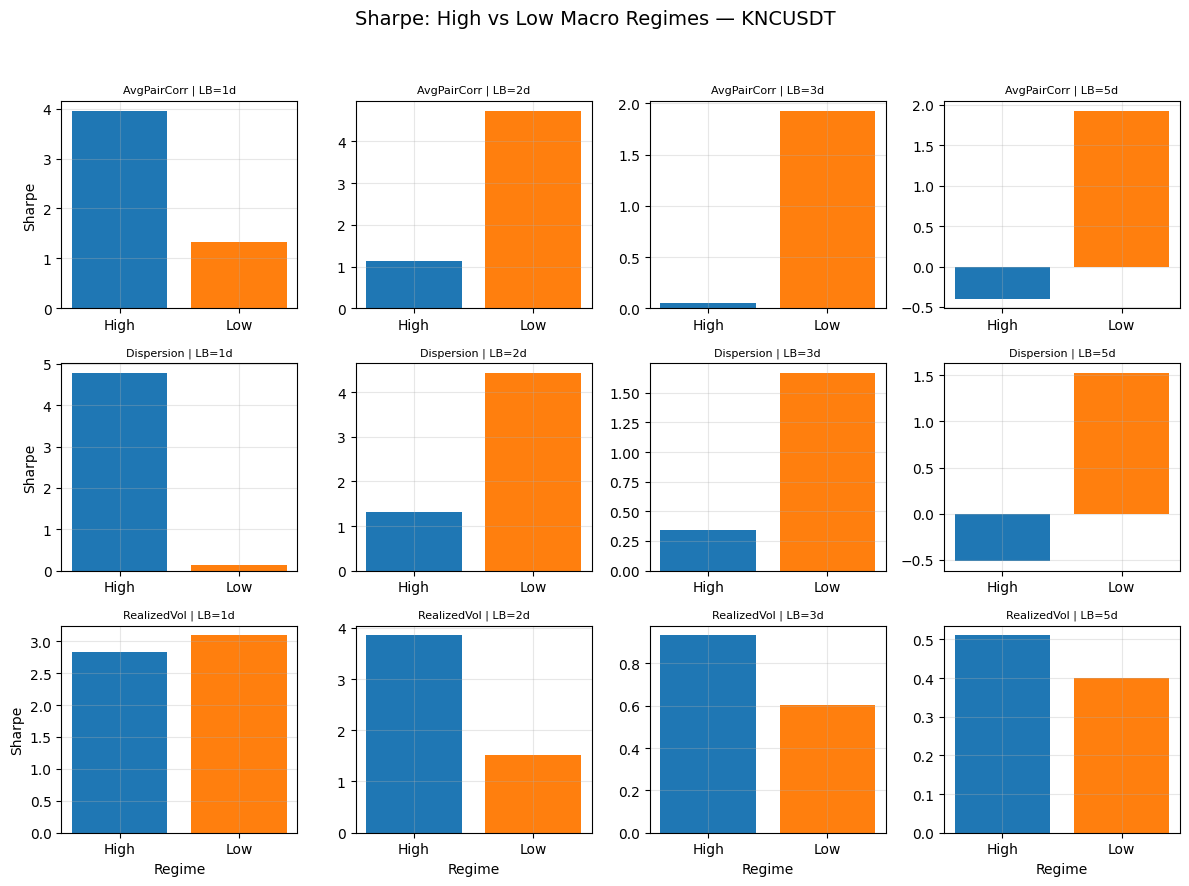

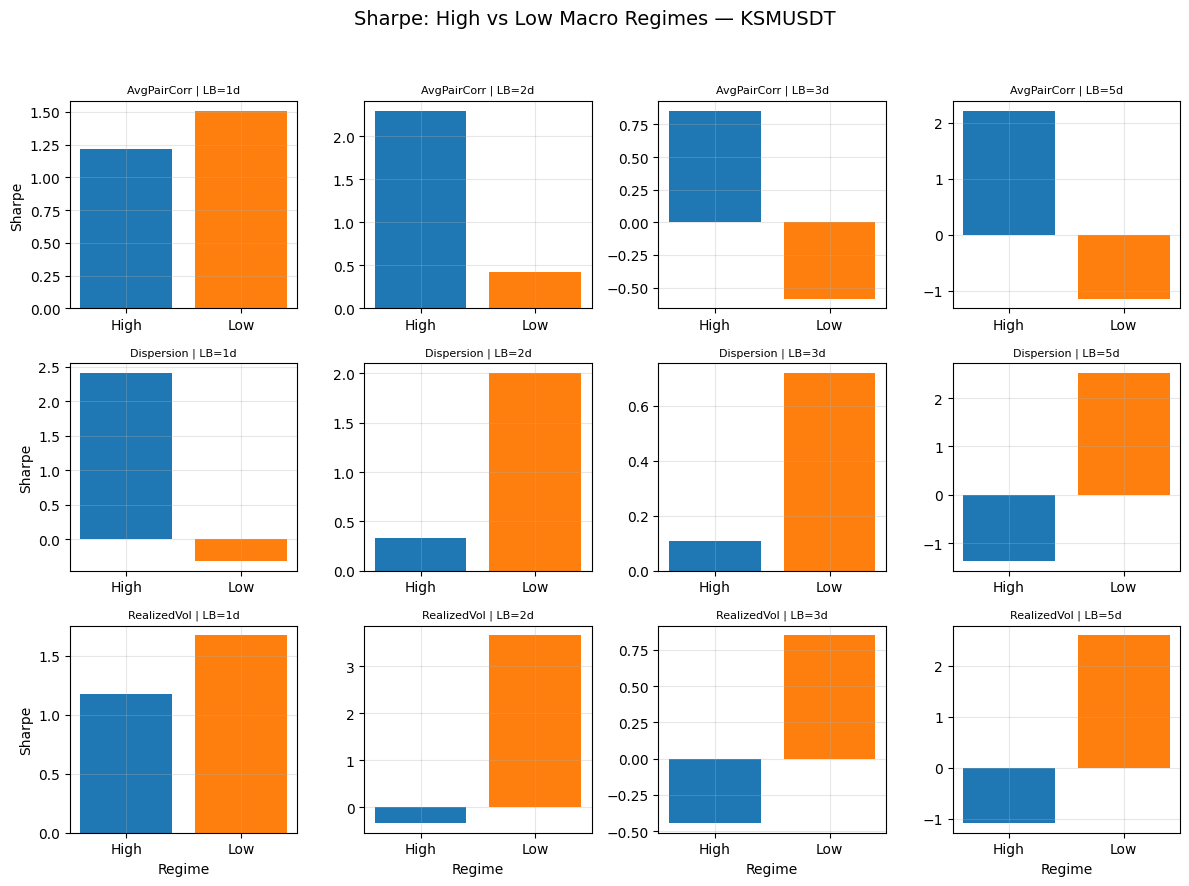

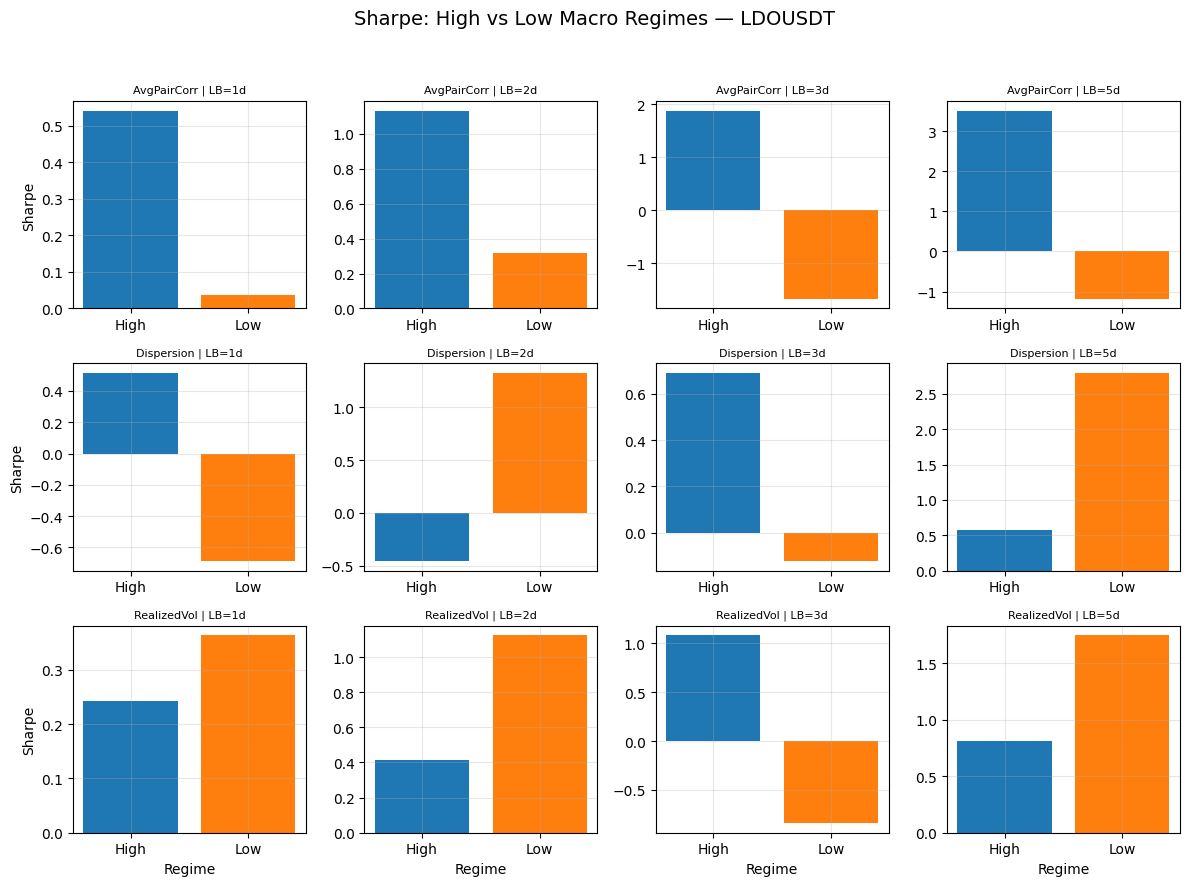

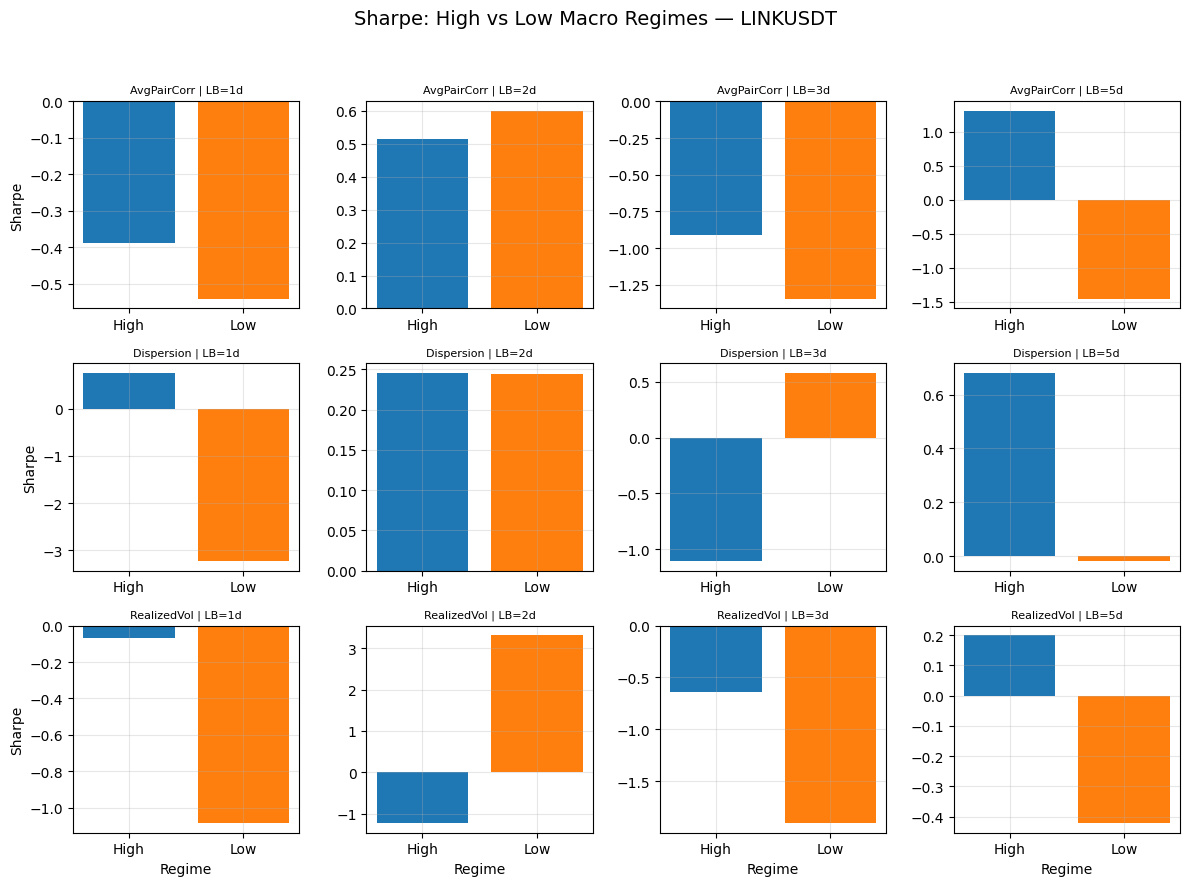

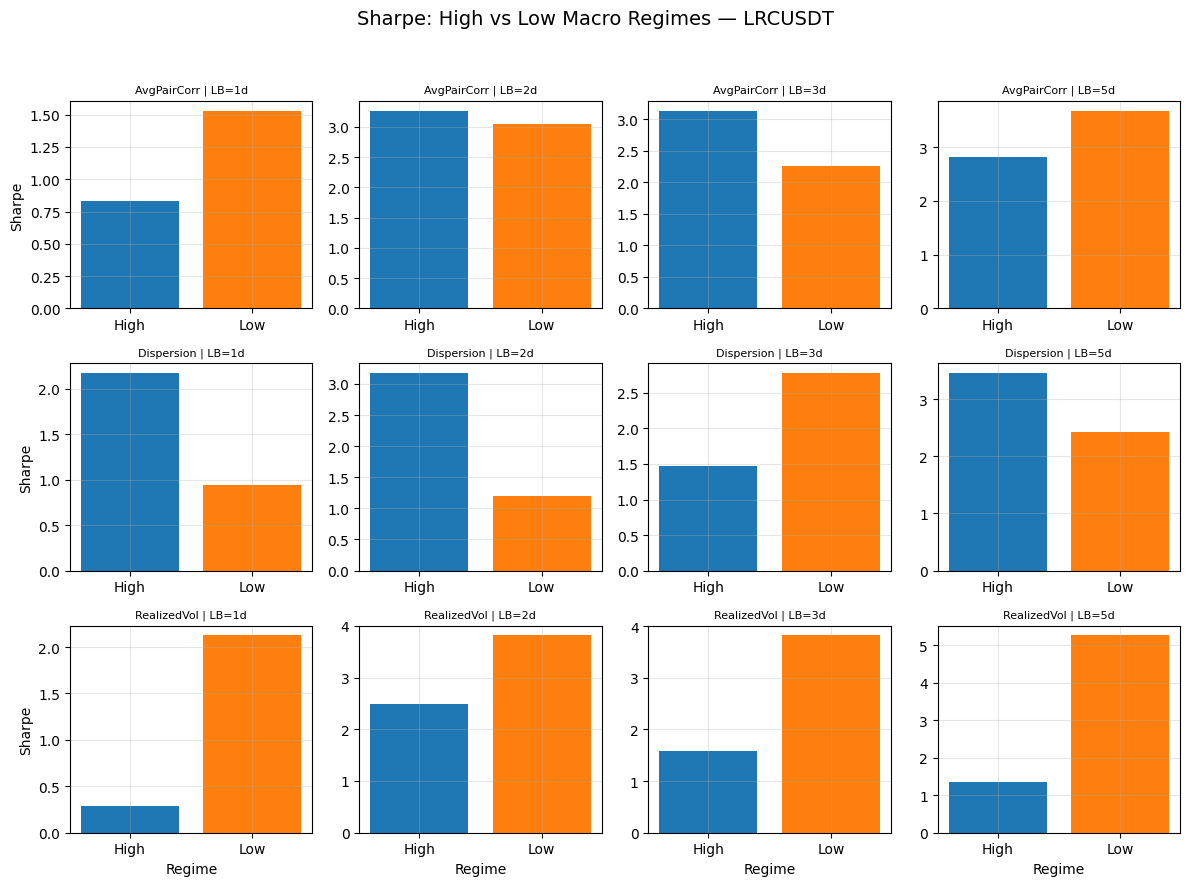

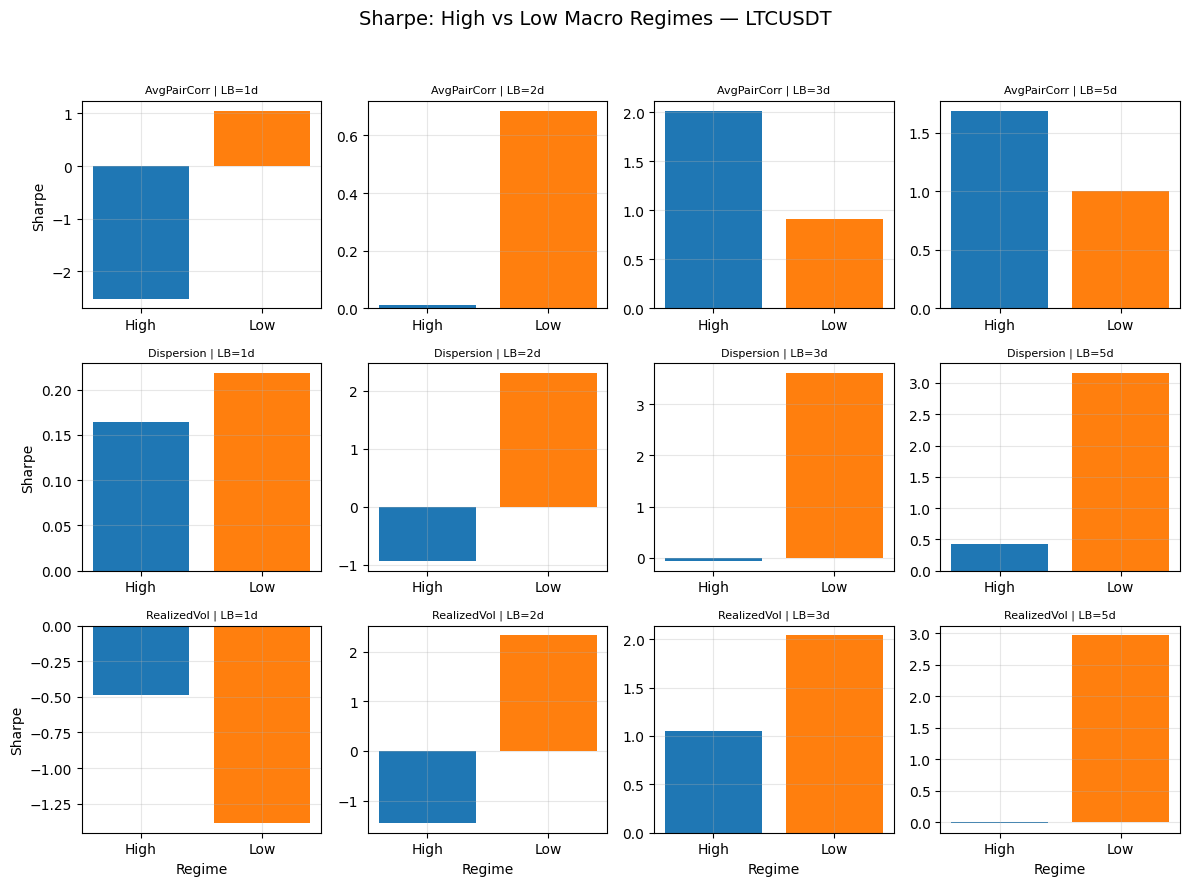

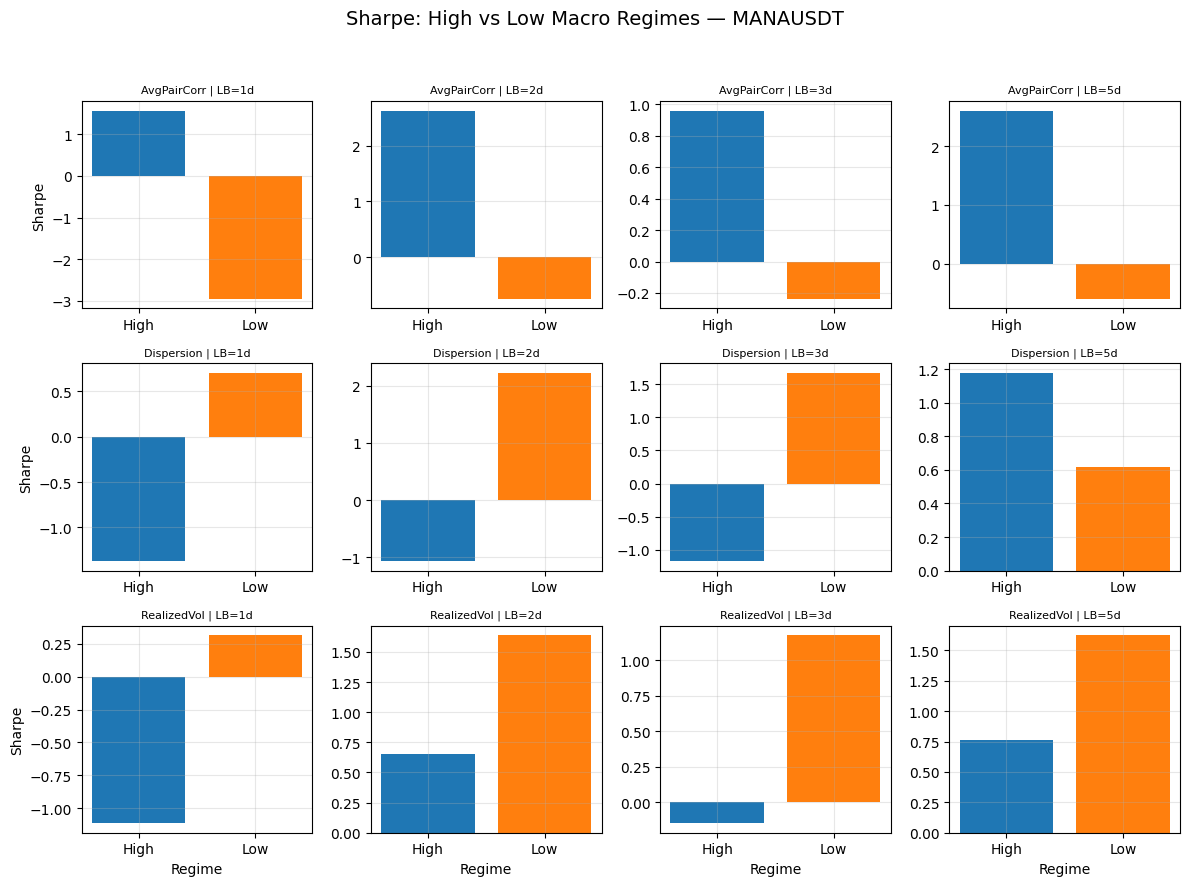

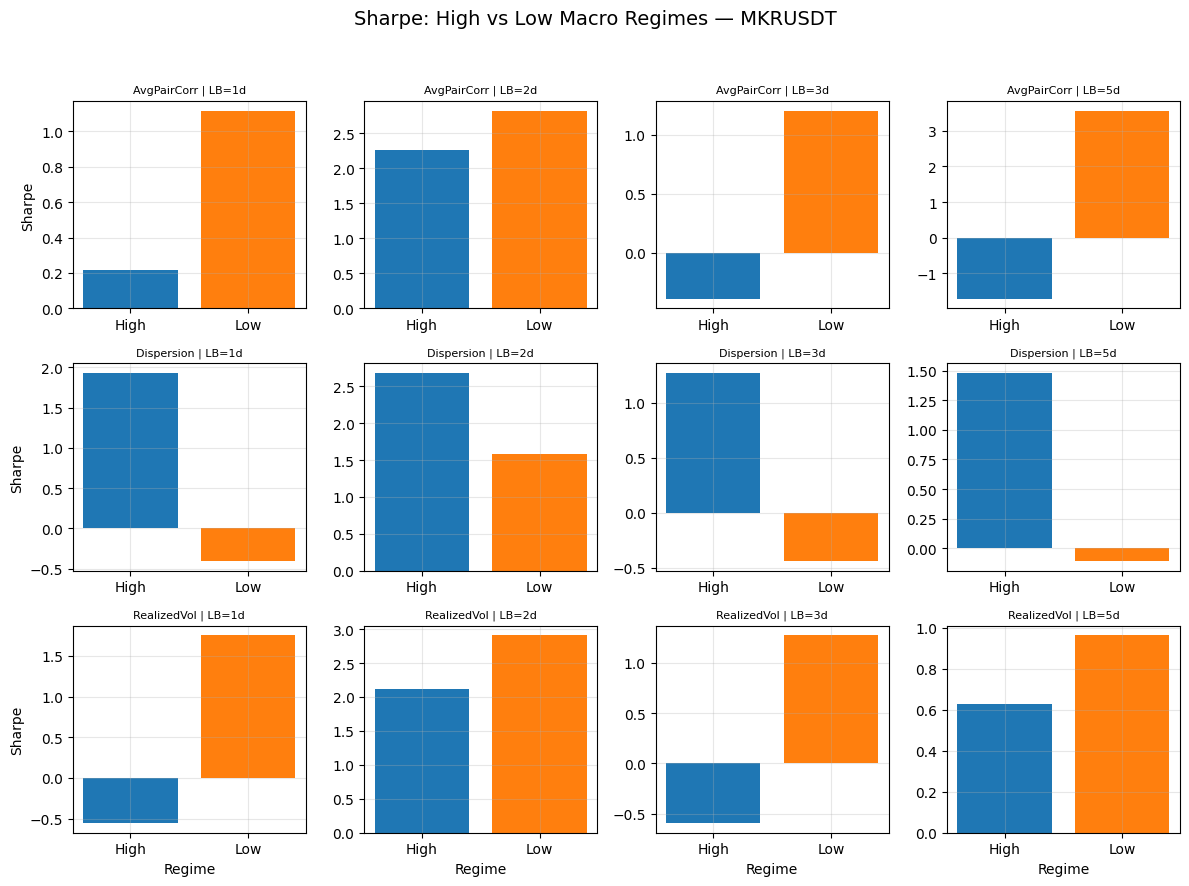

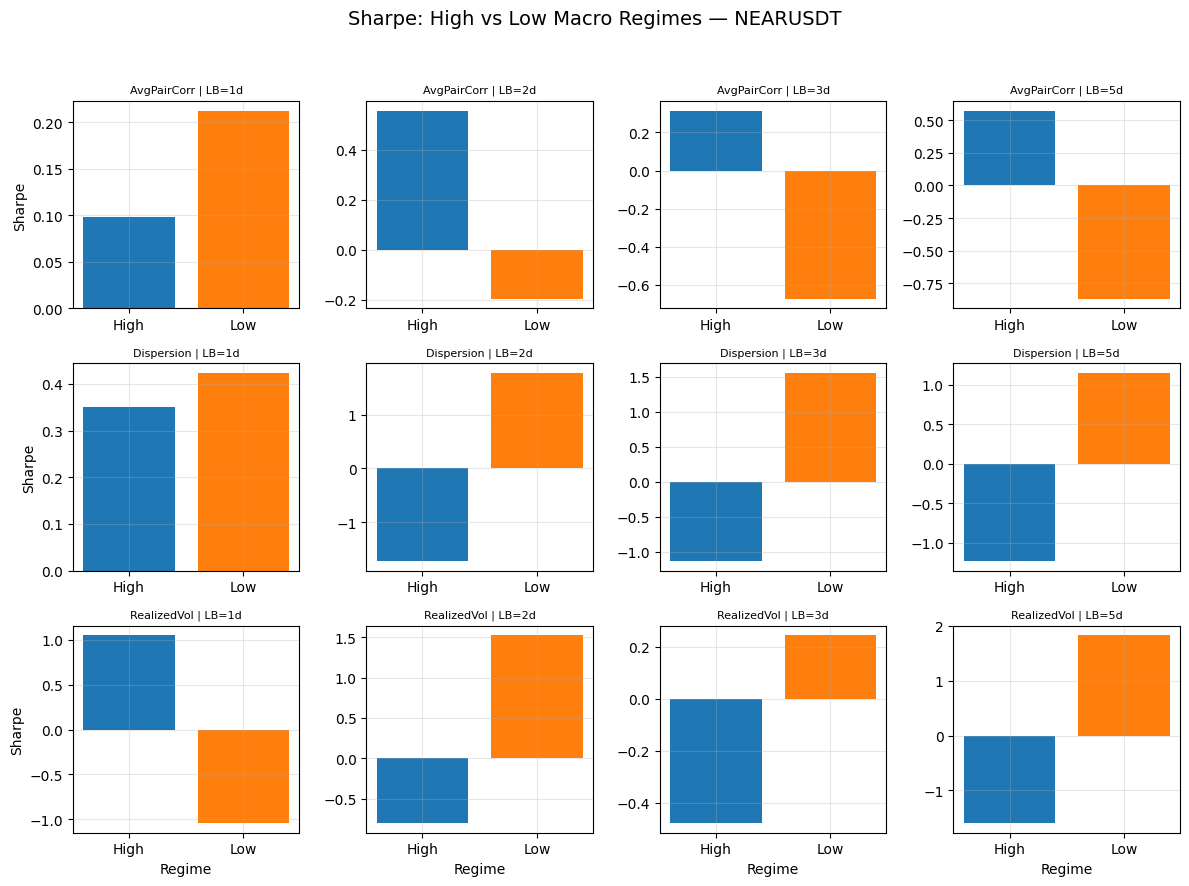

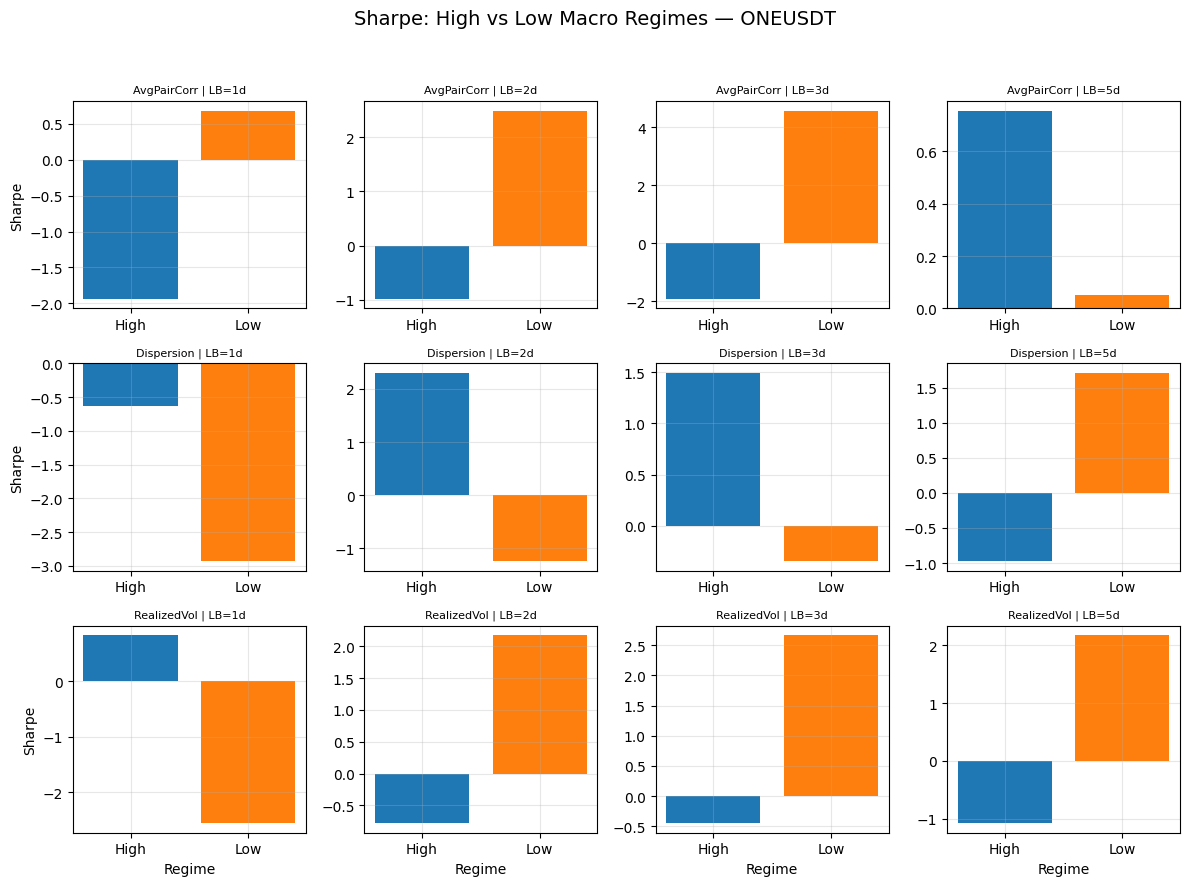

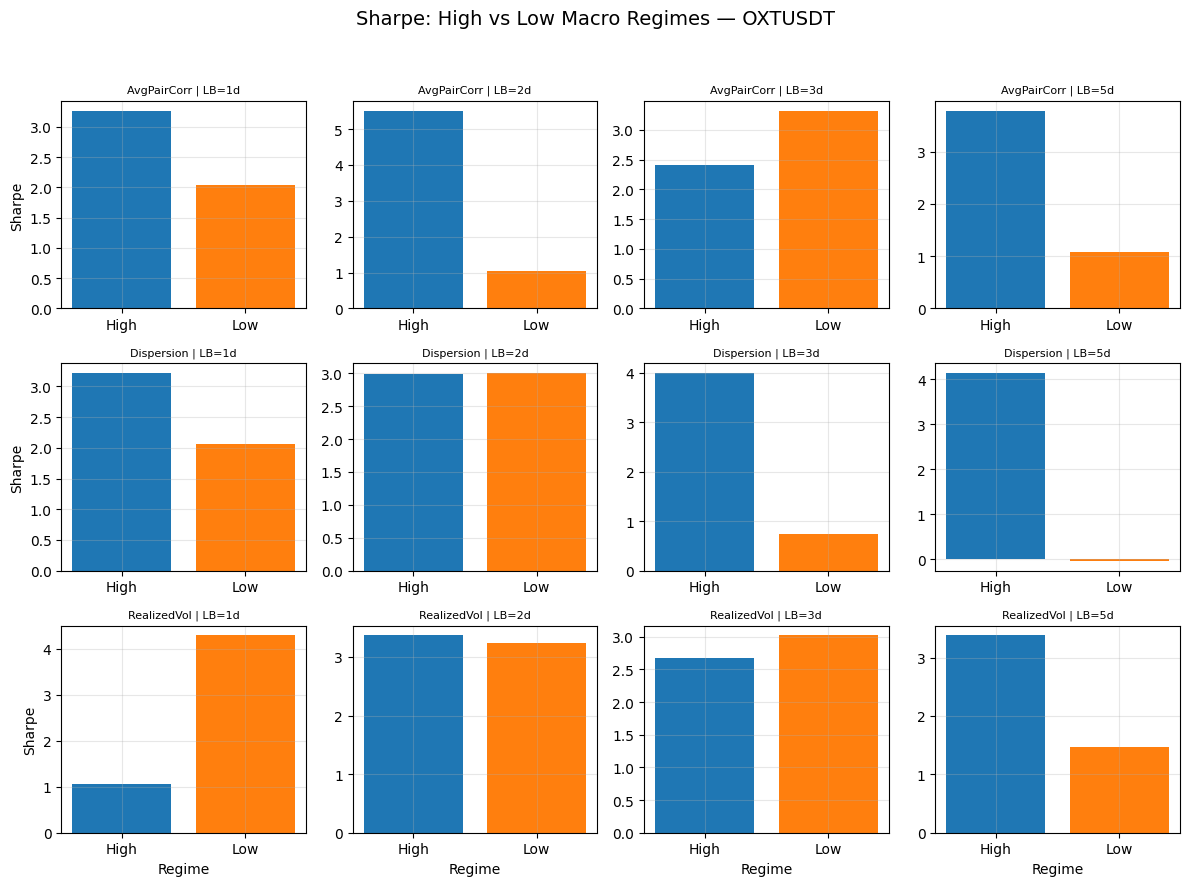

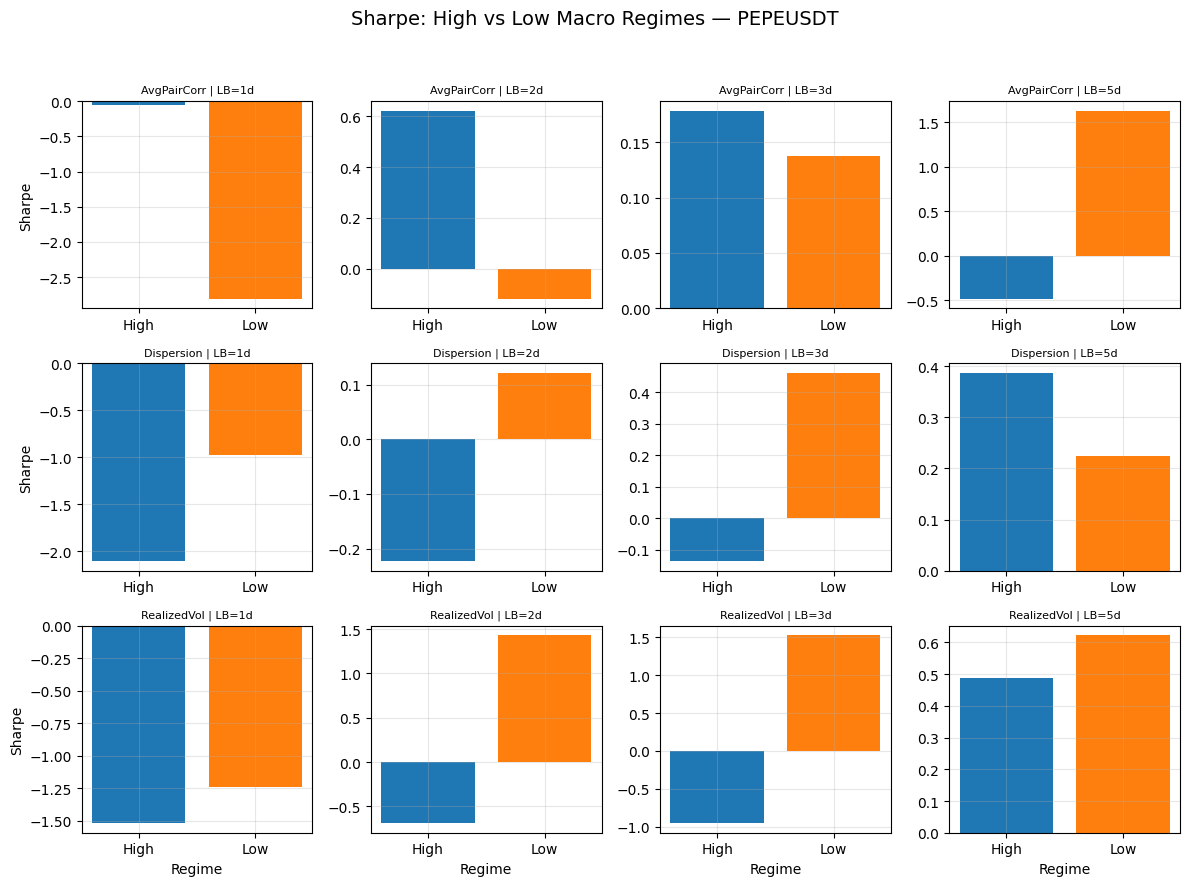

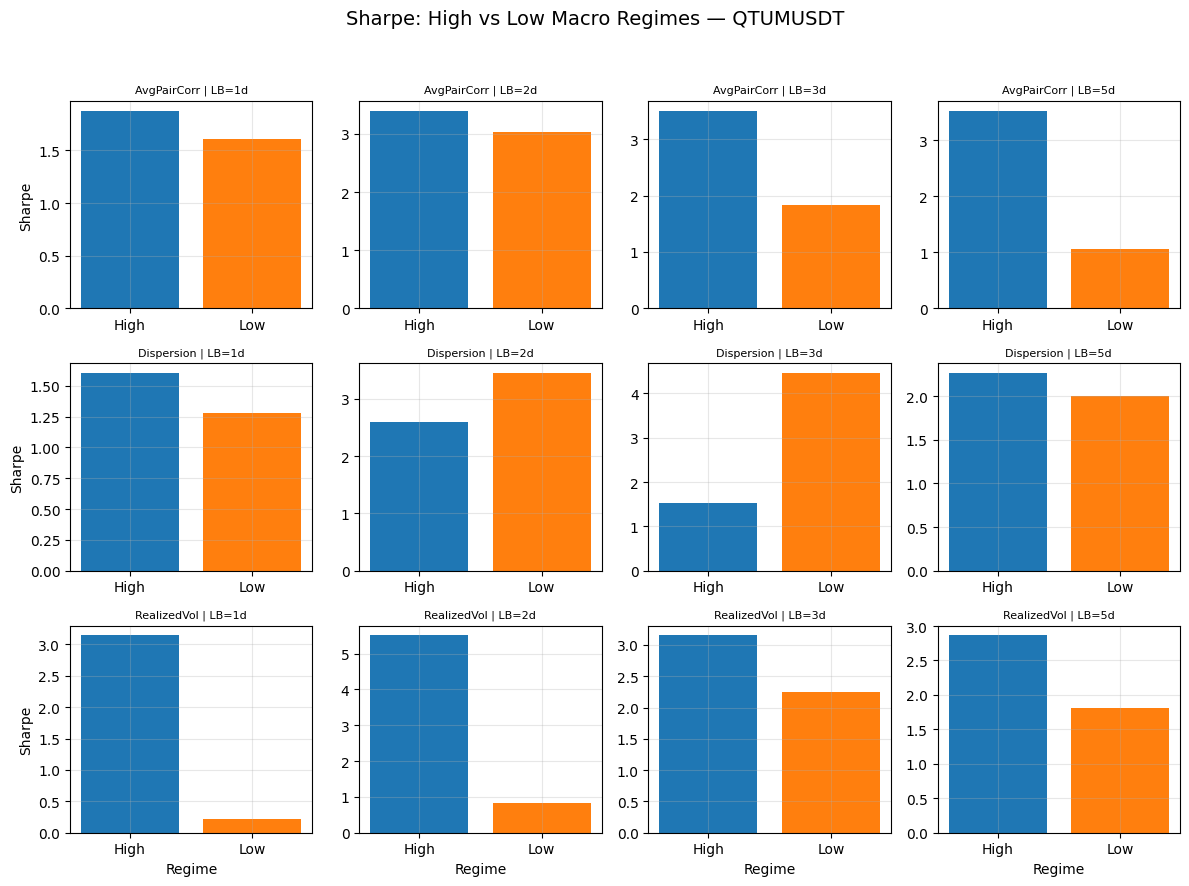

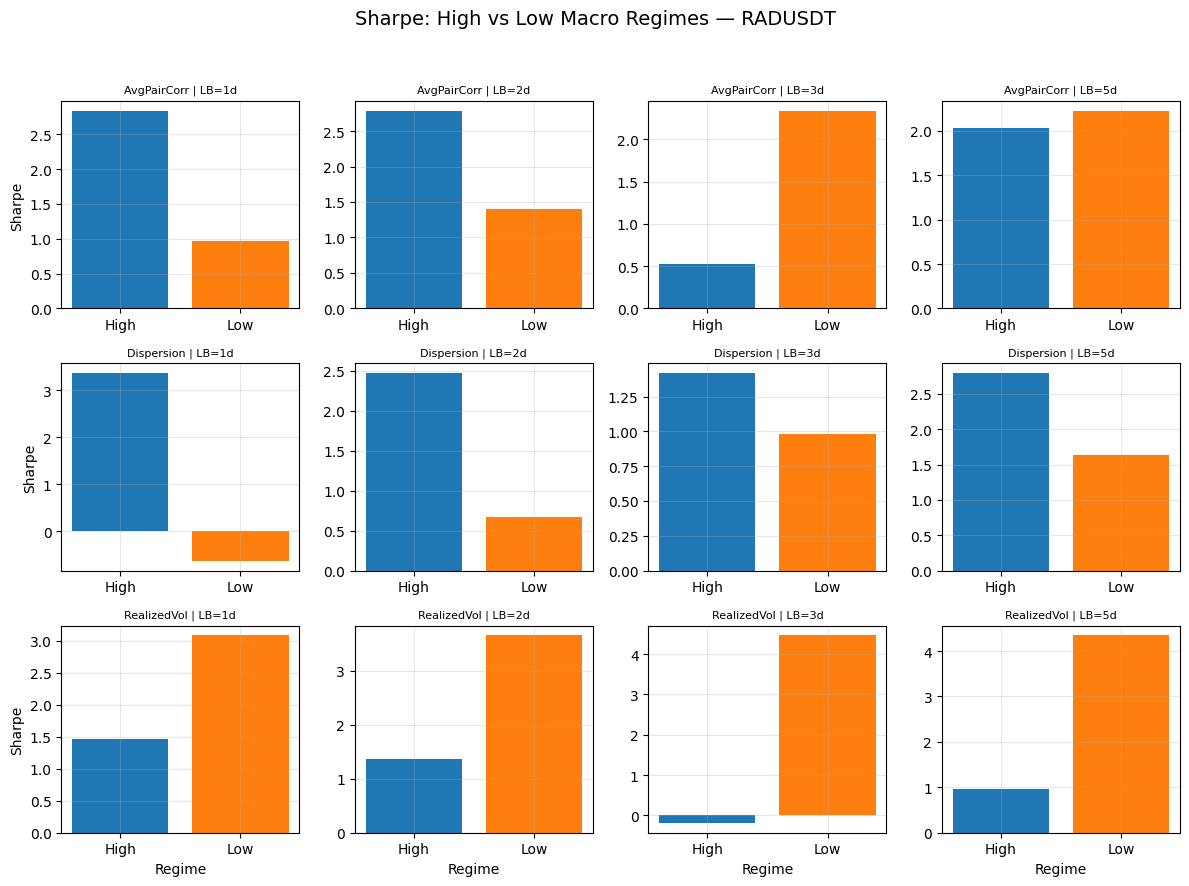

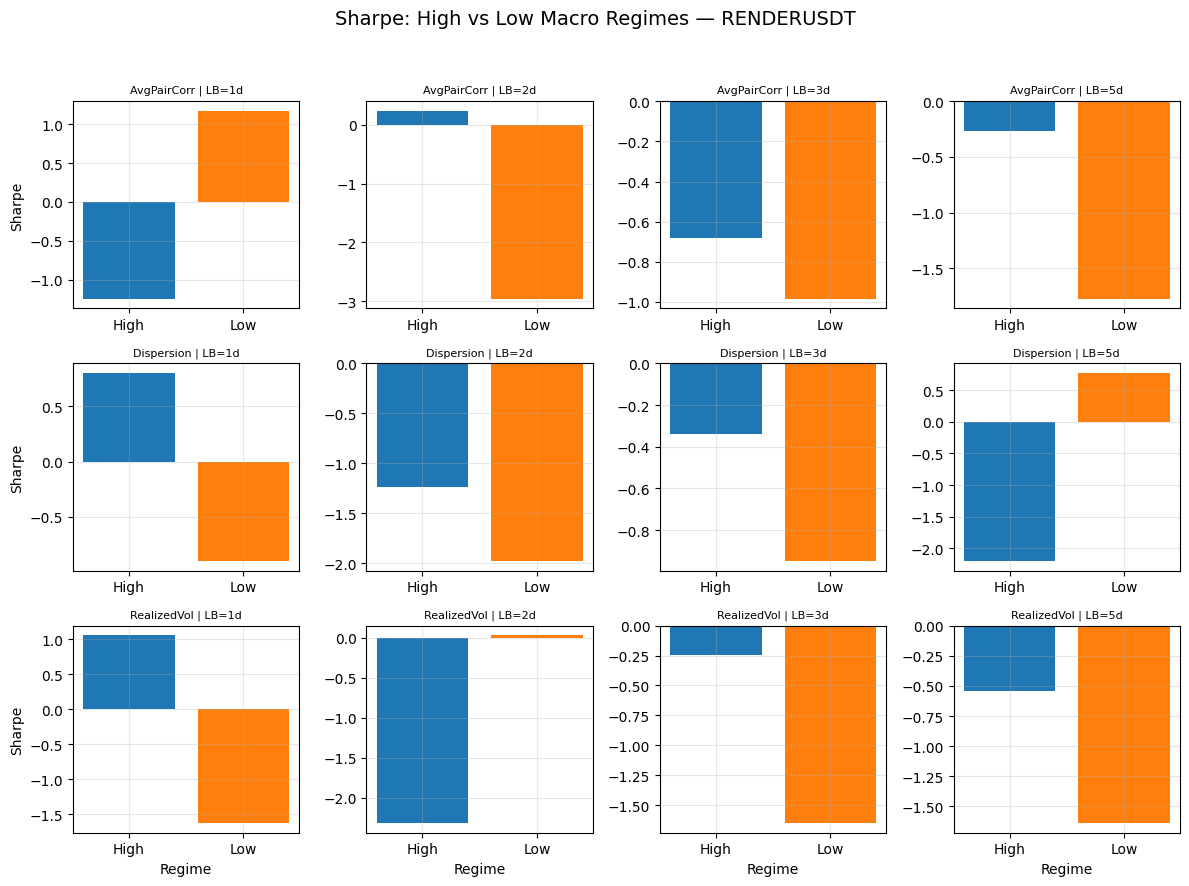

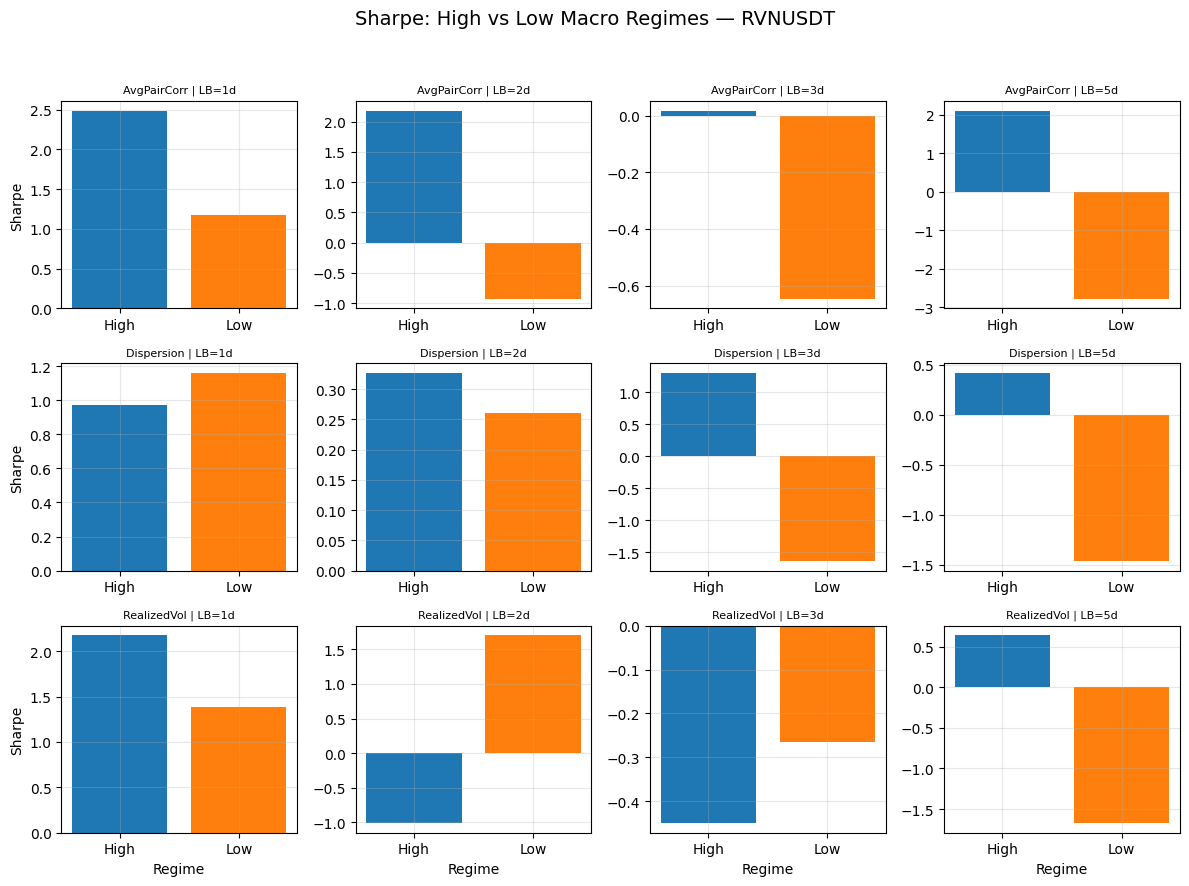

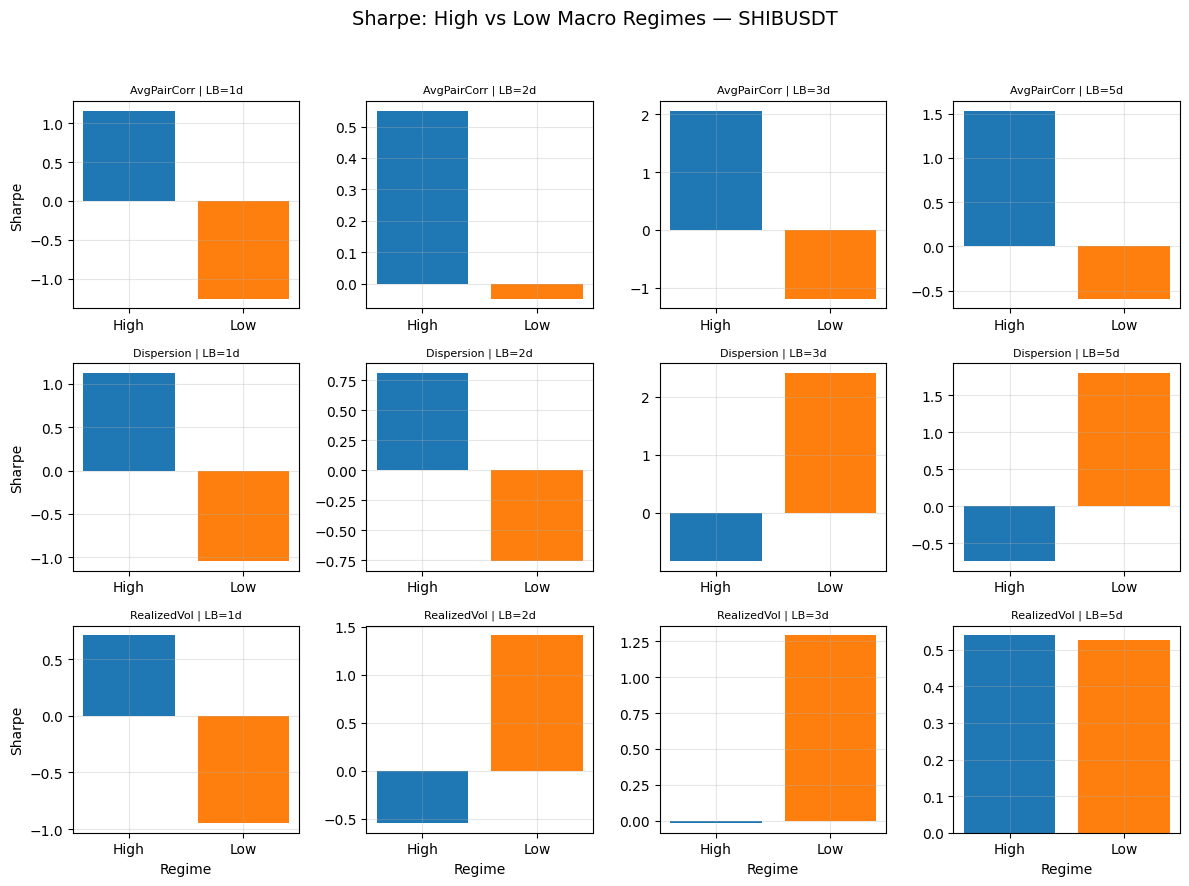

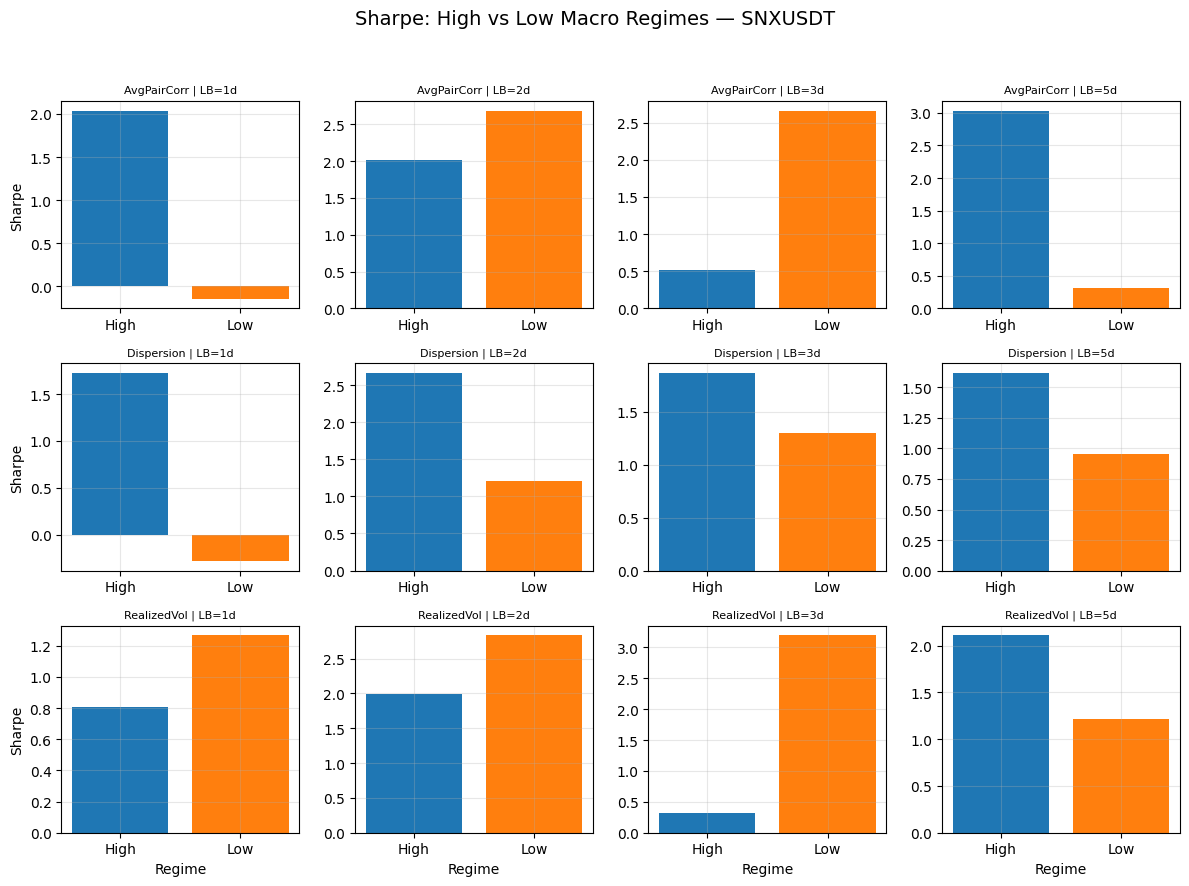

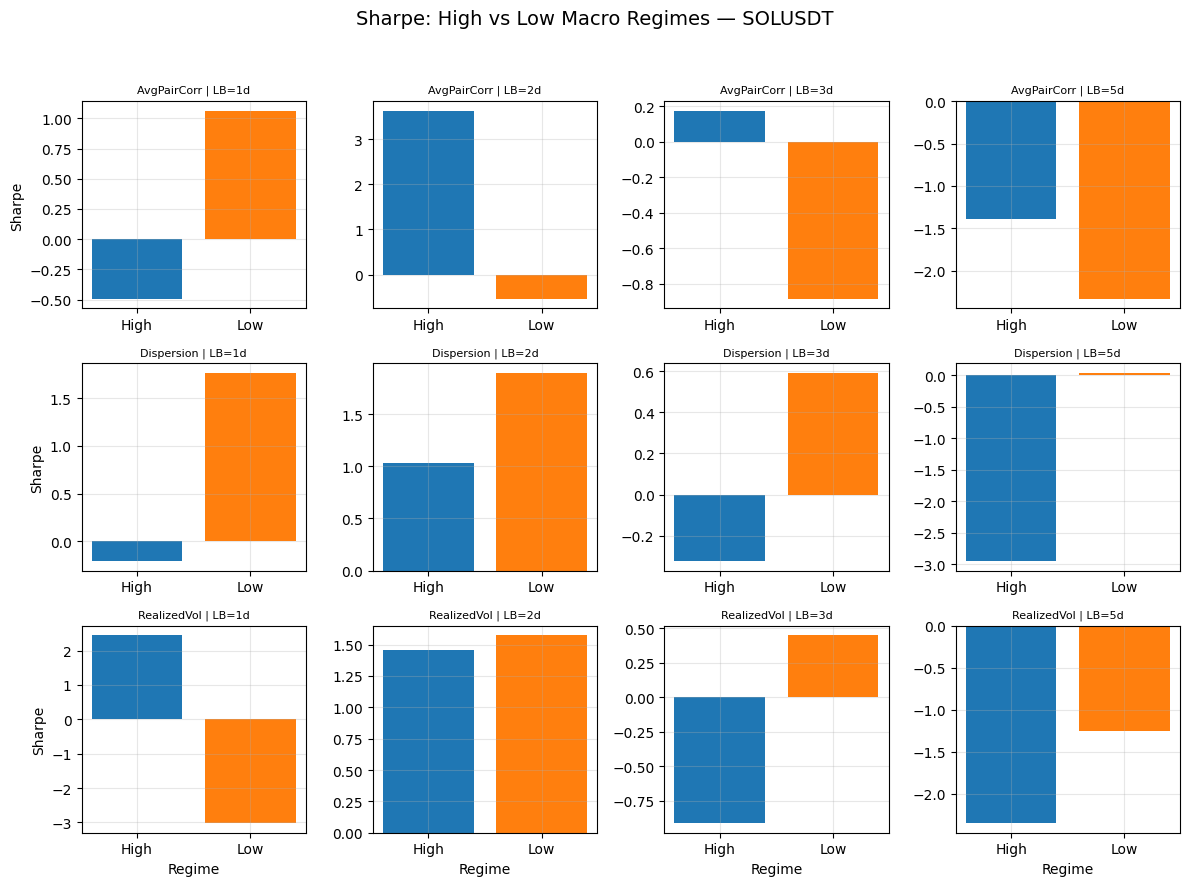

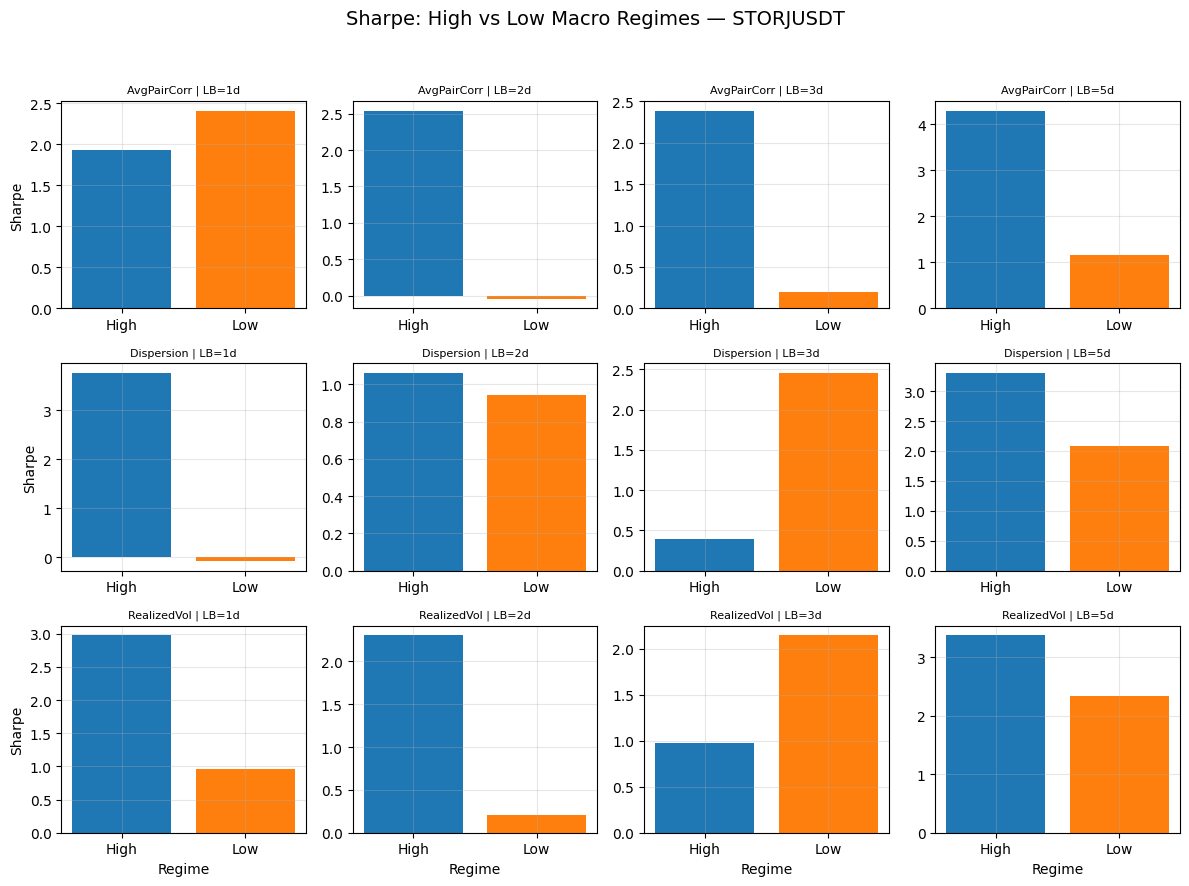

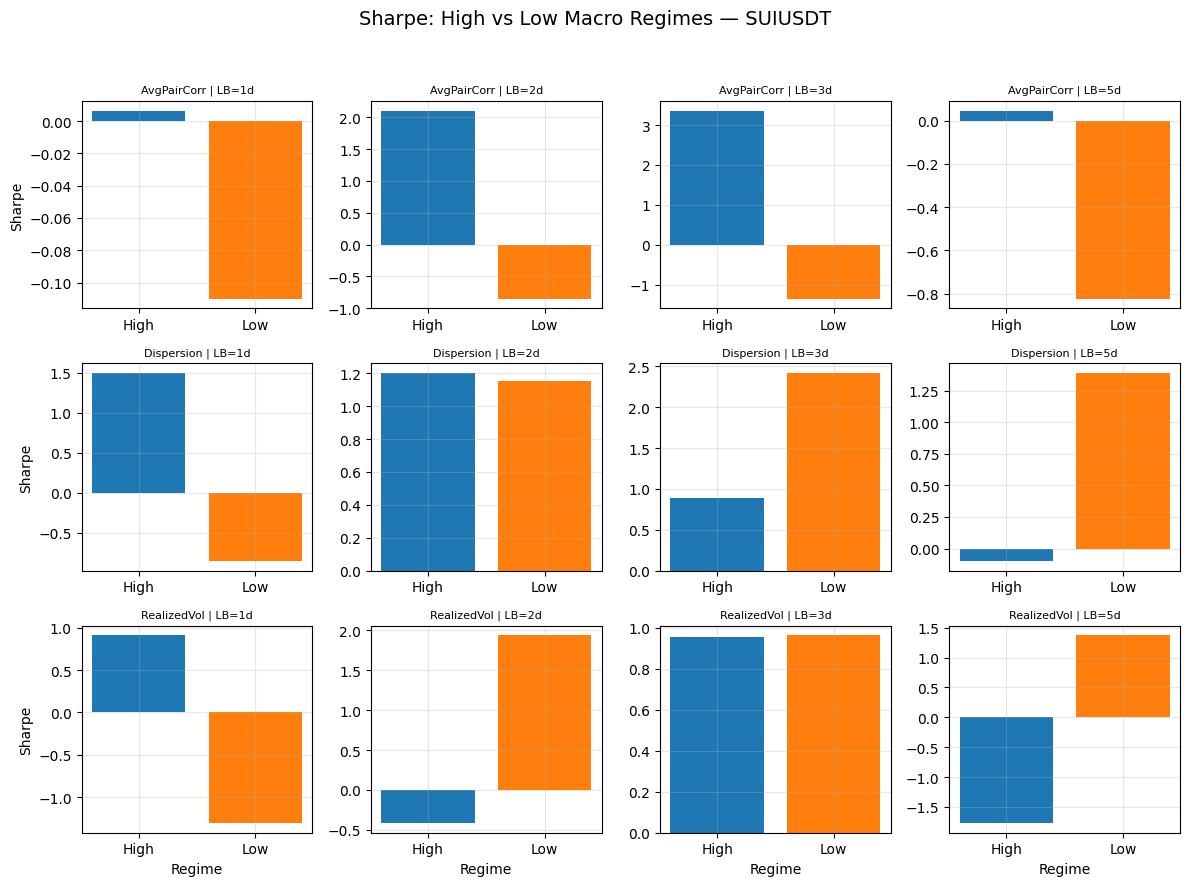

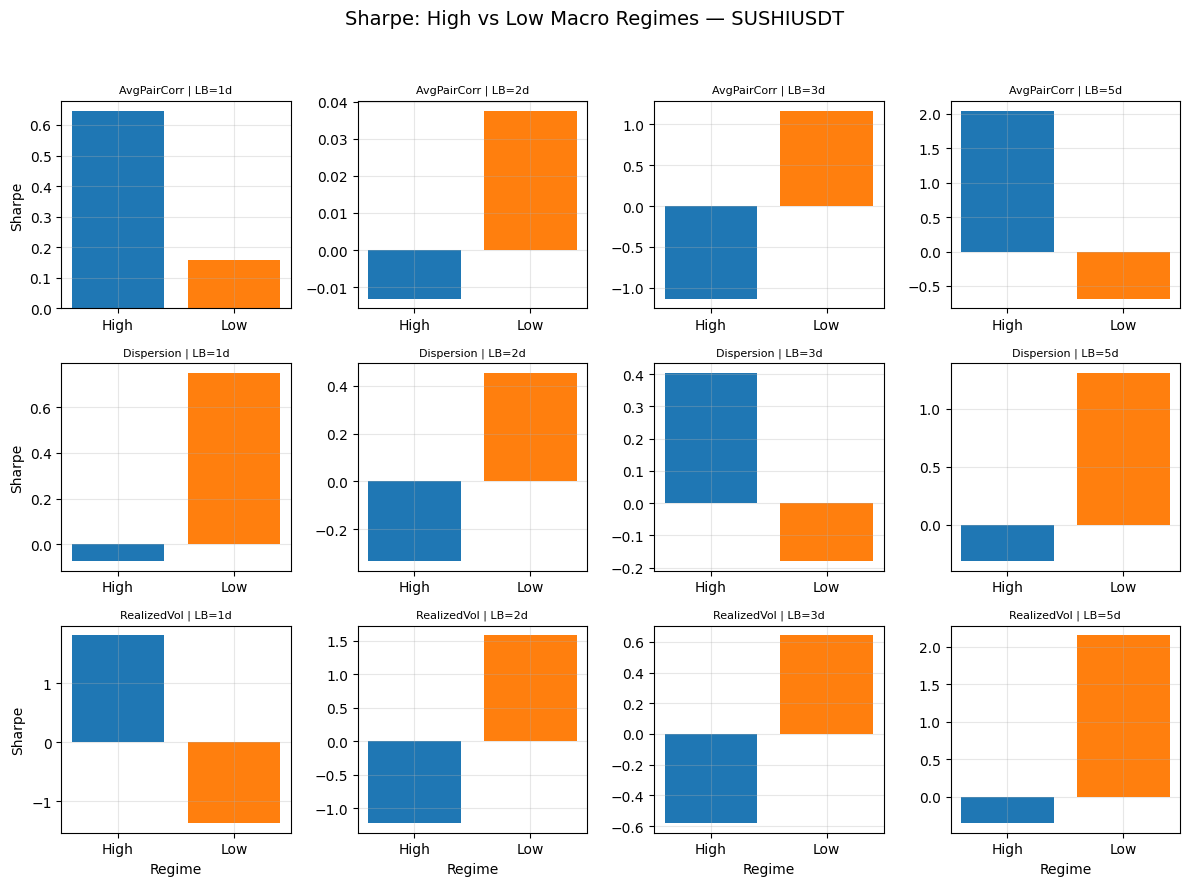

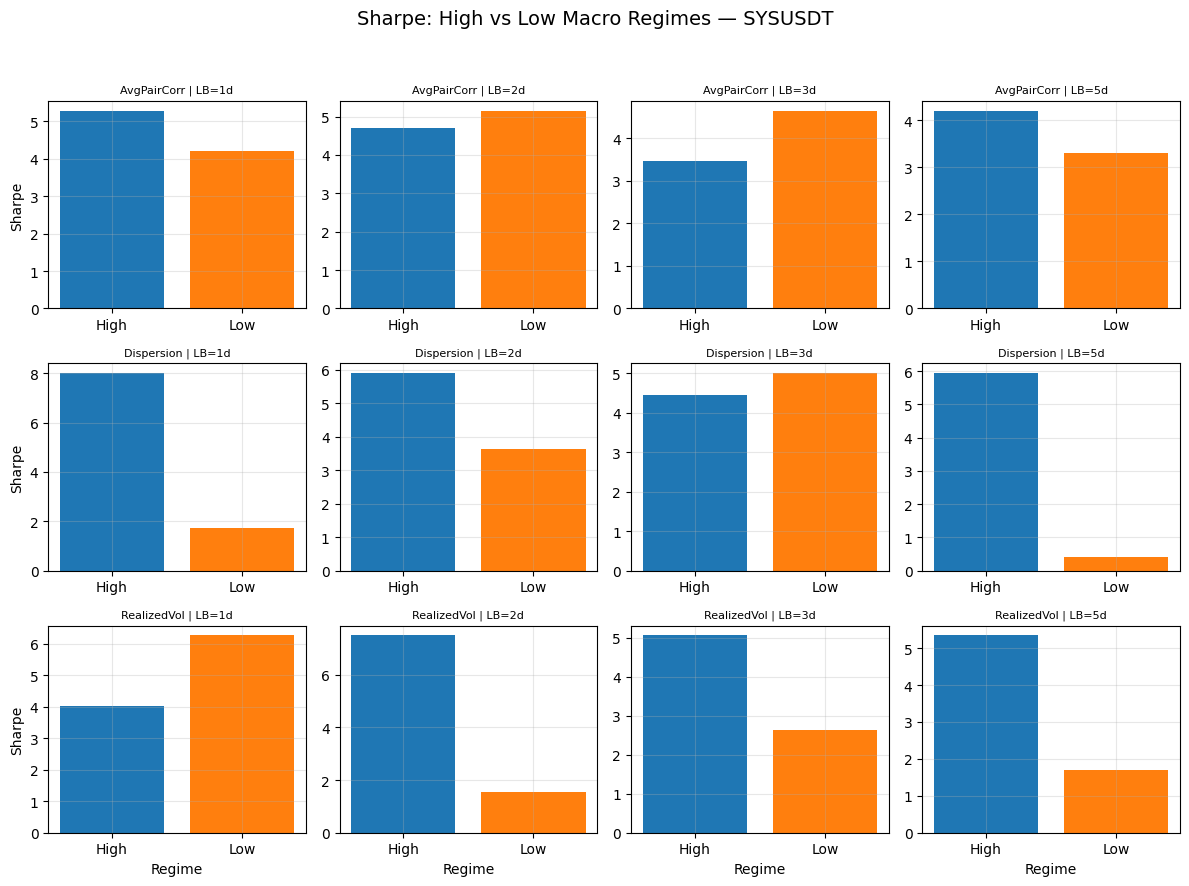

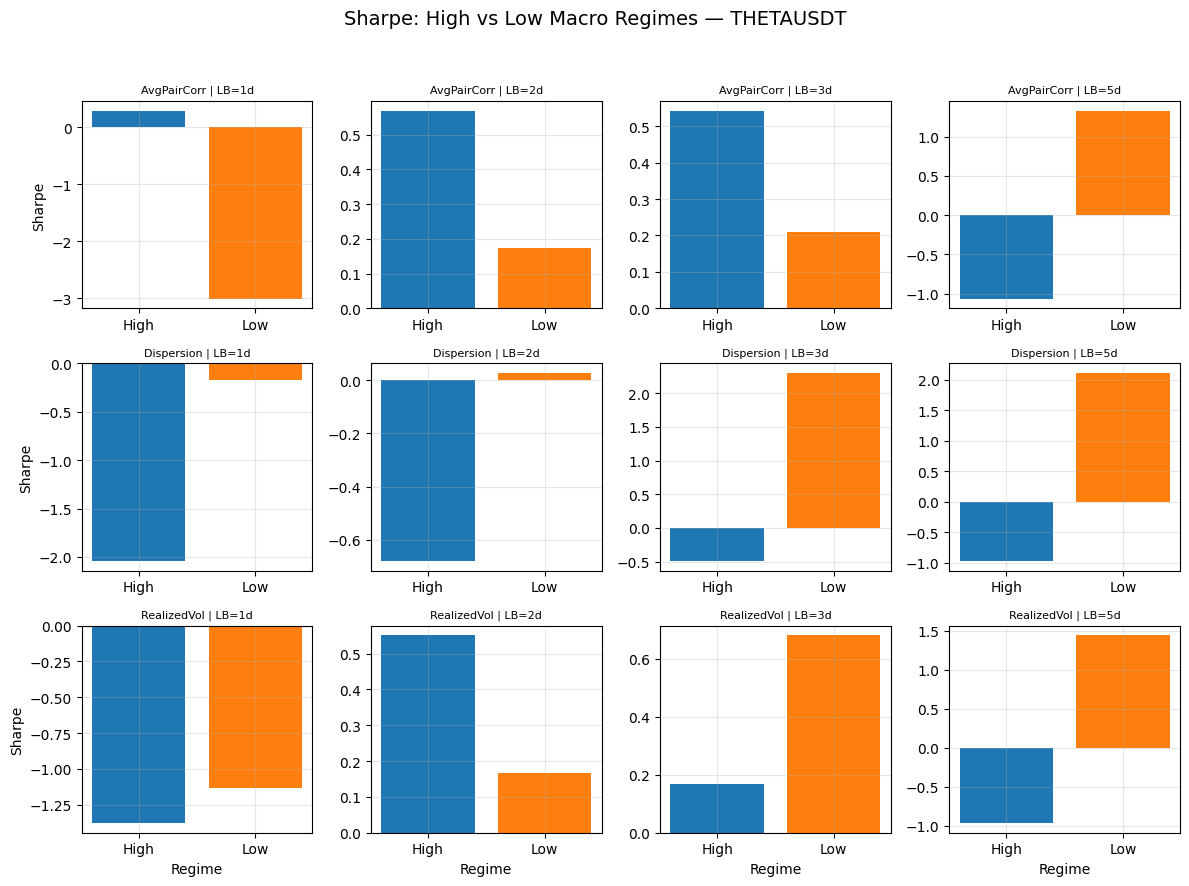

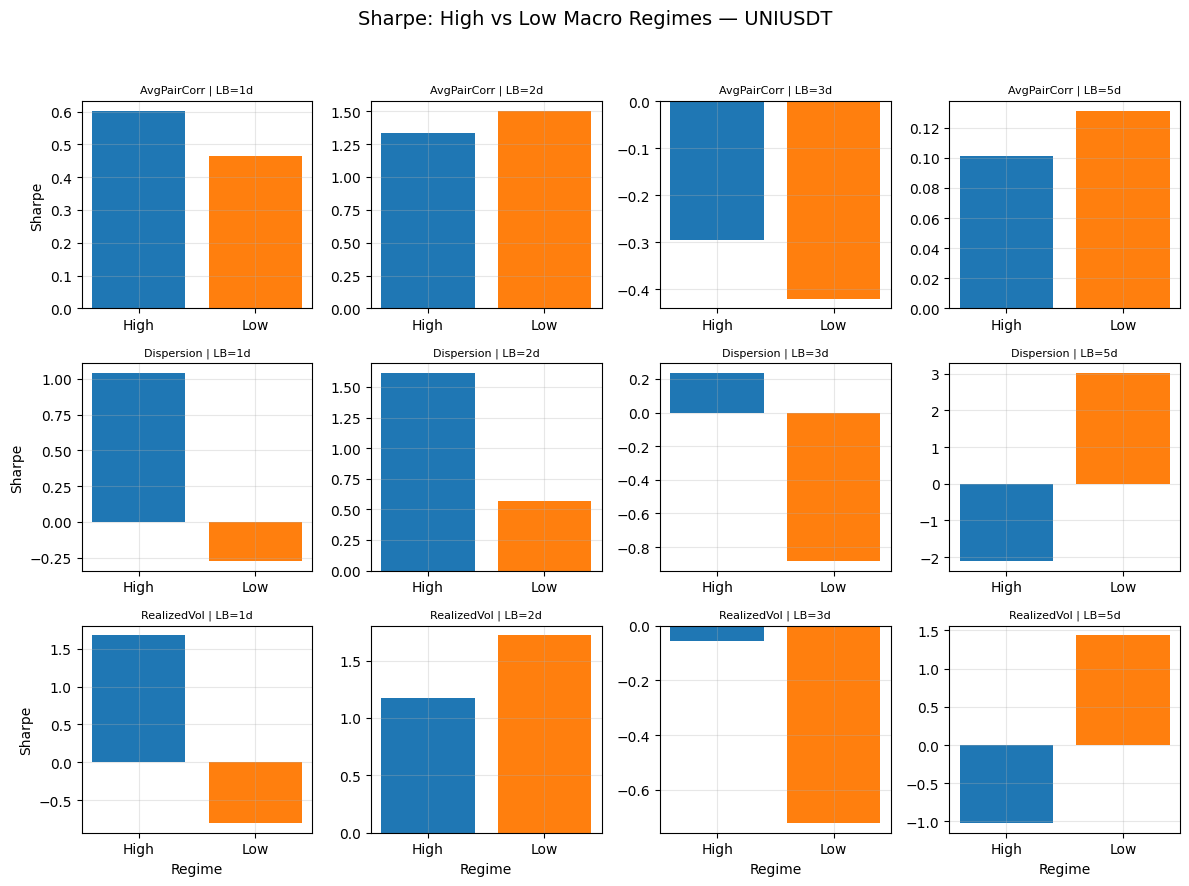

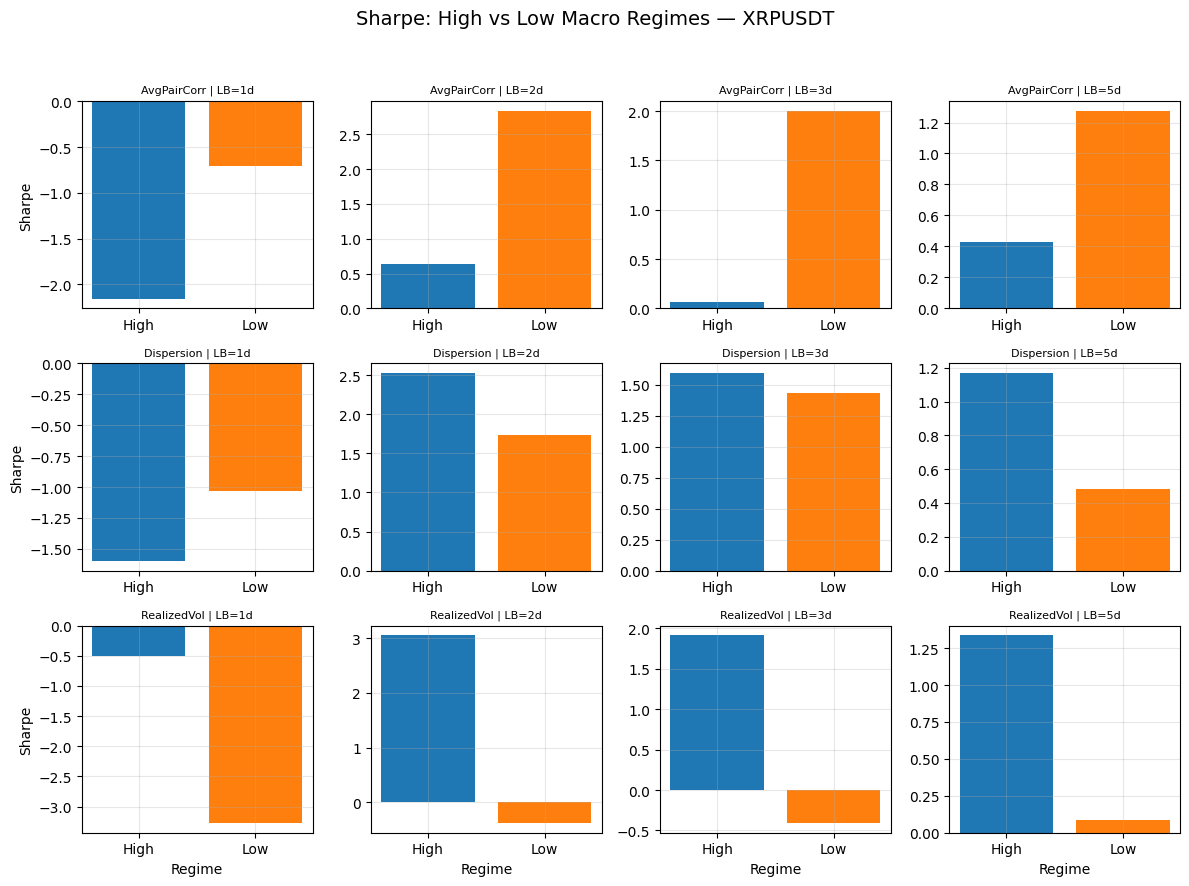

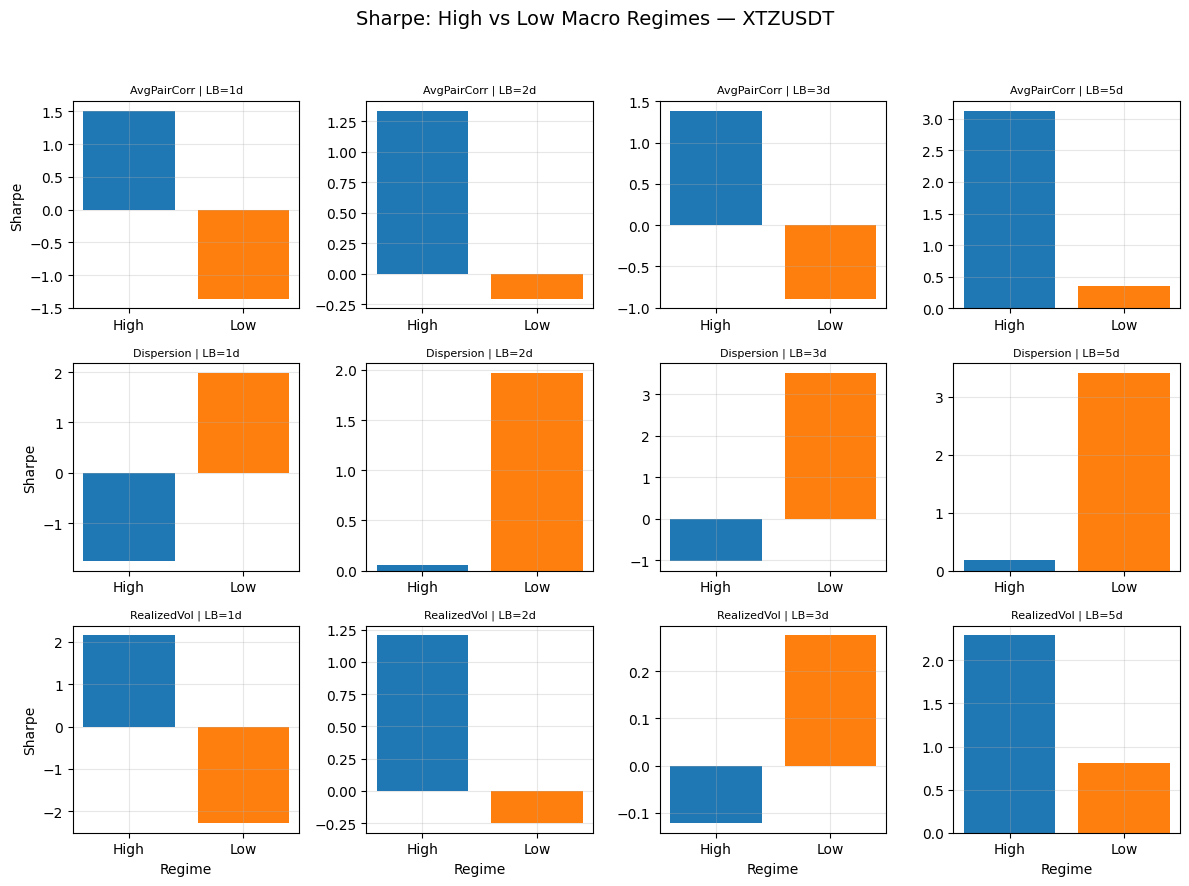

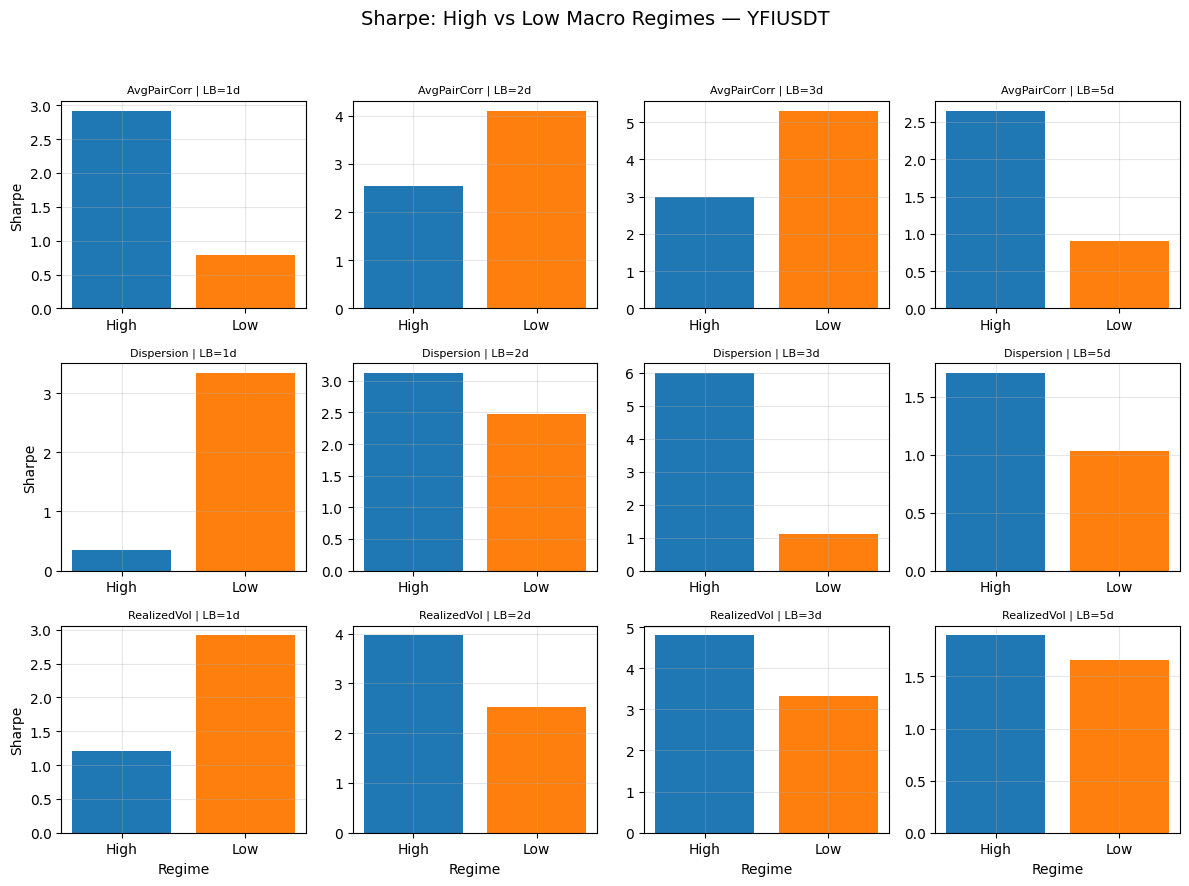

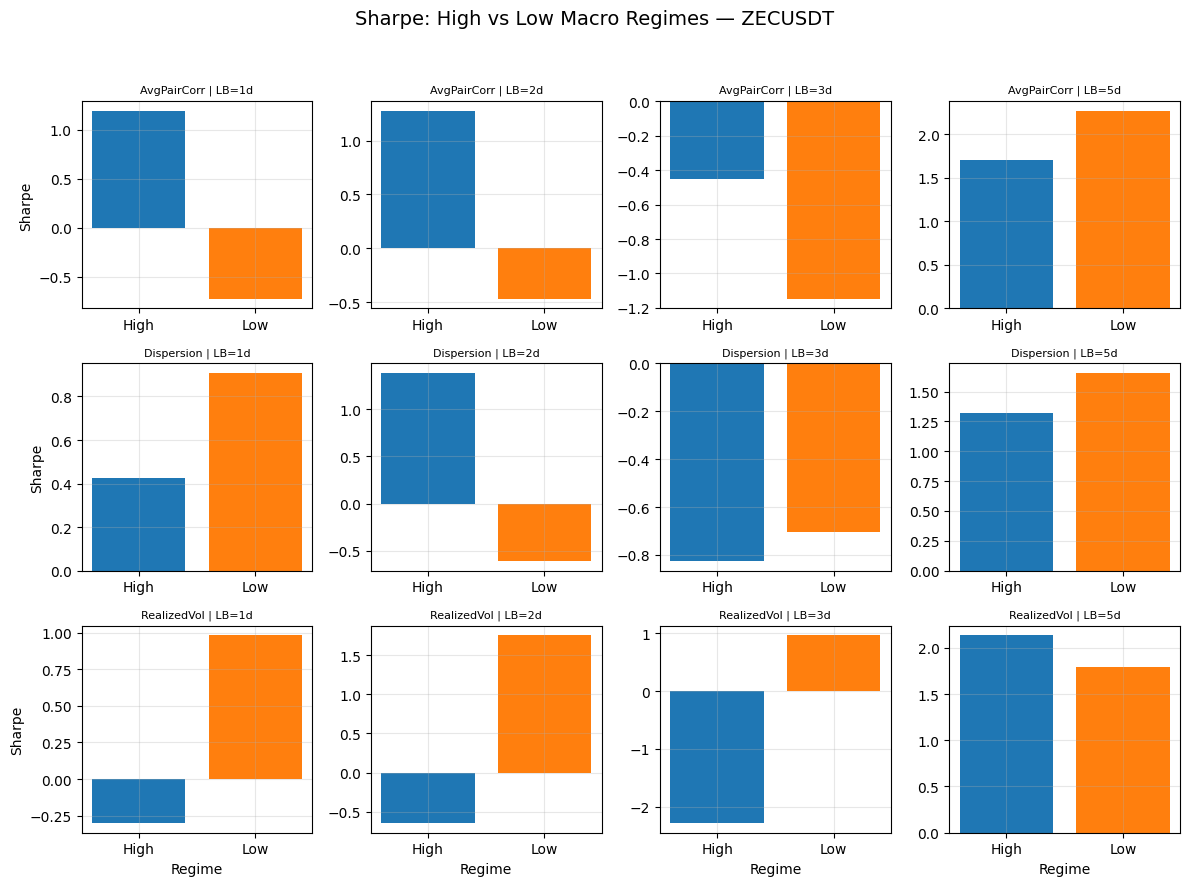

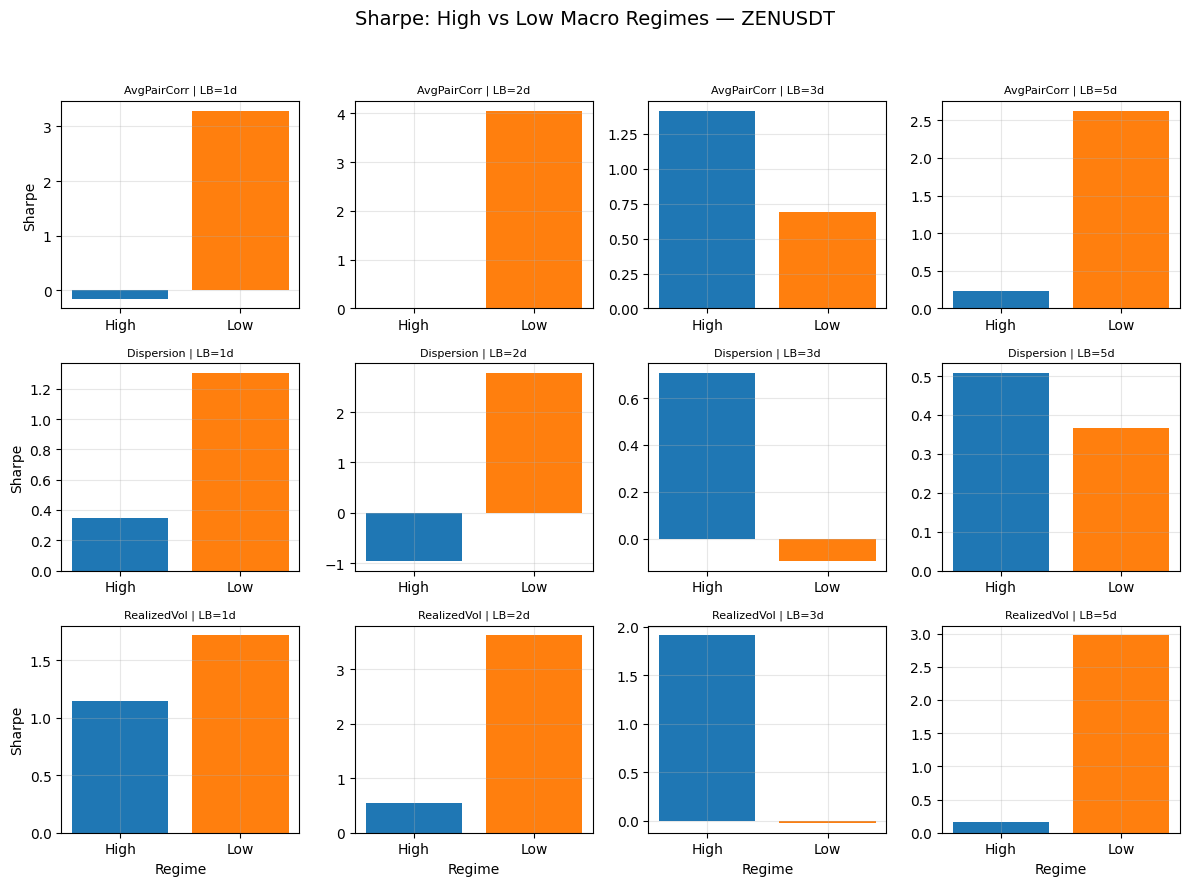

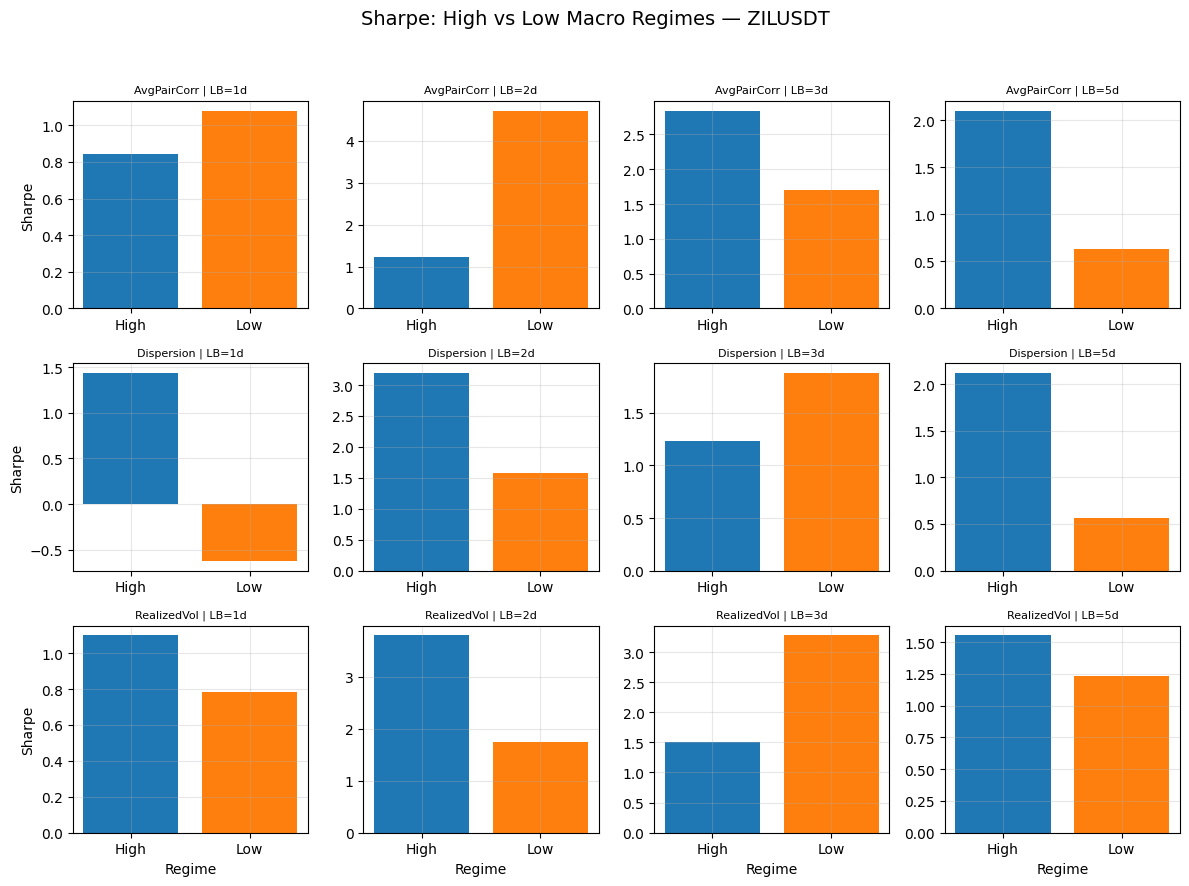

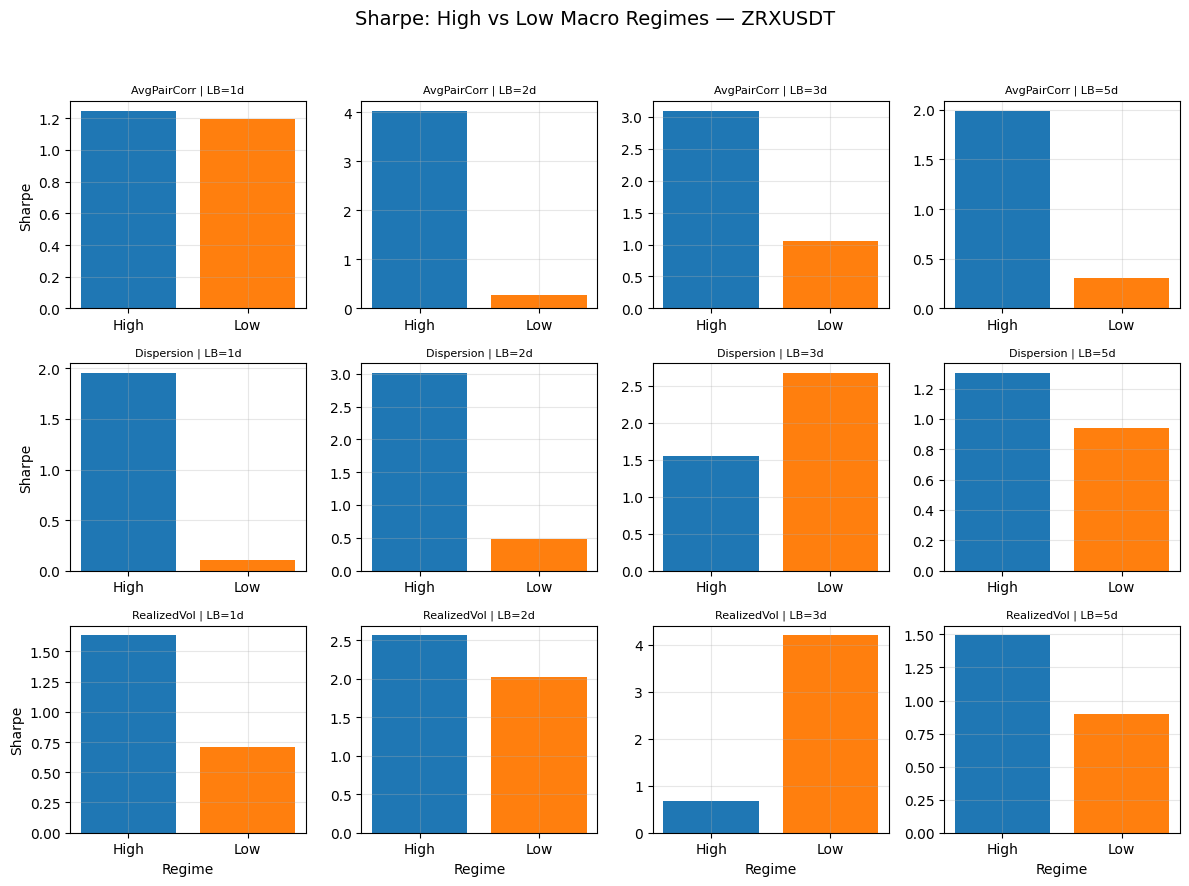

In [32]:
# 0) Universe & parameters
symbols = UNIVERSE
lookbacks = [1, 2, 3, 5]
window = 21                 # macro look-back (21d)

# 1) Ensure every symbol is in prices / rets  -------------------------------
missing = [s for s in symbols if s not in prices.columns]
if missing:
    print("Fetching missing coins:", ", ".join(missing))
    for sym in missing:
        try:
            df_px = get_px(sym, interval='1d', start='1 Jan 2020')
            prices[sym] = df_px['close']
            print(f"  ✓ {sym} added")
        except Exception as e:
            print(f"  ✗ {sym} failed → {e}")

# rebuild returns
prices = prices.sort_index().ffill()
rets   = np.log(prices / prices.shift(1)).dropna()

# drop any still-missing tickers from symbols
symbols = [s for s in symbols if s in rets.columns]

# 2) Macro indicators ------------------------------------------------------
real_vol   = rets['BTCUSDT'].rolling(window).std()
dispersion = rets[symbols].std(axis=1)

# average pairwise corr (21-day)
avg_pair_corr = pd.Series(index=rets.index, dtype=float)
n = len(symbols)
for i in range(window-1, len(rets)):
    mat = rets[symbols].iloc[i-window+1:i+1].corr().values
    avg_pair_corr.iloc[i] = mat[np.triu_indices(n, k=1)].mean()


indicators = {
    'RealizedVol':  real_vol,
    'Dispersion':   dispersion,
    'AvgPairCorr':  avg_pair_corr
}
# ── optional implied vol series named impl_vol ──
if 'impl_vol' in globals():
    indicators['ImpliedVol'] = impl_vol.reindex(rets.index)

# 3) Reversal PnL helper ---------------------------------------------------
def reversal_pnl(series: pd.Series, lb: int) -> pd.Series:
    signal = -series.rolling(lb).sum().shift(1)
    pos    = np.sign(signal)
    return (pos * series).dropna()

# 4) Loop & collect stats --------------------------------------------------
rows = []
for sym in symbols:
    for lb in lookbacks:
        pnl = reversal_pnl(rets[sym], lb)
        for ind_name, ind in indicators.items():
            ind = ind.reindex(pnl.index).dropna()
            med = ind.median()
            hi_idx = ind[ind >  med].index
            lo_idx = ind[ind <= med].index
            for regime, idx in [('High', hi_idx), ('Low', lo_idx)]:
                sub = pnl.reindex(idx).dropna()
                ann = sub.mean()*365
                vol = sub.std() * np.sqrt(365)
                sharpe = ann/vol if vol else np.nan
                mdd = (sub.cumsum().cummax() - sub.cumsum()).max()
                rows.append({
                    'Symbol': sym, 'Lookback': lb,
                    'Indicator': ind_name, 'Regime': regime,
                    'Sharpe': sharpe, 'AnnRet': ann, 'MaxDD': mdd
                })

df_macro = pd.DataFrame(rows)

# 5) Summary pivot ---------------------------------------------------------
print("Sharpe by Symbol × Lookback × Indicator (High vs Low)")
pivot = df_macro.pivot_table(
    index=['Symbol','Lookback','Indicator'],
    columns='Regime', values='Sharpe'
)

print(pivot.to_string())

# 6) Grid of bar-charts ----------------------------------------------------
syms = sorted(df_macro.Symbol.unique())
lbs  = sorted(df_macro.Lookback.unique())
inds = sorted(df_macro.Indicator.unique())


for sym in syms:
    fig, axes = plt.subplots(len(inds), len(lbs),
                             figsize=(3*len(lbs), 3*len(inds)),
                             squeeze=False)
    fig.suptitle(f'Sharpe: High vs Low Macro Regimes — {sym}', fontsize=14)
    for i, ind in enumerate(inds):
        for j, lb in enumerate(lbs):
            ax = axes[i][j]
            sub = df_macro[(df_macro.Symbol==sym)&
                           (df_macro.Lookback==lb)&
                           (df_macro.Indicator==ind)]
            sub = sub.set_index('Regime').reindex(['High','Low'])
            ax.bar(sub.index, sub.Sharpe,
                   color=['tab:blue','tab:orange'])
            ax.set_title(f'{ind} | LB={lb}d', fontsize=8)
            ax.grid(True, alpha=0.3)
            if i==len(inds)-1: ax.set_xlabel('Regime')
            if j==0:           ax.set_ylabel('Sharpe')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

---
## 20  Strategy Weighting & Portfolio Blend
 Auto-discovers all Series named like '*pnl*' in globals(), builds a combined DataFrame `strat_pnls`, then blends via:
   - Equal notional
   - Sharpe-weighted
   - Equal-risk-contribution
   - Inverse-vol (63-day σ)

 All portfolios are scaled to 10 % target annualised vol.

Strategies used: ['Mom21', 'Rev2', 'Spike']



Sharpe-weighted weights



Risk-Parity weights


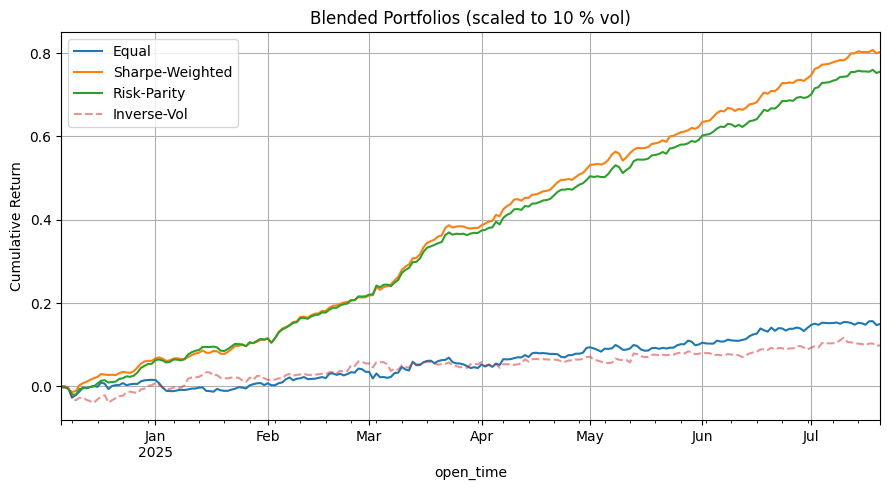

In [33]:
strategy_pnls = {
    'Mom21' : pnl_mom21,                            # <-- replace with your var
    'Rev2'  : pnl_rev2,
    'Spike' : pnl_daily.resample('D').sum(),     # intraday → daily
}
strat_pnls = pd.concat(strategy_pnls, axis=1).dropna()
print("Strategies used:", list(strat_pnls.columns))

# 1) ------------------------------------------------ helpers
def perf(x):
    ann_r = x.mean()*365
    ann_v = x.std()*np.sqrt(365)
    return pd.Series({'AnnRet':ann_r, 'AnnVol':ann_v,
                      'Sharpe':ann_r/ann_v if ann_v else np.nan,
                      'MaxDD': (x.cumsum().cummax()-x.cumsum()).max()})

def scale(x, target=0.10):
    v = x.std()*np.sqrt(365);  return x if v==0 else x*target/v

def erc(cov, tol=1e-8, it=500):
    w = np.ones(len(cov))/len(cov)
    for _ in range(it):
        rc = w*(cov@w); diff = rc-rc.mean()
        if np.abs(diff).max()<tol: break
        w -= 0.1*diff/rc.mean(); w=np.clip(w,0,None); w/=w.sum()
    return w

window = min(365, len(strat_pnls))   # shrink window for short history

# 2) ------------------------------------------------ weights & blends
# Equal
w_eq = np.repeat(1/strat_pnls.shape[1], strat_pnls.shape[1])
p_eq = scale(strat_pnls @ w_eq)

# Sharpe-weighted (clip <0)
mu, sig = strat_pnls[-window:].mean(), strat_pnls[-window:].std()
sh_vec  = (mu/sig).clip(lower=0)
w_sh = sh_vec/sh_vec.sum() if sh_vec.sum()>0 else w_eq
p_sh = scale(strat_pnls @ w_sh)

# Risk-parity
cov = strat_pnls[-window:].cov().values
w_rp = erc(cov);  p_rp = scale(strat_pnls @ w_rp)

# Inverse-vol (63-day; fallback to full sample)
sig63 = strat_pnls.rolling(63).std().iloc[-1] if len(strat_pnls)>=63 else strat_pnls.std()
w_iv  = (1/sig63)/(1/sig63).sum();  p_iv = scale(strat_pnls @ w_iv)

# 3) ------------------------------------------------ summary
summary = pd.concat({
    'Equal'          : perf(p_eq),
    'Sharpe-Weighted': perf(p_sh),
    'Risk-Parity'    : perf(p_rp),
    'Inverse-Vol'    : perf(p_iv)
}, axis=1).T
display(summary.style.format("{:.2%}"))

print("\nSharpe-weighted weights")
display(pd.Series(w_sh, index=strat_pnls.columns, name='Weight')
        .to_frame().style.format("{:.2%}"))

print("\nRisk-Parity weights")
display(pd.Series(w_rp, index=strat_pnls.columns, name='Weight')
        .to_frame().style.format("{:.2%}"))

# 4) ------------------------------------------------ plot
plt.figure(figsize=(9,5))
p_eq.cumsum().plot(label='Equal')
p_sh.cumsum().plot(label='Sharpe-Weighted')
p_rp.cumsum().plot(label='Risk-Parity')
p_iv.cumsum().plot(label='Inverse-Vol', ls='--', alpha=0.5)
plt.title('Blended Portfolios (scaled to 10 % vol)')
plt.ylabel('Cumulative Return')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

---
## 21  Short Term Momentum

In [34]:
def get_binance_px(symbol,freq):
    data = _client.get_historical_klines(symbol,freq, 0)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.fromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.fromtimestamp(x/1000))
    return data 

In [35]:
def compute_sr_with_momentum_strategy(universe, freq_list):
    for freq in freq_list:
        print(f'Computing SR with momentum strategy for frequency: {freq}')
        px = {}
        for x in universe:
            data = get_binance_px(x,freq)
            px[x] = data.set_index('open_time')['close']

        px = pd.DataFrame(px).astype(float)
        px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
        ret = px.pct_change()
        ret.describe(include='all')
        
        strats = {}
        for hor in [1,2,3,4,5]:
            avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
            avg_ret = ret.rolling(hor,min_periods=1).mean()
            avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
            avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
            strats[hor] = (avg_ret.shift()*ret).sum(1)
        strats = pd.DataFrame(strats)
        print(strats)
        
        # sr = strats.mean()/strats.std()*np.sqrt(365)
        sr = (strats.mean()/strats.std()*np.sqrt(pd.Timedelta('365d')/pd.Timedelta(freq)))
        print("Sharp ratios with lag: \n", sr)
        # sr = strats.resample('YE').mean()/strats.resample('YE').std()*np.sqrt(365)
        sr = strats.resample('YE').mean()/strats.resample('YE').std()*np.sqrt(pd.Timedelta('365d')/pd.Timedelta(freq))
        sr.plot(kind='bar')
        plt.title(f'SR with momentum strategy for frequency: {freq}')
        plt.show()

        # Introducing Lag of 1 bar
        strats_lag = {}
        for hor in [1,2,3,4,5]:
            avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
            avg_ret = ret.rolling(hor,min_periods=1).mean()
            avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
            avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
            strats_lag[hor] = (avg_ret.shift(2)*ret).sum(1)
        strats_lag = pd.DataFrame(strats_lag)

        # sr_lag = strats_lag.mean()/strats_lag.std()*np.sqrt(365)
        sr_lag = strats_lag.mean()/strats_lag.std()*np.sqrt(pd.Timedelta('365d')/pd.Timedelta(freq))
        print("Sharp ratios with lag: \n", sr_lag)
        # sr_lag = strats_lag.resample('YE').mean()/strats_lag.resample('YE').std()*np.sqrt(365)
        sr_lag = strats_lag.resample('YE').mean()/strats_lag.resample('YE').std()*np.sqrt(pd.Timedelta('365d')/pd.Timedelta(freq))
        sr_lag.plot(kind='bar')
        plt.title(f'SR with 1 bar lag momentum strategy for frequency: {freq}')
        plt.show()

Computing SR with momentum strategy for frequency: 1h
                            1         2         3         4         5
2019-09-23 01:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 02:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 03:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 04:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 05:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
...                       ...       ...       ...       ...       ...
2025-07-20 08:00:00 -0.003493 -0.007381 -0.010629 -0.025972 -0.025606
2025-07-20 09:00:00 -0.003055 -0.003526 -0.004576 -0.004851 -0.006327
2025-07-20 10:00:00  0.003407 -0.000465  0.000756 -0.002060  0.001737
2025-07-20 11:00:00 -0.004086  0.000946 -0.000782 -0.001027 -0.000345
2025-07-20 12:00:00  0.000644  0.000111 -0.000441 -0.000335 -0.000364

[51060 rows x 5 columns]
Sharp ratios with lag: 
 1   -13.402167
2   -10.728092
3   -10.521058
4   -10.60

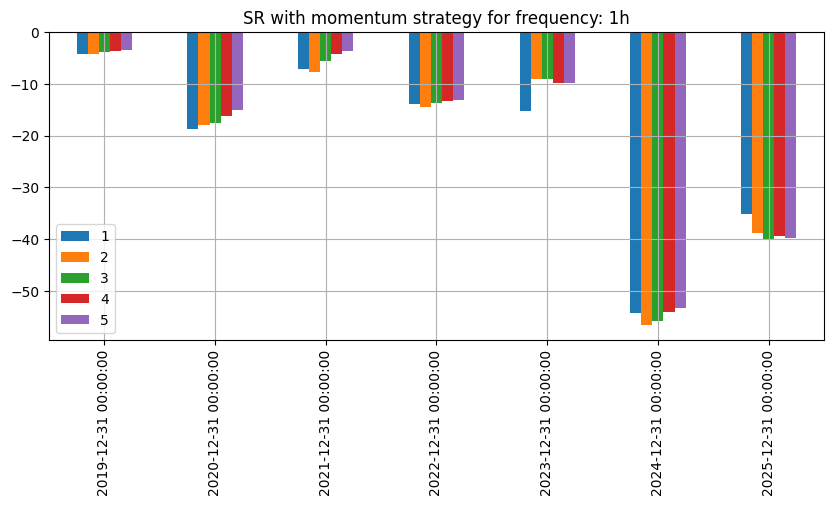

Sharp ratios with lag: 
 1   -4.768279
2   -5.400514
3   -5.780793
4   -5.803943
5   -5.430375
dtype: float64


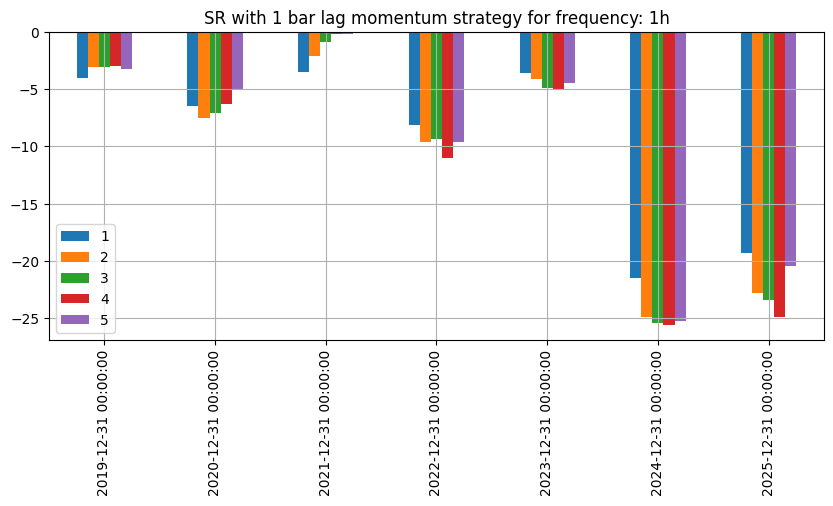

Computing SR with momentum strategy for frequency: 4h
                            1         2         3         4         5
2019-09-23 01:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 05:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 09:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 13:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 17:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
...                       ...       ...       ...       ...       ...
2025-07-19 17:00:00 -0.012722 -0.019980 -0.016427 -0.018070 -0.017380
2025-07-19 21:00:00 -0.001858 -0.001769  0.010065  0.016790  0.018539
2025-07-20 01:00:00 -0.004643 -0.005924 -0.008249 -0.007247  0.005645
2025-07-20 05:00:00 -0.018614 -0.016162 -0.019116 -0.015930 -0.006992
2025-07-20 09:00:00 -0.003960 -0.013637 -0.019533 -0.019712 -0.018116

[12765 rows x 5 columns]
Sharp ratios with lag: 
 1   -6.689823
2   -6.429283
3   -6.186792
4   -5.635592

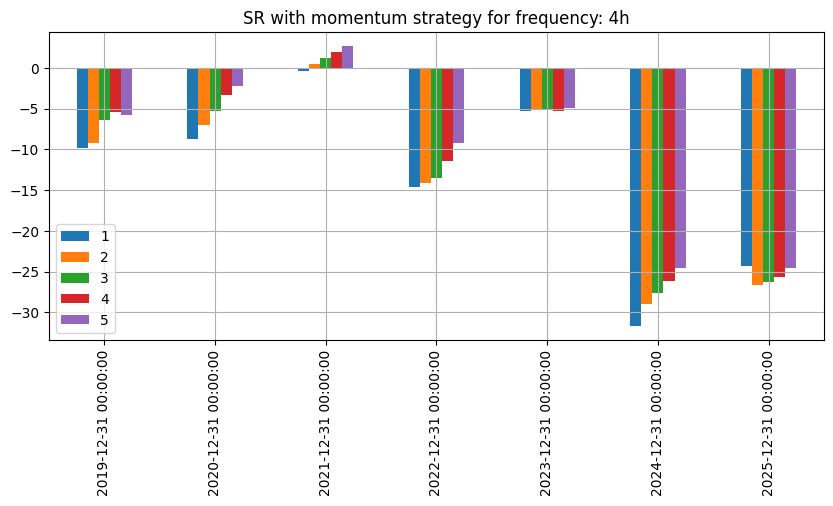

Sharp ratios with lag: 
 1   -2.548473
2   -2.708832
3   -1.923263
4   -1.488604
5   -2.165710
dtype: float64


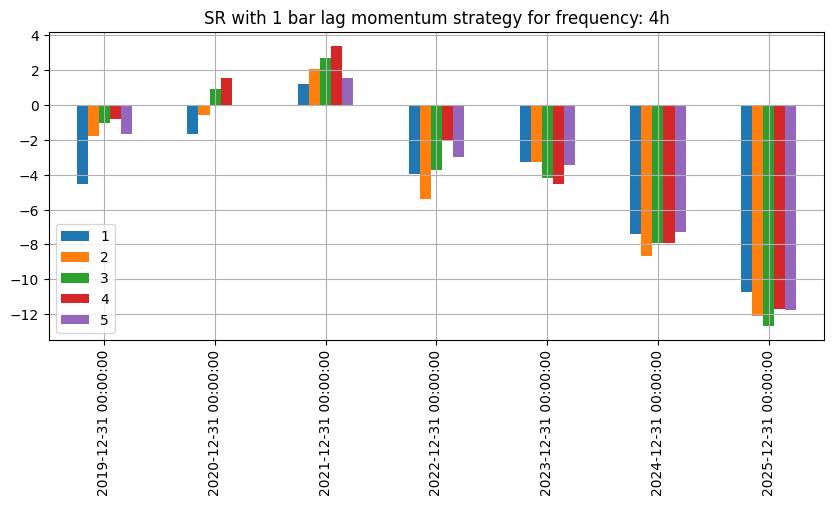

Computing SR with momentum strategy for frequency: 1d
                            1         2         3         4         5
2019-09-22 17:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-23 17:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-24 17:00:00  0.001966  0.001966  0.001966  0.001966  0.001966
2019-09-25 17:00:00  0.012923  0.012166  0.012166  0.012166  0.012166
2019-09-26 17:00:00 -0.025994 -0.030468 -0.017056 -0.017056 -0.017056
...                       ...       ...       ...       ...       ...
2025-07-15 17:00:00 -0.003031  0.003083  0.009344 -0.016886 -0.012430
2025-07-16 17:00:00  0.008182  0.012071  0.017077  0.036353  0.011351
2025-07-17 17:00:00 -0.021706 -0.017119 -0.020457 -0.016090 -0.017975
2025-07-18 17:00:00  0.001590  0.010704  0.001690  0.011344  0.004344
2025-07-19 17:00:00 -0.002077 -0.002346 -0.004137 -0.005711 -0.005530

[2128 rows x 5 columns]
Sharp ratios with lag: 
 1   -3.149971
2   -2.371752
3   -1.827006
4   -1.367362


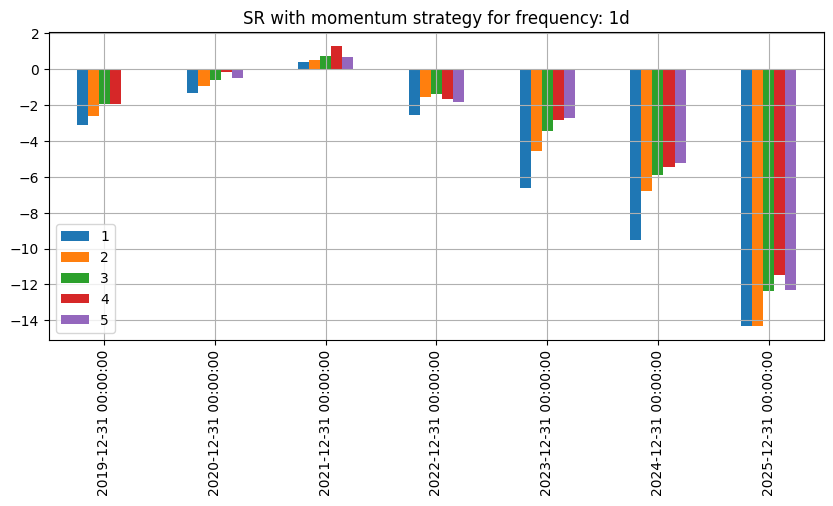

Sharp ratios with lag: 
 1   -0.276186
2    0.094914
3    0.272695
4   -0.225430
5    0.019176
dtype: float64


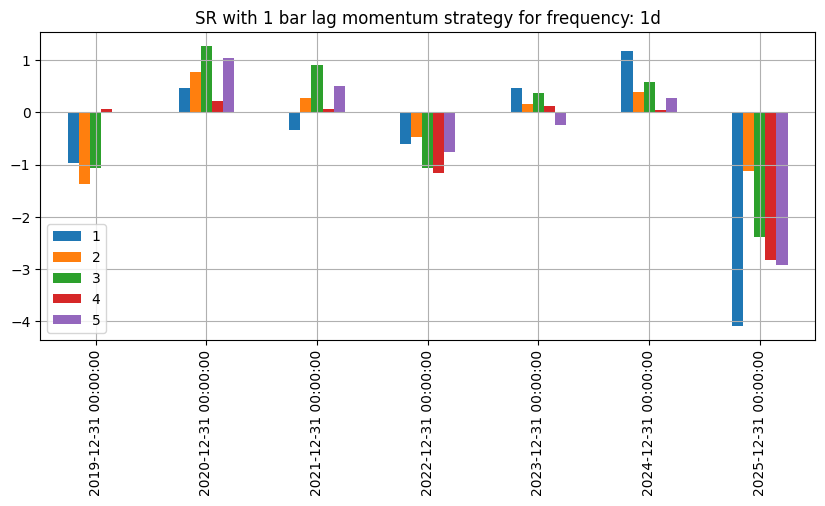

Computing SR with momentum strategy for frequency: 1w
                            1         2         3         4         5
2019-09-22 17:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-09-29 17:00:00  0.000000  0.000000  0.000000  0.000000  0.000000
2019-10-06 17:00:00  0.005116  0.005116  0.005116  0.005116  0.005116
2019-10-13 17:00:00  0.048370  0.059650  0.059650  0.059650  0.059650
2019-10-20 17:00:00 -0.058440 -0.091541 -0.082059 -0.082059 -0.082059
...                       ...       ...       ...       ...       ...
2025-06-15 17:00:00 -0.000717 -0.012142 -0.006166 -0.004052  0.000159
2025-06-22 17:00:00 -0.051519 -0.041314 -0.041352 -0.045921 -0.040732
2025-06-29 17:00:00 -0.001447 -0.004953 -0.010109 -0.013975 -0.008615
2025-07-06 17:00:00 -0.018043 -0.020387 -0.014824 -0.046092 -0.045556
2025-07-13 17:00:00 -0.004323 -0.003143  0.010718  0.000883 -0.009122

[304 rows x 5 columns]
Sharp ratios with lag: 
 1    0.000322
2   -0.265874
3   -0.283851
4   -0.092351
5

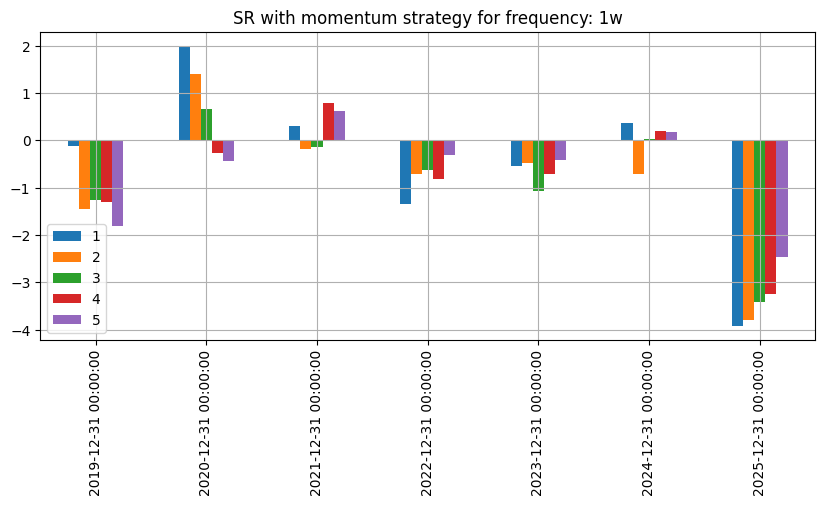

Sharp ratios with lag: 
 1   -0.486170
2   -0.529744
3   -0.222446
4   -0.114385
5   -0.208252
dtype: float64


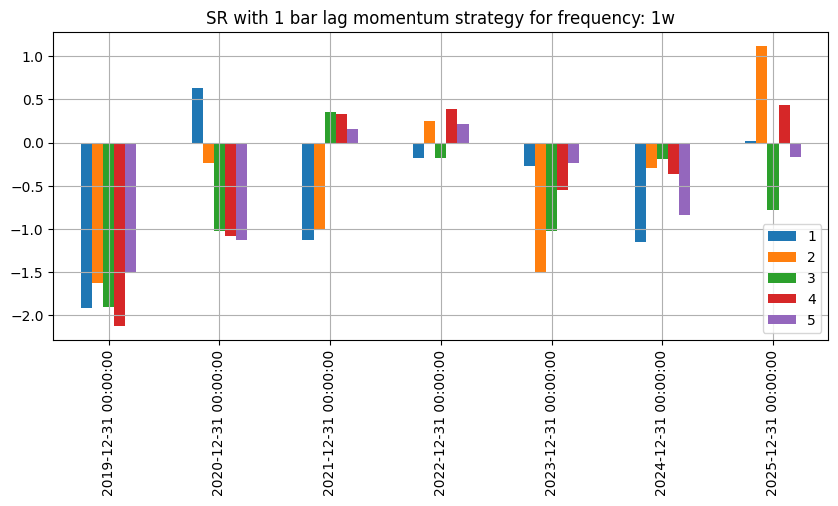

In [36]:
compute_sr_with_momentum_strategy(UNIVERSE, FREQ_LIST)

---
## 22 Short Term Reversal

In [37]:
def compute_sr_with_reversal_strategy(universe, freq_list):
    for freq in freq_list:
        print(f'Computing SR with reversal strategy for frequency: {freq}')
        px = {
            sym: get_binance_px(sym, freq)
                  .set_index('open_time')['close'].astype(float)
            for sym in universe
        }
        px = pd.DataFrame(px)
        px = px.reindex(pd.date_range(px.index[0], px.index[-1], freq=freq))
        
        ret = px.pct_change()

        strats = {}
        for hor in [1, 2, 3, 4, 5]:
            # mean return over look-back window
            avg_ret = ret.rolling(hor, min_periods=1).mean()
            
            # demean across universe, flip sign ⇒ buy losers / short winners
            w = -(avg_ret.sub(avg_ret.mean(axis=1), axis=0))
            # L1-normalise ⇒ dollar-neutral, leverage = 1
            w = w.div(w.abs().sum(axis=1), axis=0)
            
            # same-bar execution (optimistic)
            strats[hor] = (w.shift() * ret).sum(axis=1)

        strats = pd.DataFrame(strats)

        # ---------- Sharpe ratios ----------
        ann_factor = np.sqrt(pd.Timedelta('365d') / pd.Timedelta(freq))
        sr_full = strats.mean() / strats.std() * ann_factor
        print('Full-sample SR:\n', sr_full)

        sr_year = (strats.resample('YE').mean() / strats.resample('YE').std()) * ann_factor
        sr_year.plot(kind='bar', title=f'Reversal SR by Horizon – {freq}')
        plt.show()

        # ---------- Add 1-bar lag ----------
        strats_lag = {}
        for hor in [1, 2, 3, 4, 5]:
            avg_ret = ret.rolling(hor, min_periods=1).mean()
            w = -(avg_ret.sub(avg_ret.mean(axis=1), axis=0))
            w = w.div(w.abs().sum(axis=1), axis=0)
            
            # two shifts: one for look-ahead bias removal (like above), one extra bar for lag
            strats_lag[hor] = (w.shift(2) * ret).sum(axis=1)

        strats_lag = pd.DataFrame(strats_lag)

        sr_full_lag = strats_lag.mean() / strats_lag.std() * ann_factor
        print('Full-sample SR (1-bar lag):\n', sr_full_lag)

        sr_year_lag = (strats_lag.resample('YE').mean() / strats_lag.resample('YE').std()) * ann_factor
        sr_year_lag.plot(kind='bar', title=f'Reversal SR (1-bar lag) – {freq}')
        plt.show()


Computing SR with reversal strategy for frequency: 1h
Full-sample SR:
 1    13.402287
2    10.728194
3    10.521158
4    10.605389
5    10.366560
dtype: float64


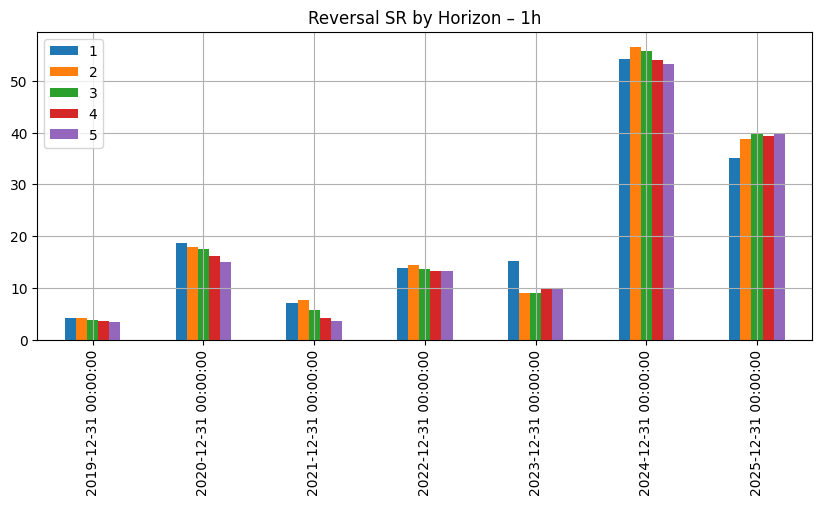

Full-sample SR (1-bar lag):
 1    4.768348
2    5.400615
3    5.780564
4    5.803671
5    5.430063
dtype: float64


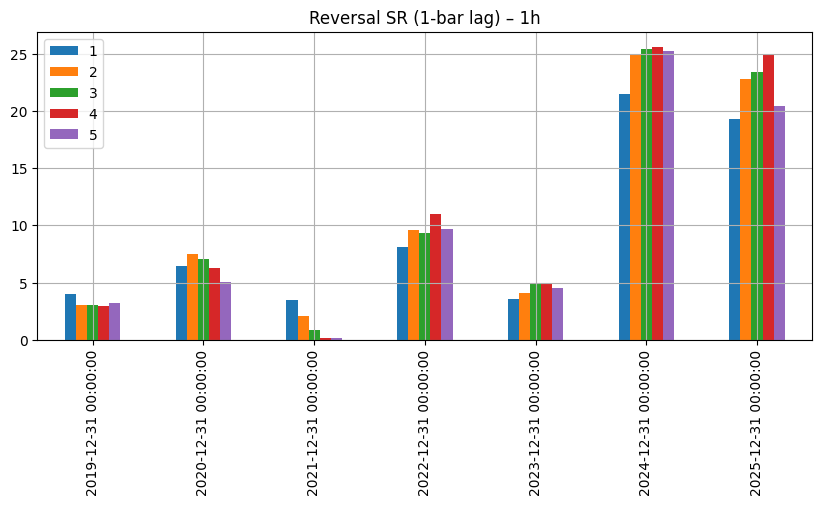

Computing SR with reversal strategy for frequency: 4h
Full-sample SR:
 1    6.689667
2    6.429373
3    6.186818
4    5.635826
5    4.984816
dtype: float64


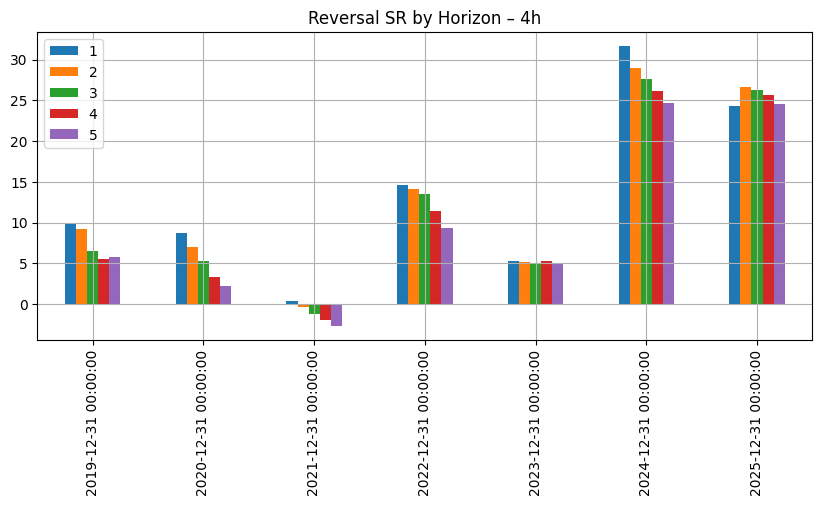

Full-sample SR (1-bar lag):
 1    2.549008
2    2.709154
3    1.923902
4    1.489169
5    2.165874
dtype: float64


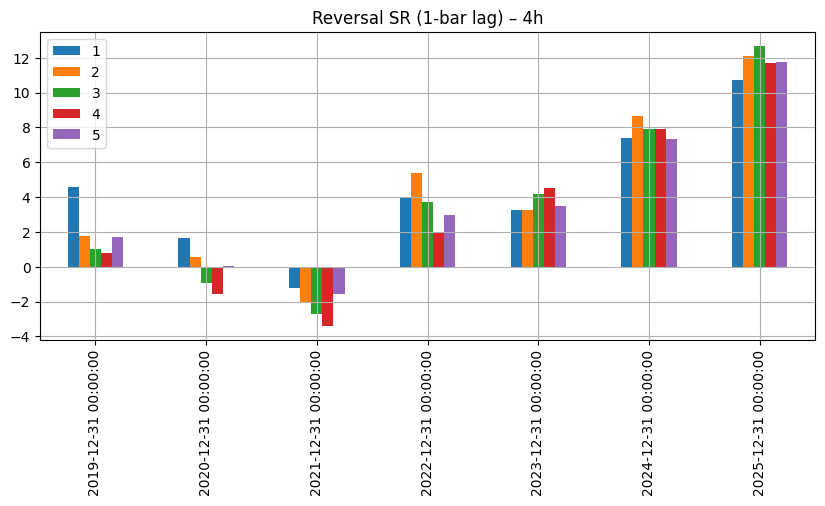

Computing SR with reversal strategy for frequency: 1d
Full-sample SR:
 1    3.149942
2    2.371765
3    1.826843
4    1.367122
5    1.573429
dtype: float64


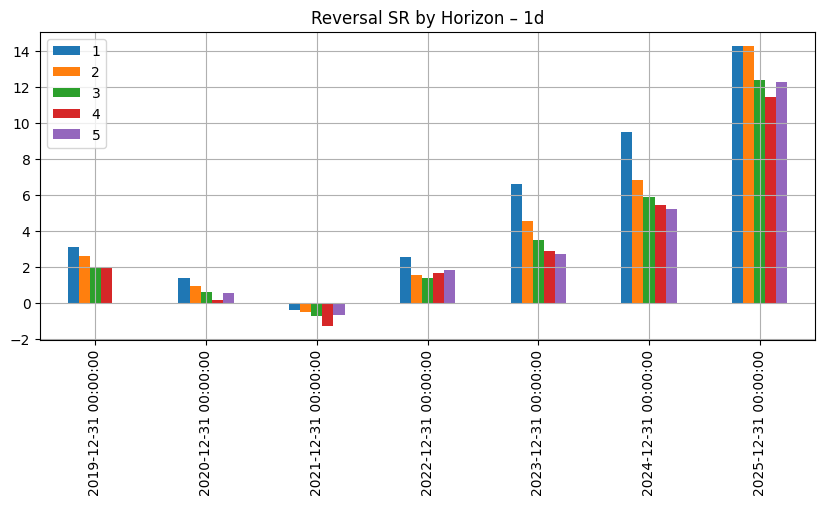

Full-sample SR (1-bar lag):
 1    0.276249
2   -0.095168
3   -0.273055
4    0.225211
5   -0.019559
dtype: float64


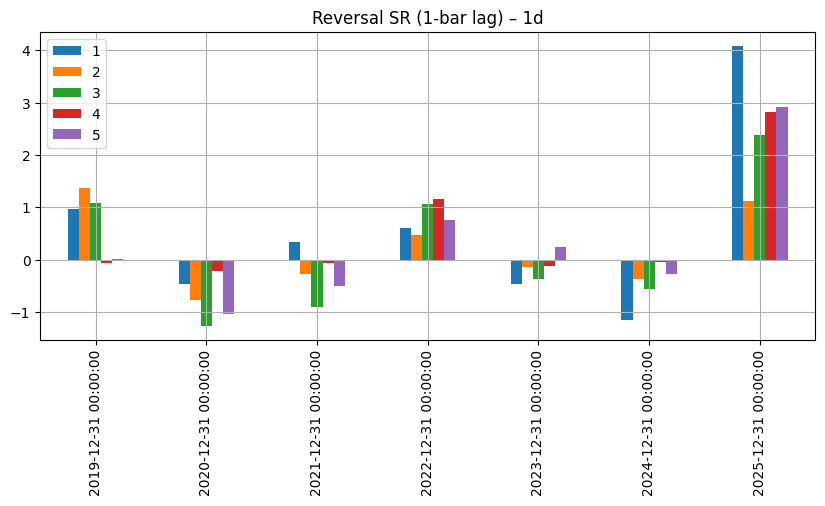

Computing SR with reversal strategy for frequency: 1w
Full-sample SR:
 1    0.000063
2    0.265999
3    0.284307
4    0.092911
5    0.076546
dtype: float64


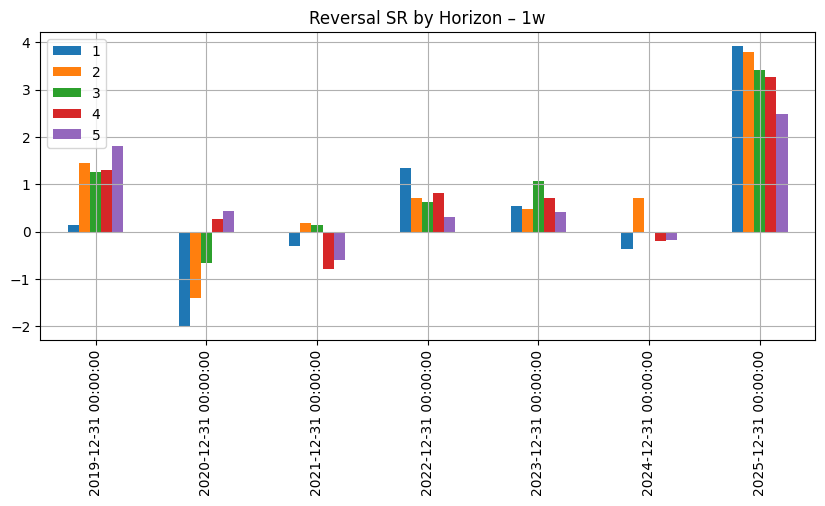

Full-sample SR (1-bar lag):
 1    0.485511
2    0.530045
3    0.222813
4    0.114862
5    0.208471
dtype: float64


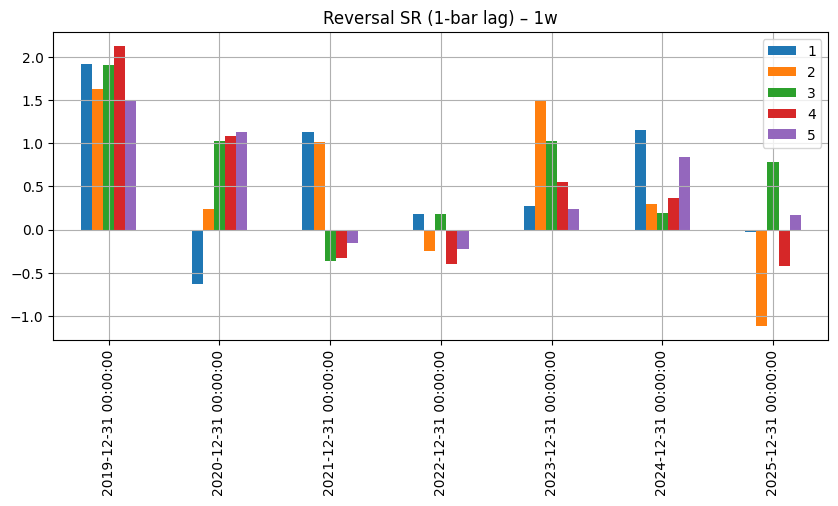

In [38]:
compute_sr_with_reversal_strategy(UNIVERSE, FREQ_LIST)